In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.express as px
import sklearn
from datetime import datetime

## 1. Initial data processing

In [2]:
lab_ds_path = 'nii_inf/export_LABD_PCR_weekly_201540_201939_FINAL.xlsx'
epi_ds_path = 'nii_inf/export_EPI_MAIN_weekly_201540_201939_FINAL.xlsx'

In [3]:
lab_ds = pd.read_excel(lab_ds_path)
epi_ds = pd.read_excel(epi_ds_path)
main_ds = pd.merge(left=epi_ds, right=lab_ds, how='outer', on=['REGION_NAME', 'DISTRICT_NAME', 'YEAR', 'WEEK'])
columns_to_change = {
    'POSA_0_2': 'posa_0_2',
    'POSA_3_6': 'posa_3_6',
    'POSA_7_14': 'posa_7_14',
    'POSA_15': 'posa_15',
    'POSA_TOTAL': 'posa_TOTAL',
    'SWBA_0_2': 'swba_0_2',
    'SWBA_3_6': 'swba_3_6',
    'SWBA_7_14': 'swba_7_14',
    'SWBA_15': 'swba_15',
    'SWBA_TOTAL': 'swba_TOTAL',
}
main_ds = main_ds.rename(columns=columns_to_change)
main_ds

,REGION_NAME,DISTRICT_NAME,LPU_NAME_x,YEAR,WEEK,ARI_0_2,ARI_3_6,ARI_7_14,ARI_15,ARI_TOTAL,...,swba_0_2,swba_3_6,swba_7_14,swba_15,swba_TOTAL,posa_0_2,posa_3_6,posa_7_14,posa_15,posa_TOTAL
0,Дальневосточный ФО,Биробиджан,ЦГиЭ,2015,40,212,163,87,85,547,...,7.0,1.0,3.0,1.0,12.0,5.0,1.0,0.0,0.0,6.0
1,Дальневосточный ФО,Владивосток,ЦГиЭ,2015,40,631,811,359,570,2371,...,4.0,5.0,0.0,22.0,31.0,1.0,1.0,0.0,4.0,6.0
2,Дальневосточный ФО,Магадан,ЦГиЭ,2015,40,149,200,155,128,632,...,11.0,6.0,1.0,4.0,22.0,7.0,2.0,0.0,0.0,9.0
3,Дальневосточный ФО,Петропавловск,ЦГиЭ,2015,40,297,334,226,193,1050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Дальневосточный ФО,Улан-Удэ,ЦГиЭ,2015,40,144,159,75,228,606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13018,Южный ФО,Волгоград,ЦГиЭ,2019,39,952,1178,890,1531,4551,...,4.0,3.0,7.0,9.0,23.0,1.0,0.0,2.0,3.0,6.0
13019,Южный ФО,Краснодар,ЦГиЭ,2019,39,45,102,71,415,633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13020,Южный ФО,Ростов-на-Дону,ЦГиЭ,2019,39,697,941,675,920,3233,...,32.0,9.0,7.0,8.0,56.0,25.0,7.0,2.0,0.0,34.0
13021,Южный ФО,Севастополь,ЦГиЭ,2019,39,175,287,402,259,1123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def make_dates(ds):
    ds['DATE'] = ds.apply(lambda x: datetime.strptime(f'{x["YEAR"]}-{x["WEEK"]}-1', "%Y-%W-%w"), axis=1)
    
def normalize(ds, features):
    # Need bold features: ARI_0_2 -> ARI
    all_features = ds.columns
    for feature in features:
        ages = [ft for ft in all_features if ft.startswith(feature)]
        pops = [pop for pop in all_features if pop.startswith('POP')]
        dct = {}
        for age in ages:
            interval = age.replace(feature, '')
            pop = [p for p in pops if p.endswith(interval)][0]
            dct[age] = pop
        for age_feat, age_pop in dct.items():
            ds[f'NORM_{age_feat}'] = ds[age_feat] / ds[age_pop] * 100_000

In [5]:
make_dates(main_ds)
normalize(main_ds, features=['ARI', 'ILI', 'SWB', 'POS', 'swba', 'posa'])
main_ds

,REGION_NAME,DISTRICT_NAME,LPU_NAME_x,YEAR,WEEK,ARI_0_2,ARI_3_6,ARI_7_14,ARI_15,ARI_TOTAL,...,NORM_swba_0_2,NORM_swba_3_6,NORM_swba_7_14,NORM_swba_15,NORM_swba_TOTAL,NORM_posa_0_2,NORM_posa_3_6,NORM_posa_7_14,NORM_posa_15,NORM_posa_TOTAL
0,Дальневосточный ФО,Биробиджан,ЦГиЭ,2015,40,212,163,87,85,547,...,238.989416,26.246719,46.367852,1.624220,16.047715,170.706726,26.246719,0.000000,0.000000,8.023858
1,Дальневосточный ФО,Владивосток,ЦГиЭ,2015,40,631,811,359,570,2371,...,20.372823,19.206392,0.000000,4.441995,5.263372,5.093206,3.841278,0.000000,0.807635,1.018717
2,Дальневосточный ФО,Магадан,ЦГиЭ,2015,40,149,200,155,128,632,...,297.619048,130.406433,11.863804,4.743889,21.772478,189.393939,43.468811,0.000000,0.000000,8.906923
3,Дальневосточный ФО,Петропавловск,ЦГиЭ,2015,40,297,334,226,193,1050,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Дальневосточный ФО,Улан-Удэ,ЦГиЭ,2015,40,144,159,75,228,606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13018,Южный ФО,Волгоград,ЦГиЭ,2019,39,952,1178,890,1531,4551,...,11.874017,6.982428,8.925725,1.048394,2.269290,2.968504,0.000000,2.550207,0.349465,0.591989
13019,Южный ФО,Краснодар,ЦГиЭ,2019,39,45,102,71,415,633,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13020,Южный ФО,Ростов-на-Дону,ЦГиЭ,2019,39,697,941,675,920,3233,...,83.318145,21.174976,9.631393,0.827912,5.000558,65.092301,16.469426,2.751827,0.000000,3.036053
13021,Южный ФО,Севастополь,ЦГиЭ,2019,39,175,287,402,259,1123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def get_district_data(ds):
    districts = ds.DISTRICT_NAME.unique()
    data = {}
    for dst in districts:
        dst_df = ds[ds.DISTRICT_NAME==dst].sort_values(['YEAR', 'WEEK'])
        data[dst] = dst_df
    return data

In [25]:
def plot_timeline(df, title, features, cities=None):
    if cities == None:
        cities = df.DISTRICT_NAME.unique()
    fig = go.Figure()
    for city in cities:
        city_data = df[df.DISTRICT_NAME==city]
        for feature in features:
            fig.add_trace(go.Scatter(x=city_data.DATE, y=city_data[feature],
                                    name=f'{city} - {feature}'))
    fig.update_layout(title=title)

    fig.show()

In [27]:
plot_timeline(main_ds, title='Some timeline', 
              features=['NORM_ILI_TOTAL', 'NORM_swba_TOTAL'], cities=['Москва', 'Санкт-Петербург'])

## 2. Calculating target metrics

In [9]:
def non_epid_feature_22_35(ds, feature):
    features = [ft for ft in ds.columns if ft.startswith(feature)]
    new_features = [f'{ft}_mean_22_35' for ft in features]
    new_features.append('DISTRICT_NAME')
    features.append('DISTRICT_NAME')
    cities = ds.DISTRICT_NAME.unique()
    ds = ds[ds.WEEK.between(22, 35)].sort_values(['DISTRICT_NAME', 'YEAR', 'WEEK'])
    ds = ds[features]
    ds = ds.groupby('DISTRICT_NAME').mean()
#     for ft, new_ft in zip(features, new_features):
#         ds = ds.rename(columns={ft:new_ft})
    return ds
    
    
targets = pd.DataFrame(data=main_ds.DISTRICT_NAME.unique(), columns=['DISTRICT_NAME'])
features = ['NORM_ARI', 'NORM_ILI', 'NORM_SWB', 'NORM_POS', 'NORM_swba', 'NORM_posa']
for ft in features:
    targets = pd.merge(left=targets, right=non_epid_feature_22_35(main_ds, ft), how='inner', on=['DISTRICT_NAME'])
targets

,DISTRICT_NAME,NORM_ARI_0_2,NORM_ARI_3_6,NORM_ARI_7_14,NORM_ARI_15,NORM_ARI_TOTAL,NORM_ILI_0_2,NORM_ILI_3_6,NORM_ILI_7_14,NORM_ILI_15,...,NORM_swba_0_2,NORM_swba_3_6,NORM_swba_7_14,NORM_swba_15,NORM_swba_TOTAL,NORM_posa_0_2,NORM_posa_3_6,NORM_posa_7_14,NORM_posa_15,NORM_posa_TOTAL
0,Биробиджан,4144.327963,2454.707027,411.164210,29.588131,355.554908,0.000000,0.000000,0.000000,0.059293,...,197.048199,49.114699,13.990959,5.061977,16.061074,108.773790,22.795576,4.801486,1.111067,7.004301
1,Владивосток,1734.848667,1564.961249,275.808203,38.981082,178.764987,0.000000,0.000000,0.000000,0.000000,...,22.355315,11.339087,3.346739,1.231619,2.523922,8.360346,3.858936,0.529017,0.183991,0.633720
2,Магадан,2576.621010,1985.927651,246.799533,38.610189,244.331483,0.484853,0.000000,0.400834,0.000000,...,97.096361,32.732407,12.252725,1.281273,7.308291,48.923277,12.673100,4.430050,0.449724,3.179704
3,Петропавловск,1199.296389,1252.530753,171.134798,32.147920,147.374441,0.499990,0.407093,0.359926,0.011932,...,133.227042,55.161892,19.985856,2.425600,11.503828,64.499242,26.397480,4.925151,0.331764,4.462755
4,Улан-Удэ,156.951424,123.365685,24.045946,14.801070,29.440609,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,Волгоград,1735.393744,1595.499055,382.203022,72.621363,216.372300,0.000000,0.000000,0.000000,0.000000,...,9.652786,6.634901,3.902516,0.369432,1.214079,3.627322,1.786062,0.808621,0.060219,0.309718
57,Краснодар,111.018792,199.247625,44.321657,32.963174,45.523619,0.000000,0.000000,0.021162,0.004602,...,3.266935,6.389367,0.701255,0.494111,0.962591,0.000000,0.000000,0.000000,0.000000,0.000000
58,Ростов-на-Дону,1663.365311,1434.782148,475.577784,43.904205,178.752329,0.000000,0.084028,0.073710,0.000000,...,59.502296,36.130070,9.552167,0.950252,4.824256,26.121520,14.644400,2.508891,0.094085,1.683431
59,Симферополь,1179.018833,1413.882862,552.390122,62.487752,218.997964,0.000000,0.000000,0.000000,0.000000,...,2.093215,0.307253,0.000000,0.000000,0.096417,0.837286,0.000000,0.000000,0.000000,0.032139


In [10]:
targets.to_csv('metrics.csv')

## 3. Merging with outer cities data

In [11]:
data = pd.read_csv('final.csv', index_col=0)
data = data.rename(columns={'city': 'DISTRICT_NAME'})
data = data.drop(columns=['POP_TOTAL', '2017 год', '2018 год', '2019 год', 'sqr_km', 'most_common'])
print(data.columns)
data

Index(['2017_quality', '2018_quality', '2019_quality', 'DISTRICT_NAME',
       'habbit_rate', 'perc_more_100k', 'percent_less_15k',
       'Средняя годовая температура, °C',
       'Температура самого холодного месяца, °C',
       'Температура трёх самых холодных месяцев, °C',
       'Температура самого тёплого месяца, °C',
       'Температура трёх самых тёплых месяцев, °C', 'Абсолютный минимум,',
       'Абсолютный максимум, °C', 'Среднее годовое количество осадков, мм',
       'num_terapevts', 'num_terapevts_100k_peaple', 'num_pediators',
       'num_pediators_100k_peaple', 'Плотность'],
      dtype='object')


,2017_quality,2018_quality,2019_quality,DISTRICT_NAME,habbit_rate,perc_more_100k,percent_less_15k,"Средняя годовая температура, °C","Температура самого холодного месяца, °C","Температура трёх самых холодных месяцев, °C","Температура самого тёплого месяца, °C","Температура трёх самых тёплых месяцев, °C","Абсолютный минимум,","Абсолютный максимум, °C","Среднее годовое количество осадков, мм",num_terapevts,num_terapevts_100k_peaple,num_pediators,num_pediators_100k_peaple,Плотность
0,1.0,1.0,1.0,Ярославль,47.6,2.1,13.4,1.3,-12.8,-11.3,16.3,14.1,-45.2,34.4,NaN,650.0,6.34,539.0,22.47,2873.663751
1,1.0,2.0,2.0,Архангельск,55.5,7.5,2.3,5.0,-10.3,-9.5,20.2,18.8,-40.0,39.3,607.0,NaN,NaN,NaN,NaN,1213.942667
2,1.0,1.0,2.0,Ульяновск,73.6,1.6,17.0,0.6,-10.0,-9.3,12.9,11.1,-39.4,32.9,470.0,639.0,6.26,379.0,16.76,2140.876667
3,1.0,1.0,1.0,Мурманск,36.1,13.0,0.5,3.1,-10.8,-9.7,17.5,15.8,-47.1,36.4,494.0,238.0,3.98,232.0,14.93,1999.676585
4,1.0,1.0,1.0,Вологда,55.6,3.6,9.0,3.5,-12.9,-10.9,18.8,17.3,-44.3,39.9,565.0,276.0,2.98,326.0,13.05,2735.798842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2.0,1.0,1.0,Томск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,568.0,568.0,6.67,456.0,20.15,1946.823688
57,1.0,1.0,1.0,Владимир,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,584.0,490.0,4.35,374.0,14.82,2558.344403
58,1.0,1.0,1.0,Калининград,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,818.0,349.0,4.36,261.0,13.50,2011.426009
59,3.0,2.0,2.0,Челябинск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,429.0,1126.0,4.09,996.0,13.41,2359.365592


### Eliminating correlated features

In [12]:
data = data.drop(columns=['Температура самого холодного месяца, °C', 'Температура самого тёплого месяца, °C',
                             'Абсолютный минимум,', 'Абсолютный максимум, °C',
                             'num_terapevts', 'num_pediators'])

In [13]:
data['air_quality'] = (data['2017_quality'] + data['2018_quality'] + data['2019_quality']) / 3
data = data.drop(columns=['2017_quality', '2018_quality', '2019_quality'])

### Merging

In [14]:
merged = pd.merge(left=data, right=targets, on='DISTRICT_NAME', how='inner')
merged = merged.fillna(merged.mean(axis=0))
print(merged.columns)
merged

Index(['DISTRICT_NAME', 'habbit_rate', 'perc_more_100k', 'percent_less_15k',
       'Средняя годовая температура, °C',
       'Температура трёх самых холодных месяцев, °C',
       'Температура трёх самых тёплых месяцев, °C',
       'Среднее годовое количество осадков, мм', 'num_terapevts_100k_peaple',
       'num_pediators_100k_peaple', 'Плотность', 'air_quality', 'NORM_ARI_0_2',
       'NORM_ARI_3_6', 'NORM_ARI_7_14', 'NORM_ARI_15', 'NORM_ARI_TOTAL',
       'NORM_ILI_0_2', 'NORM_ILI_3_6', 'NORM_ILI_7_14', 'NORM_ILI_15',
       'NORM_ILI_TOTAL', 'NORM_SWB_0_2', 'NORM_SWB_3_6', 'NORM_SWB_7_14',
       'NORM_SWB_15', 'NORM_SWB_TOTAL', 'NORM_POS_0_2', 'NORM_POS_3_6',
       'NORM_POS_7_14', 'NORM_POS_15', 'NORM_POS_TOTAL', 'NORM_swba_0_2',
       'NORM_swba_3_6', 'NORM_swba_7_14', 'NORM_swba_15', 'NORM_swba_TOTAL',
       'NORM_posa_0_2', 'NORM_posa_3_6', 'NORM_posa_7_14', 'NORM_posa_15',
       'NORM_posa_TOTAL'],
      dtype='object')


,DISTRICT_NAME,habbit_rate,perc_more_100k,percent_less_15k,"Средняя годовая температура, °C","Температура трёх самых холодных месяцев, °C","Температура трёх самых тёплых месяцев, °C","Среднее годовое количество осадков, мм",num_terapevts_100k_peaple,num_pediators_100k_peaple,...,NORM_swba_0_2,NORM_swba_3_6,NORM_swba_7_14,NORM_swba_15,NORM_swba_TOTAL,NORM_posa_0_2,NORM_posa_3_6,NORM_posa_7_14,NORM_posa_15,NORM_posa_TOTAL
0,Ярославль,47.600000,2.10000,13.400000,1.30000,-11.300000,14.100000,567.489796,6.340000,22.470000,...,10.779467,6.528085,1.667517,0.191205,1.141255,0.430727,0.350041,0.000000,0.000000,0.363914
1,Архангельск,55.500000,7.50000,2.300000,5.00000,-9.500000,18.800000,607.000000,5.251702,15.902979,...,13.053511,2.086193,0.742692,0.348964,0.905893,2.891575,0.000000,0.161932,0.000000,0.115842
2,Ульяновск,73.600000,1.60000,17.000000,0.60000,-9.300000,11.100000,470.000000,6.260000,16.760000,...,0.214243,0.225523,0.241953,0.345745,0.329376,0.000000,0.000000,0.000000,0.000000,0.000000
3,Мурманск,36.100000,13.00000,0.500000,3.10000,-9.700000,15.800000,494.000000,3.980000,14.930000,...,25.548320,8.440970,2.236615,0.080005,1.487221,14.044415,3.607070,0.696189,0.000000,0.684458
4,Вологда,55.600000,3.60000,9.000000,3.50000,-10.900000,17.300000,565.000000,2.980000,13.050000,...,20.582625,6.343521,4.833766,1.060974,2.635027,8.007701,2.889918,1.211456,0.285748,0.886120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,Томск,57.326531,5.52449,10.663265,4.07551,-10.106122,17.842857,568.000000,6.670000,20.150000,...,11.476485,4.551619,2.406149,0.724879,1.612529,0.000000,0.059935,0.000000,0.000000,0.501555
57,Владимир,57.326531,5.52449,10.663265,4.07551,-10.106122,17.842857,584.000000,4.350000,14.820000,...,2.898246,1.327979,0.479248,0.052328,0.419339,0.000000,0.000000,0.000000,0.000000,0.066206
58,Калининград,57.326531,5.52449,10.663265,4.07551,-10.106122,17.842857,818.000000,4.360000,13.500000,...,20.156748,6.345675,2.765934,1.198854,2.249126,9.567767,2.985727,0.898697,0.164357,0.695939
59,Челябинск,57.326531,5.52449,10.663265,4.07551,-10.106122,17.842857,429.000000,4.090000,13.410000,...,10.538364,4.875694,1.397232,0.190994,0.970440,4.560836,1.501355,0.258778,0.016748,0.305791


## 4. ML analisys

In [15]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [16]:
def fit_model(model, ds, target, scale=False):
    all_targets = targets.columns
    X = ds.drop(columns=all_targets)
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    y = ds[target]
    model.fit(X, y)
    return model

In [35]:
def plot_feature_importances(model, df, target, title, metric='neg_mean_squared_error', scale=False):
    cv = GridSearchCV(model, param_grid={}, cv=10, scoring=metric)
    fit_model(cv, merged, target, scale)
    print(f'{title} Best CV score: {cv.best_score_}')
    if hasattr(cv.best_estimator_, 'feature_importances_'):
        importances = cv.best_estimator_.feature_importances_
    else:
        importances = cv.best_estimator_.coef_
    features = data.drop(columns='DISTRICT_NAME').columns
    df = pd.DataFrame([abs(importances), features]).T.sort_values(0, ascending=False)
    plt.figure(figsize=(10, 10))
    plt.barh(df[1], df[0])
    plt.title(title)
    plt.show()

LASSO features for NORM_ARI_0_2 Best CV score: -995219.2682422822


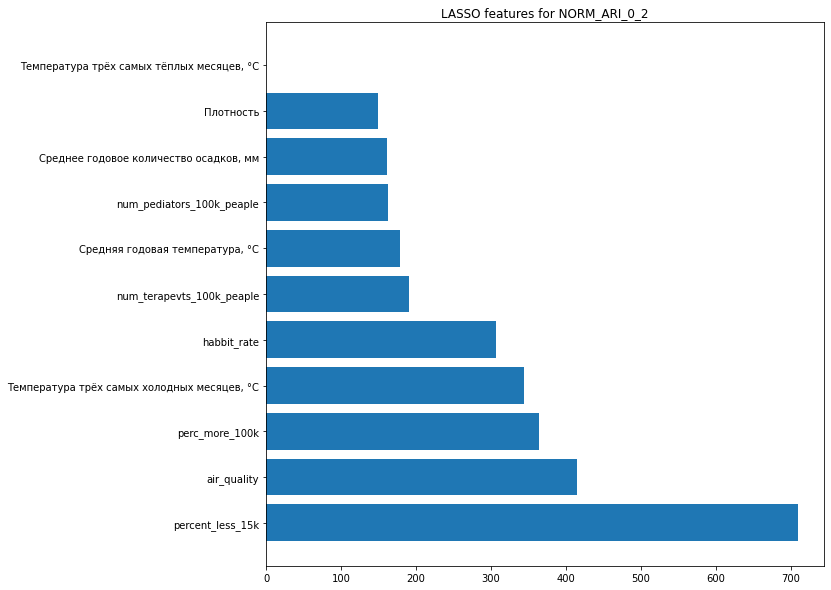

RANDOM FOREST features for NORM_ARI_0_2 Best CV score: -997489.0021134907


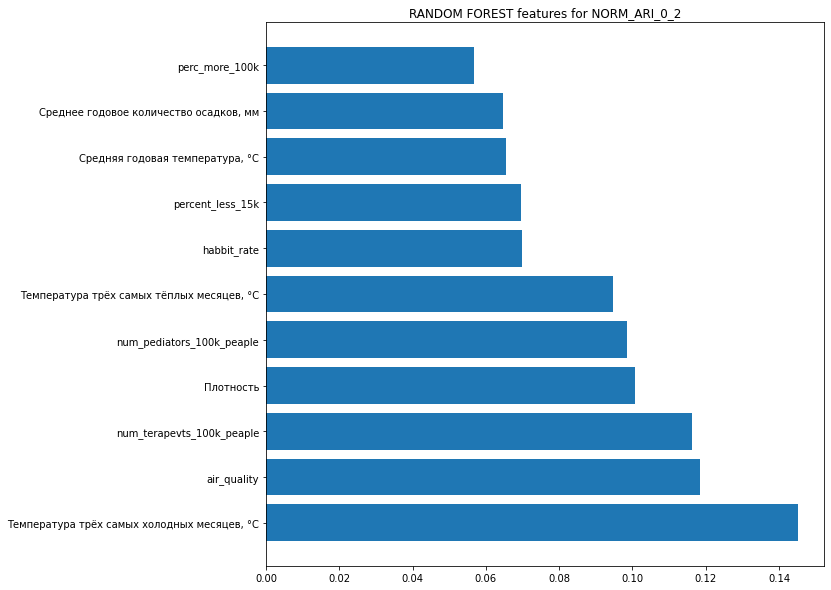

LASSO features for NORM_ARI_3_6 Best CV score: -613560.0552068944


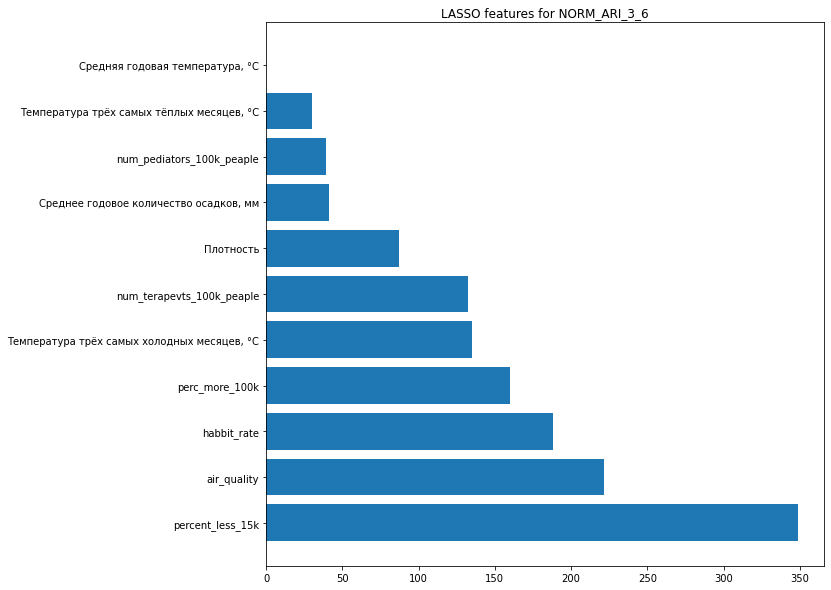

RANDOM FOREST features for NORM_ARI_3_6 Best CV score: -538650.4746524409


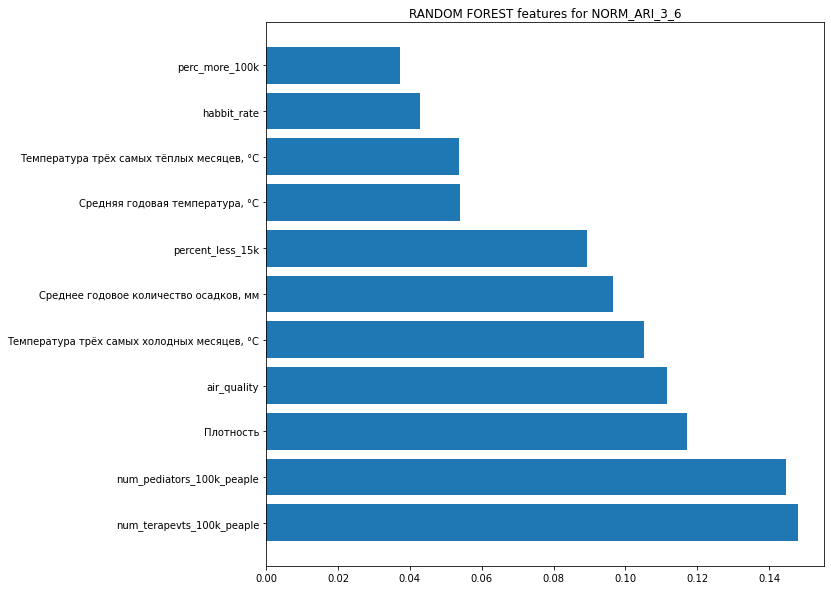

LASSO features for NORM_ARI_7_14 Best CV score: -27894.93463268056


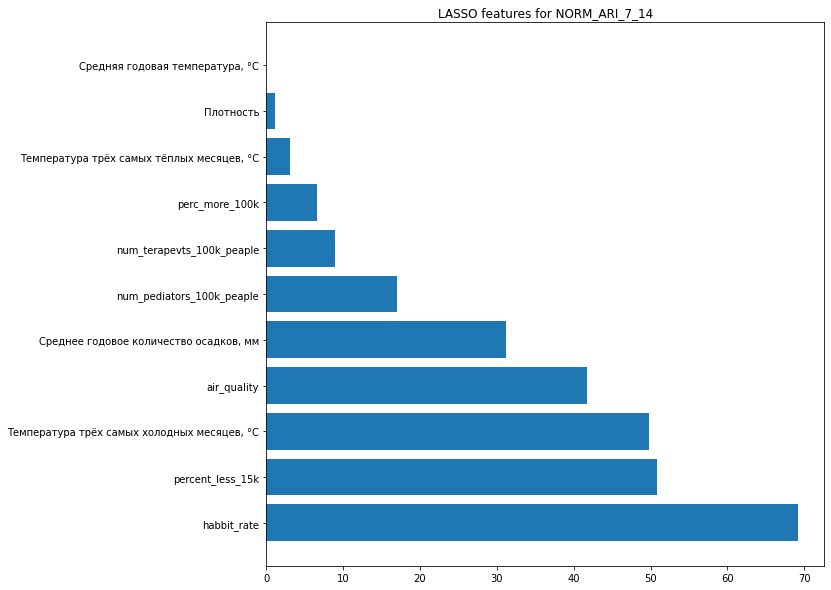

RANDOM FOREST features for NORM_ARI_7_14 Best CV score: -22279.241688863265


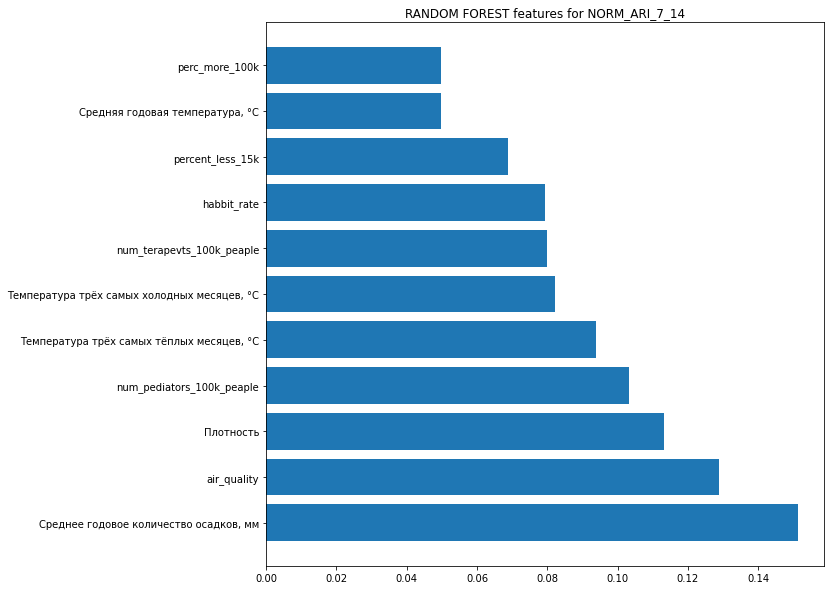

LASSO features for NORM_ARI_15 Best CV score: -2109.4113067108983


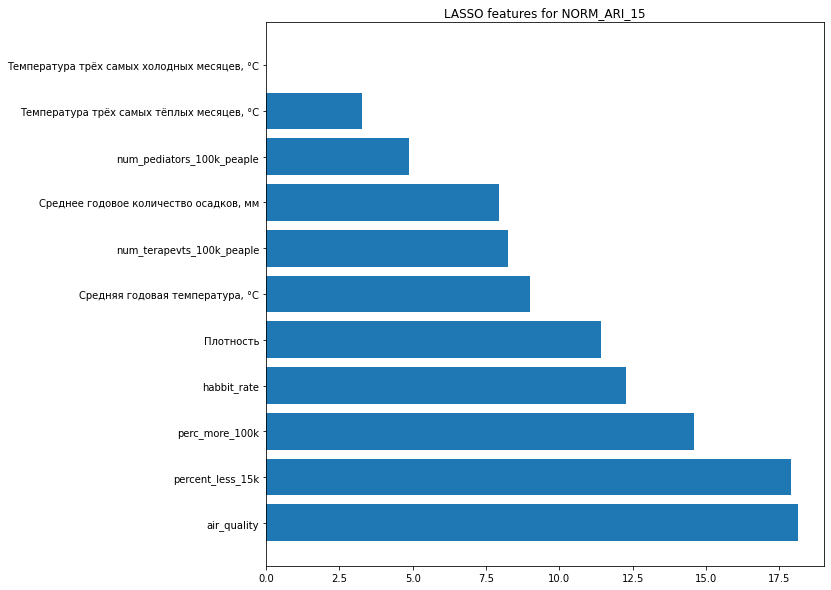

RANDOM FOREST features for NORM_ARI_15 Best CV score: -2291.0211763106104


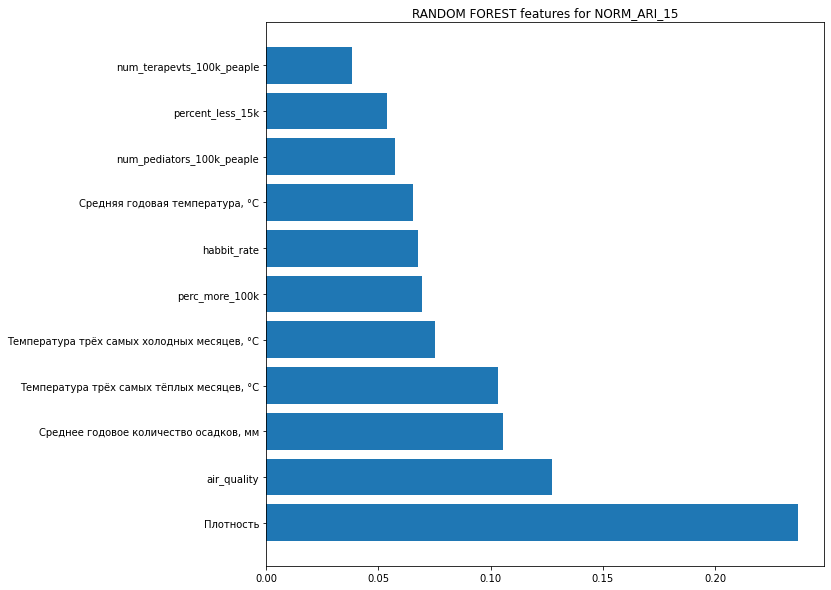

LASSO features for NORM_ARI_TOTAL Best CV score: -10267.168862190196


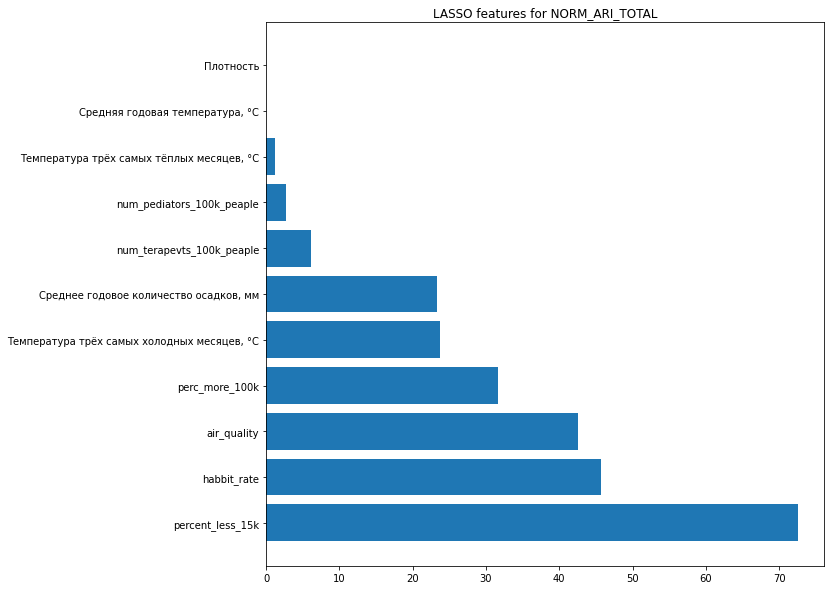

RANDOM FOREST features for NORM_ARI_TOTAL Best CV score: -10744.94787464326


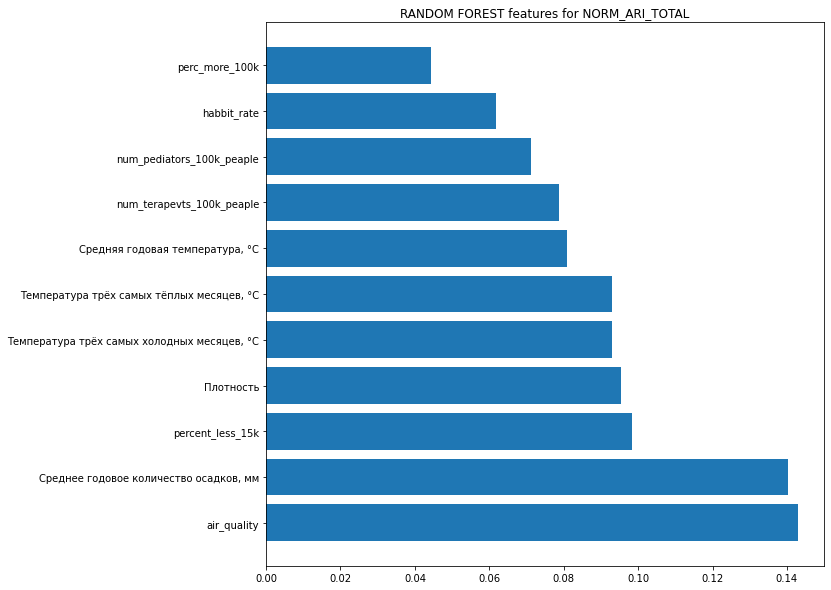

LASSO features for NORM_ILI_0_2 Best CV score: -0.02485631507593302


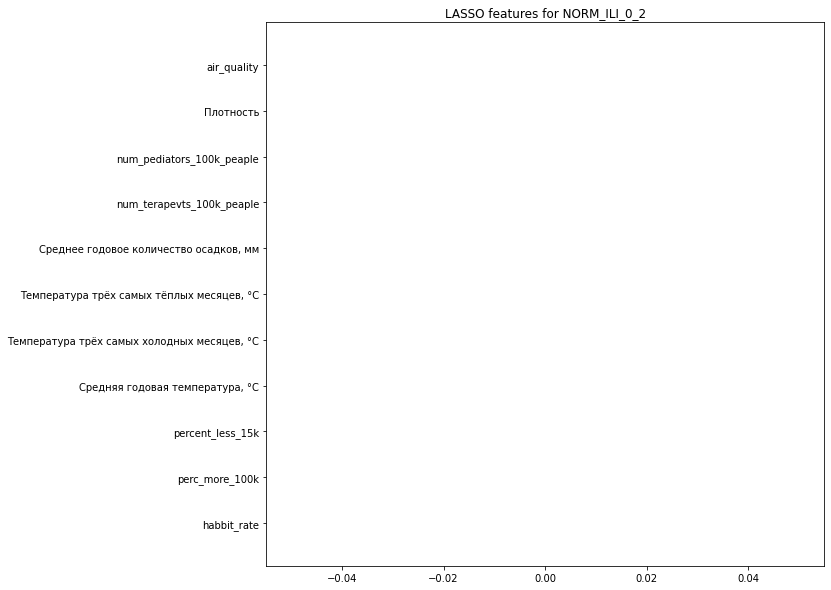

RANDOM FOREST features for NORM_ILI_0_2 Best CV score: -0.02743077814061049


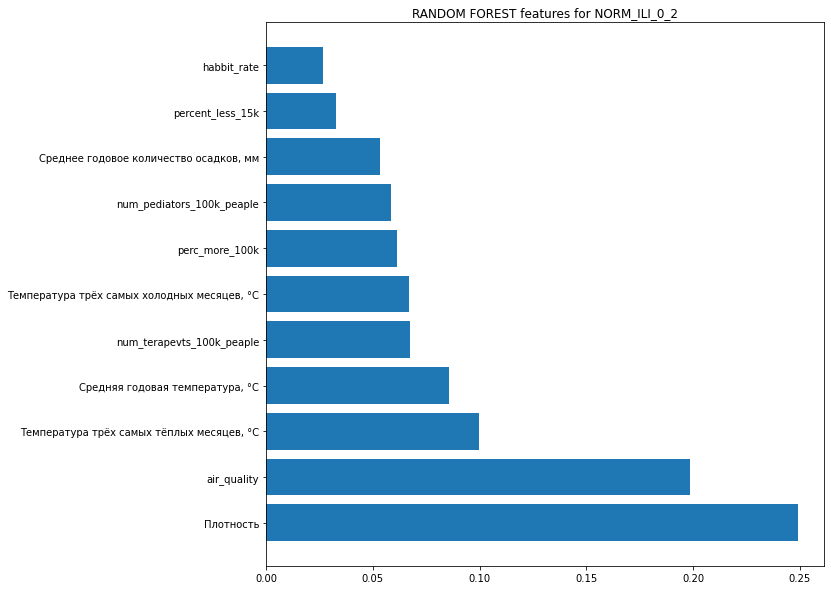

LASSO features for NORM_ILI_3_6 Best CV score: -0.00609153183184914


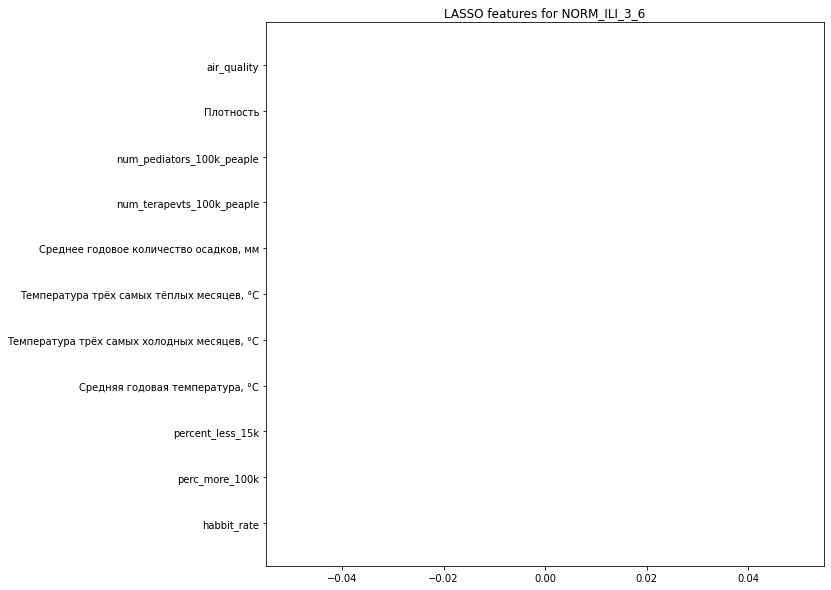

RANDOM FOREST features for NORM_ILI_3_6 Best CV score: -0.009281687856296773


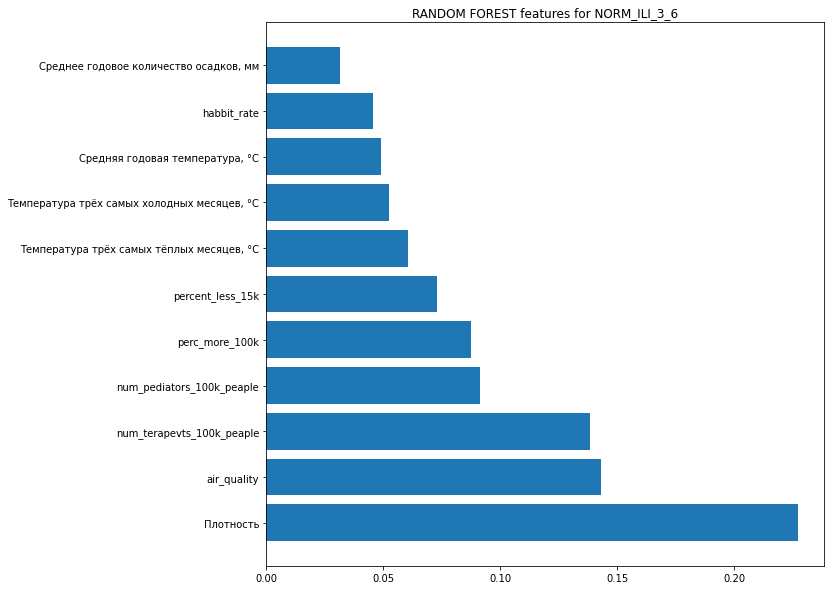

LASSO features for NORM_ILI_7_14 Best CV score: -0.005482736479888048


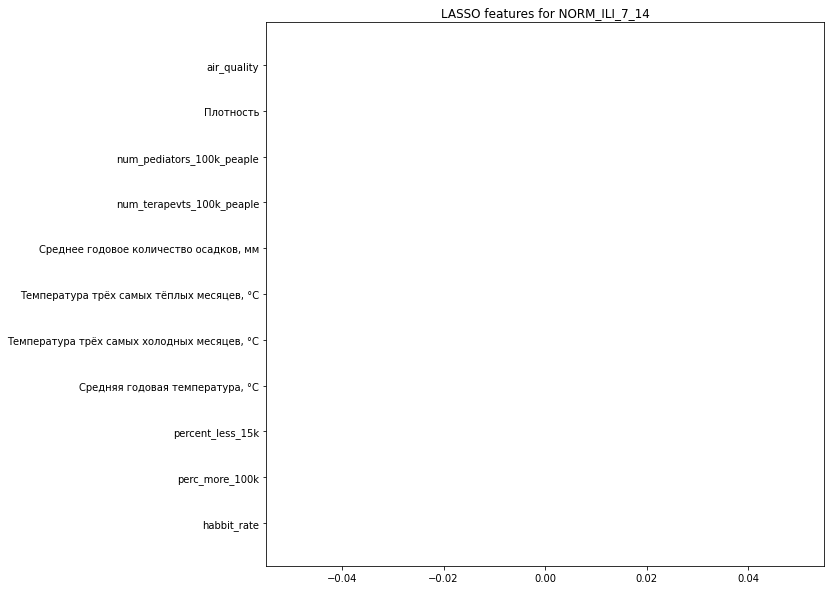

RANDOM FOREST features for NORM_ILI_7_14 Best CV score: -0.005572374872047377


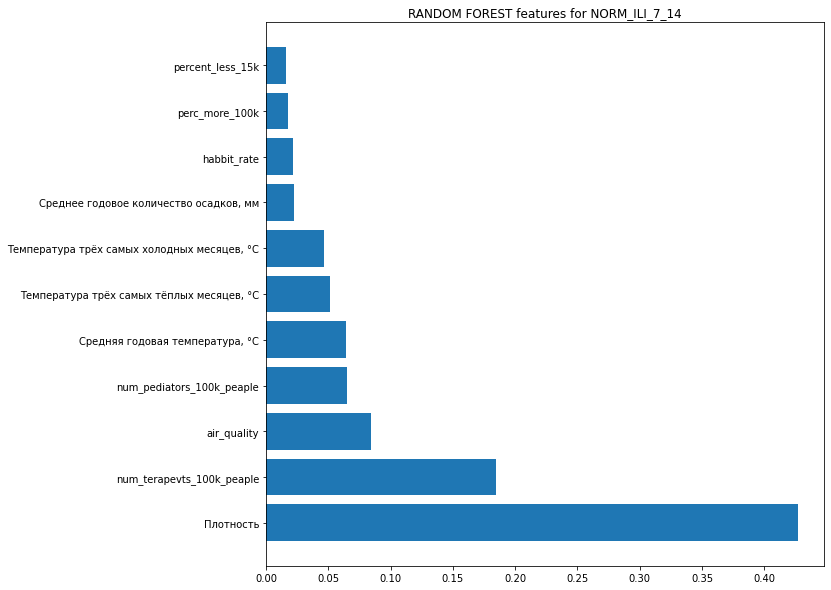

LASSO features for NORM_ILI_15 Best CV score: -0.00022137630917482844


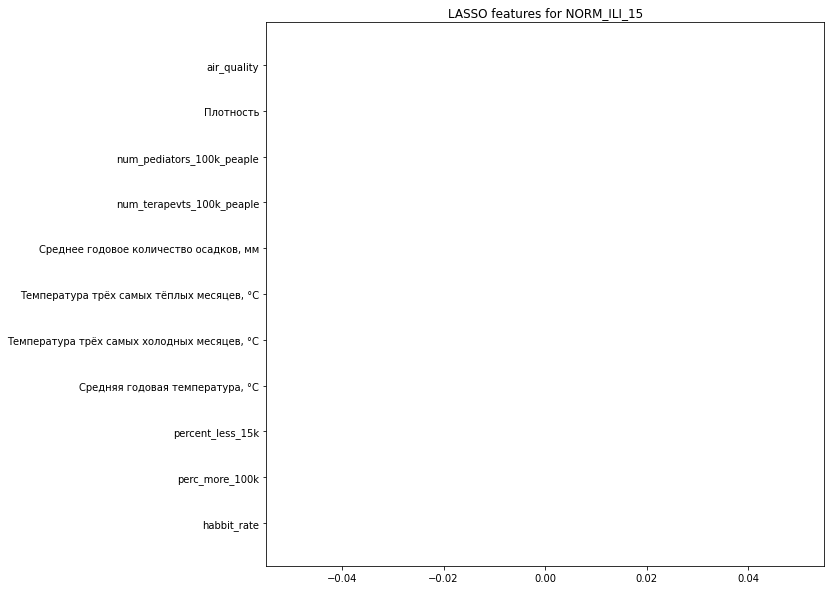

RANDOM FOREST features for NORM_ILI_15 Best CV score: -0.00023976963207600986


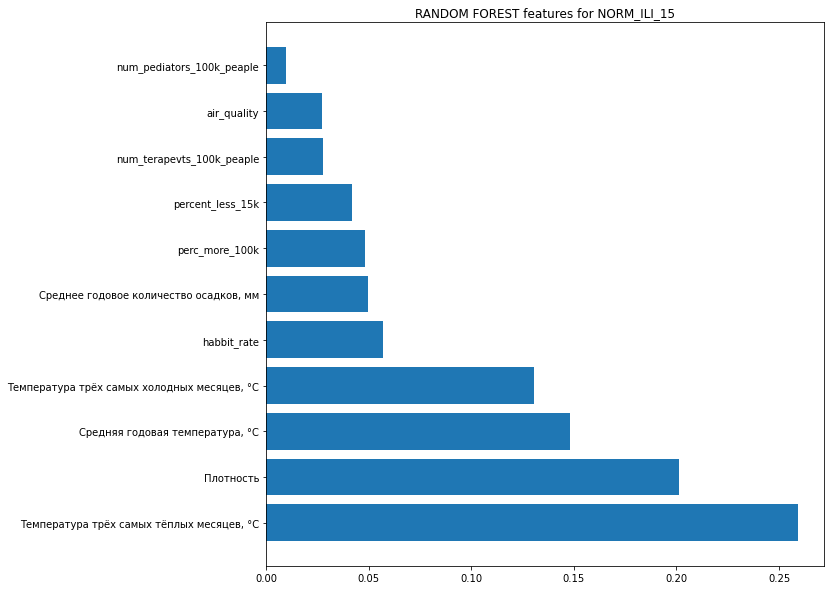

LASSO features for NORM_ILI_TOTAL Best CV score: -0.00047233083400185035


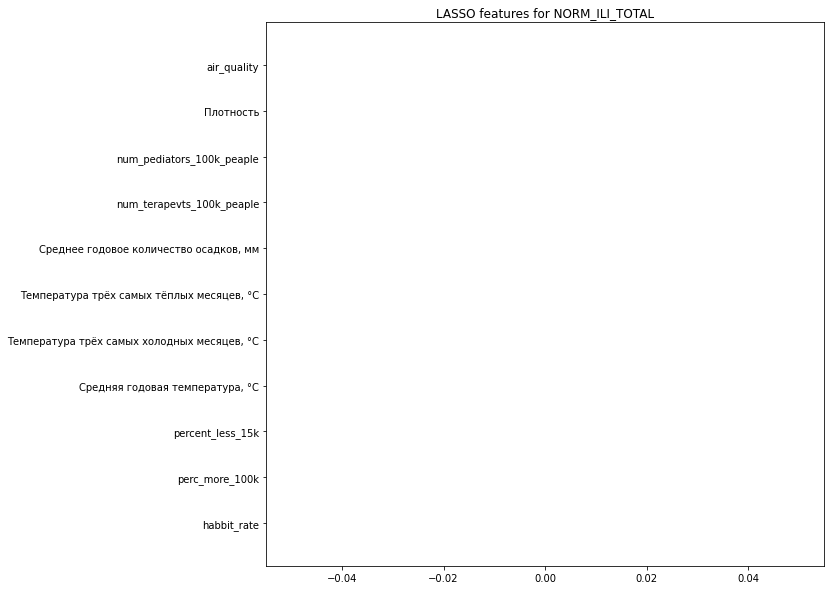

RANDOM FOREST features for NORM_ILI_TOTAL Best CV score: -0.00036223247200892135


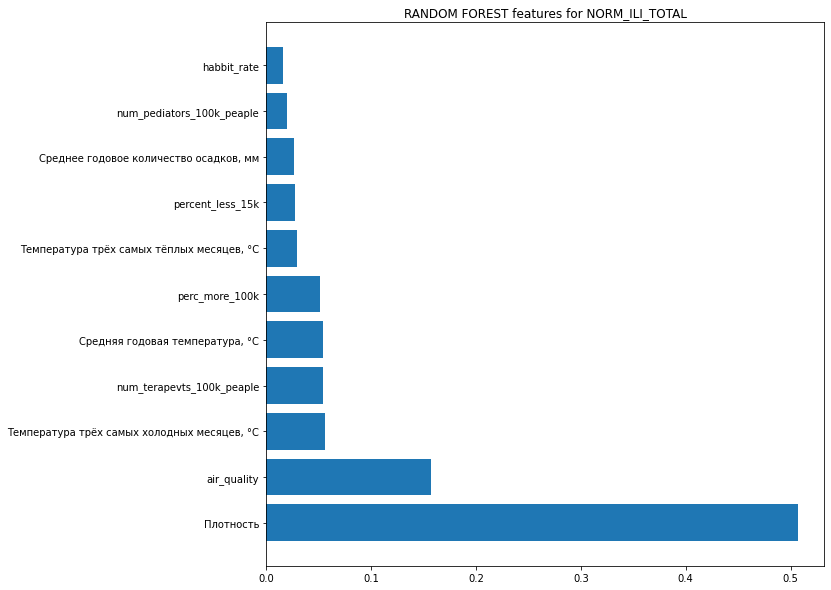

LASSO features for NORM_SWB_0_2 Best CV score: -1587.8041486994073


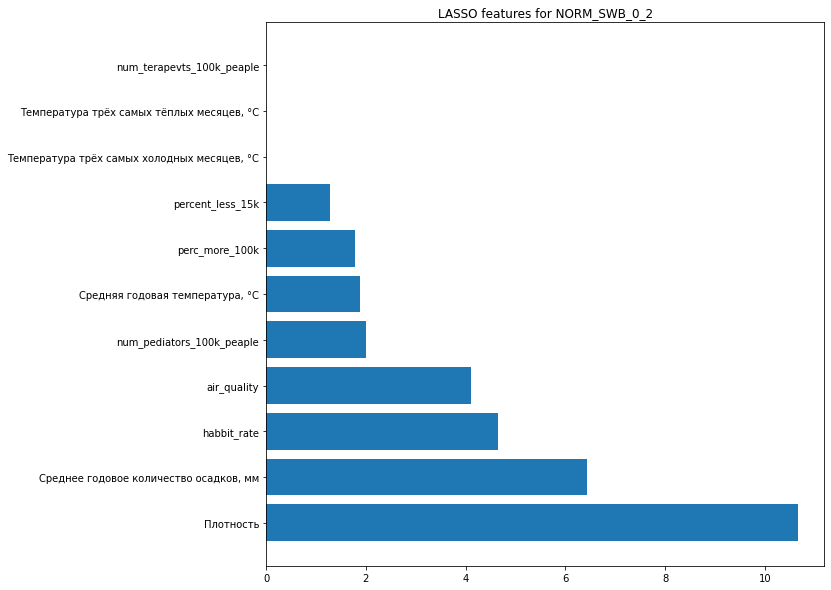

RANDOM FOREST features for NORM_SWB_0_2 Best CV score: -1193.6797108477717


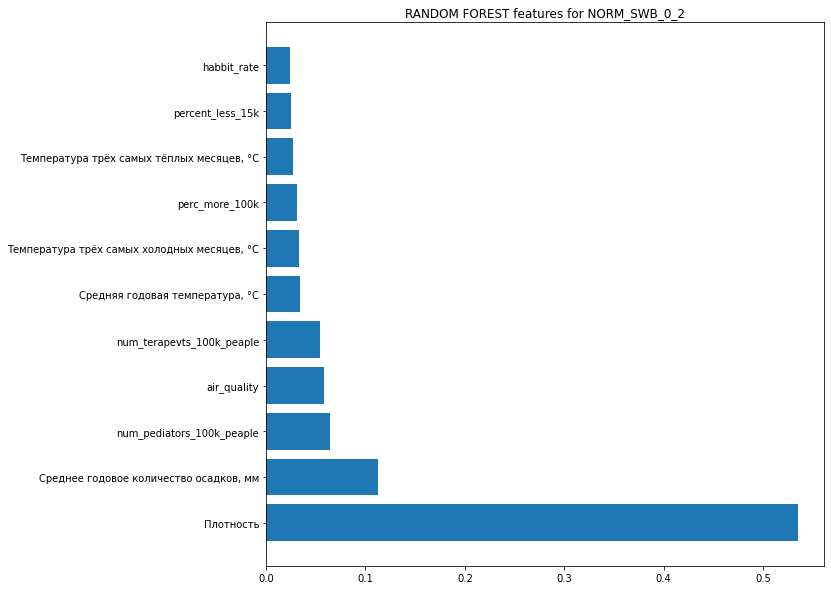

LASSO features for NORM_SWB_3_6 Best CV score: -147.60063158895417


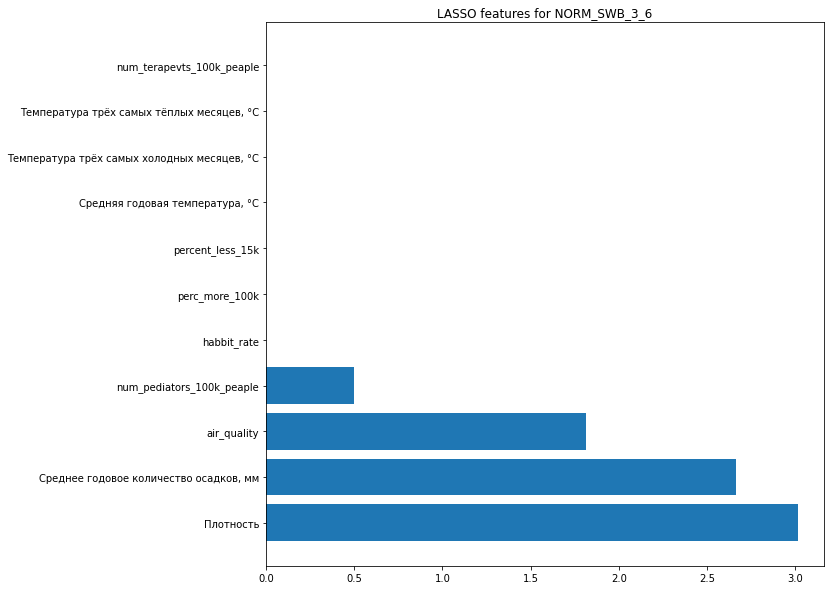

RANDOM FOREST features for NORM_SWB_3_6 Best CV score: -138.67674291896725


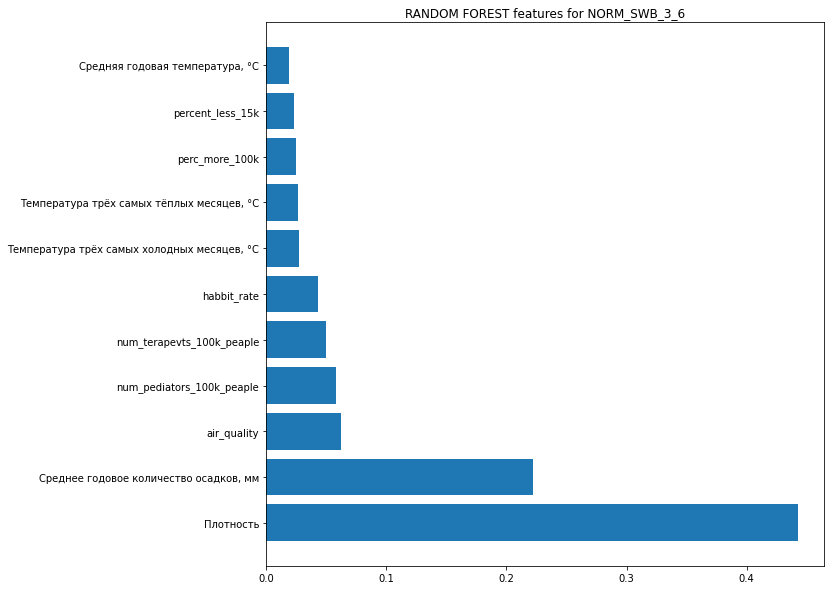

LASSO features for NORM_SWB_7_14 Best CV score: -17.699916454790884


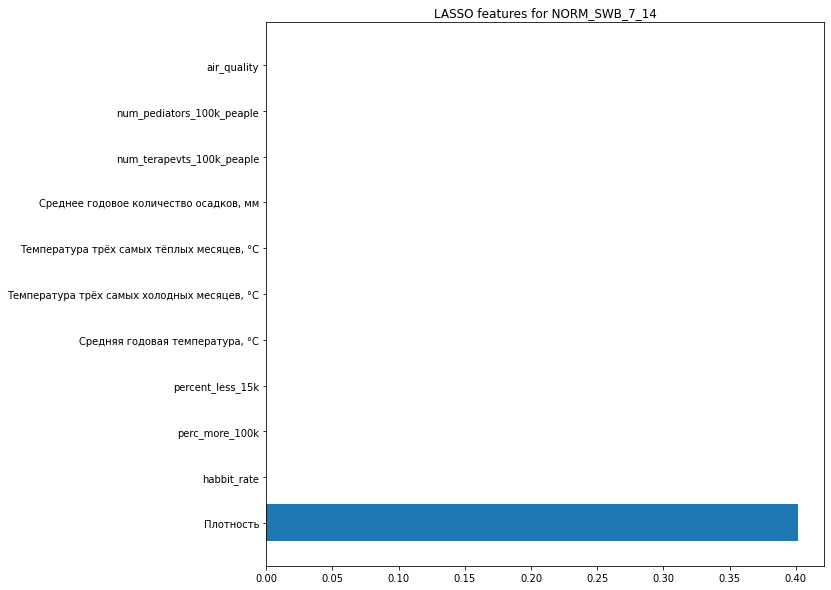

RANDOM FOREST features for NORM_SWB_7_14 Best CV score: -14.962552869062028


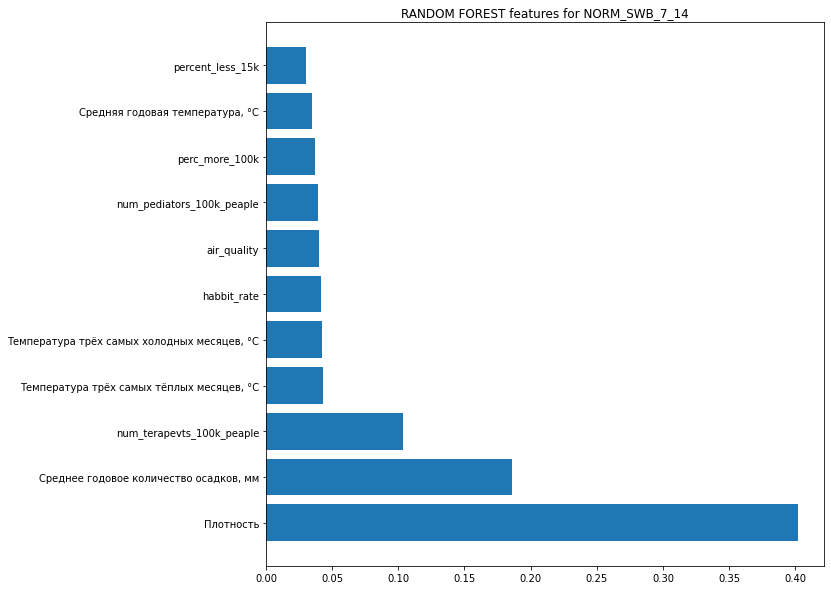

LASSO features for NORM_SWB_15 Best CV score: -3.34643558816159


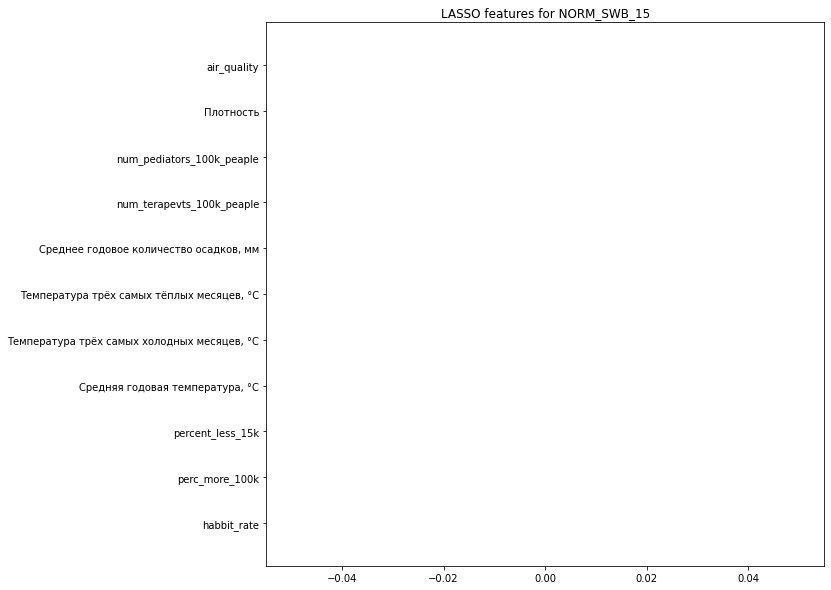

RANDOM FOREST features for NORM_SWB_15 Best CV score: -3.622119106296217


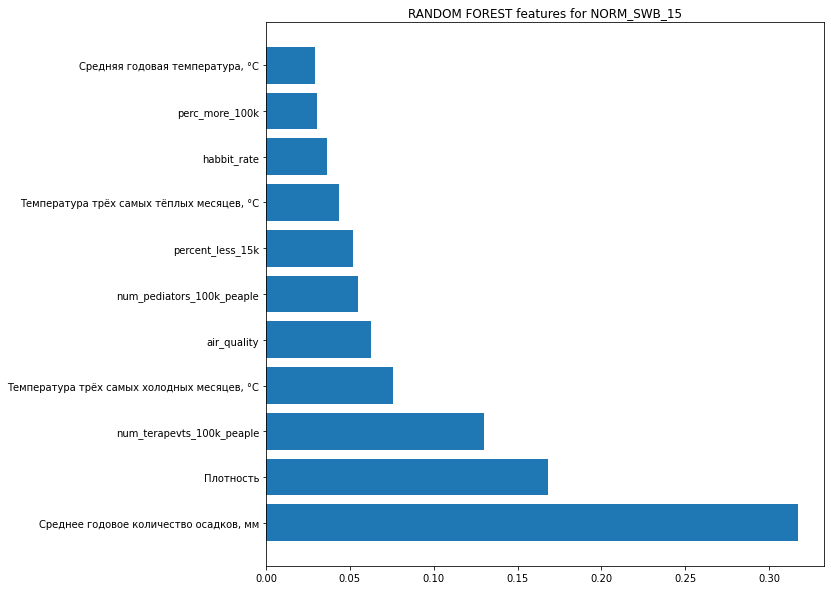

LASSO features for NORM_SWB_TOTAL Best CV score: -11.30478603588998


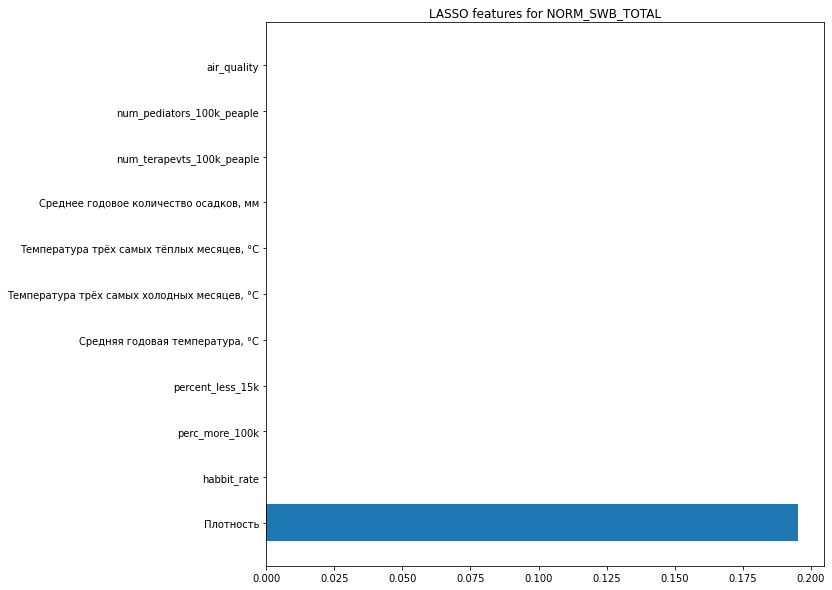

RANDOM FOREST features for NORM_SWB_TOTAL Best CV score: -10.112095613162314


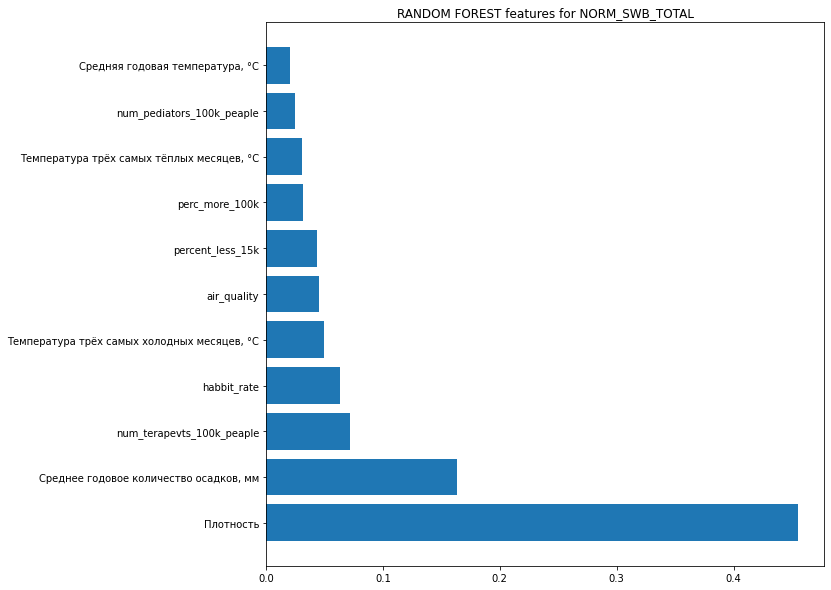

LASSO features for NORM_POS_0_2 Best CV score: -0.03705708722349106


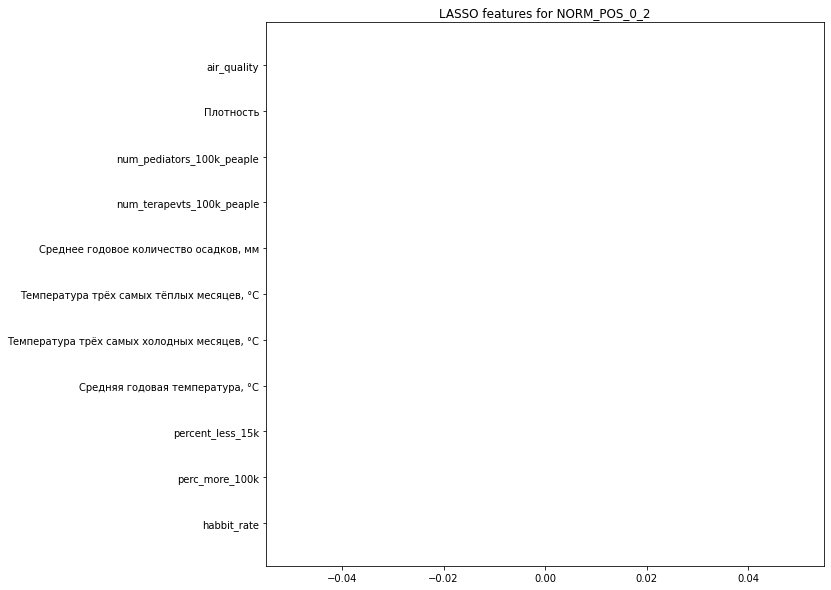

RANDOM FOREST features for NORM_POS_0_2 Best CV score: -0.05075820793898892


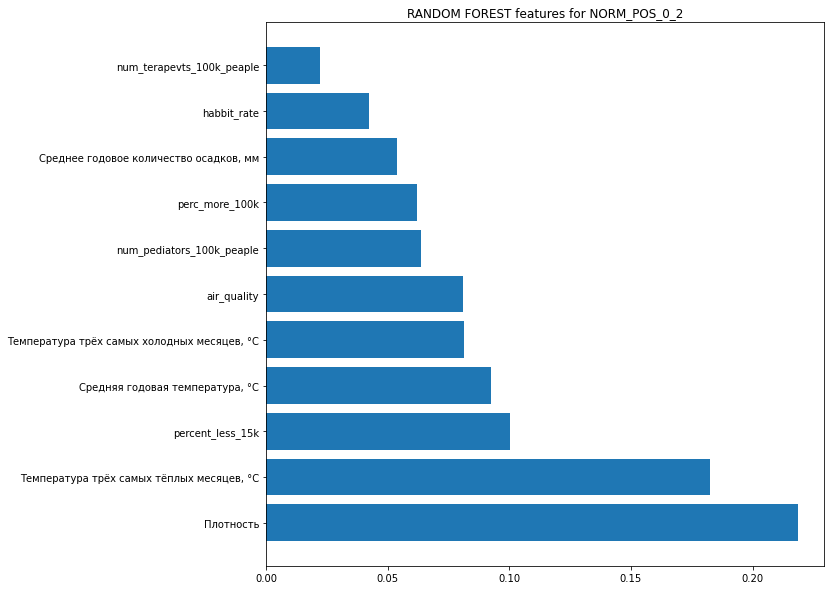

LASSO features for NORM_POS_3_6 Best CV score: -0.016772426921976585


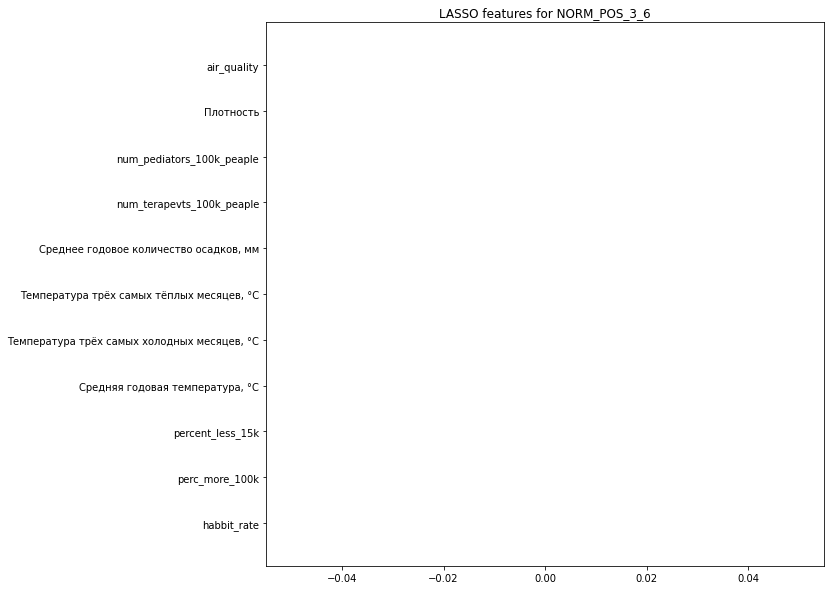

RANDOM FOREST features for NORM_POS_3_6 Best CV score: -0.023895069329202368


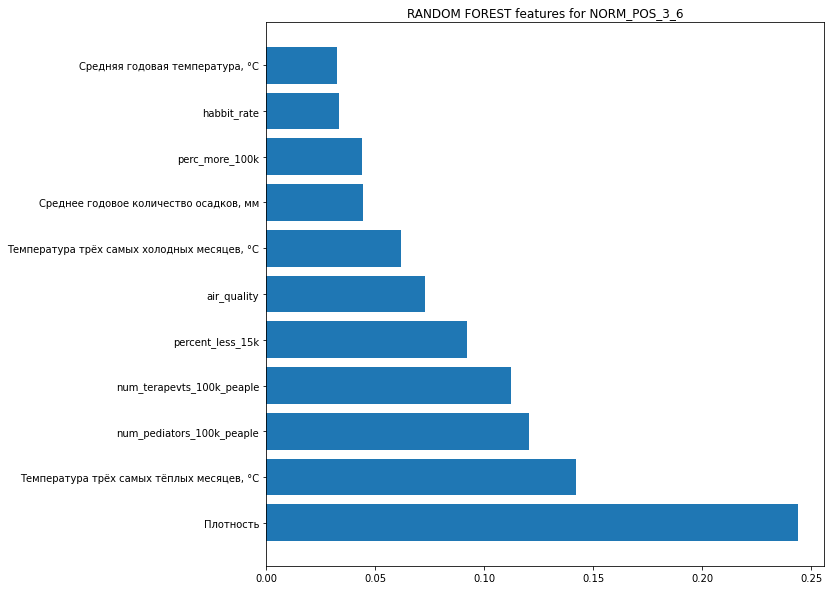

LASSO features for NORM_POS_7_14 Best CV score: -0.007476380825511419


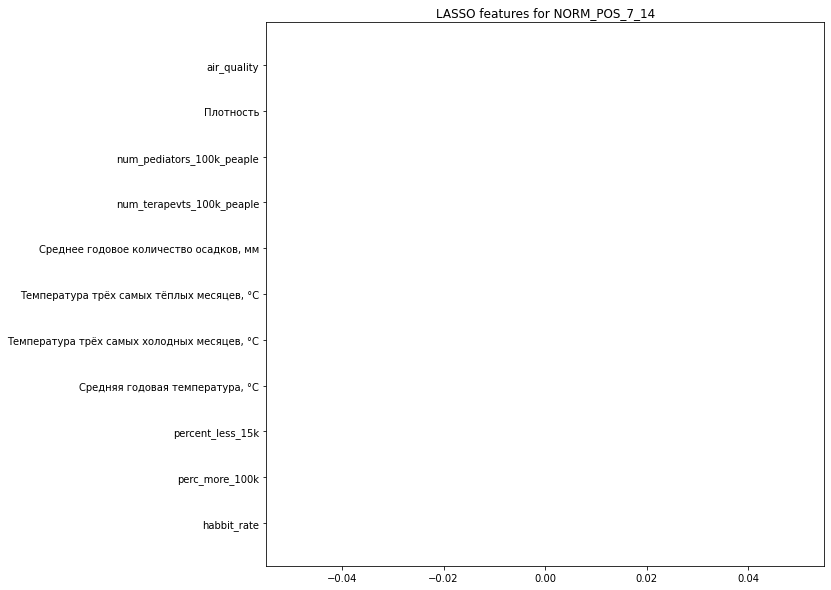

RANDOM FOREST features for NORM_POS_7_14 Best CV score: -0.009272929503402725


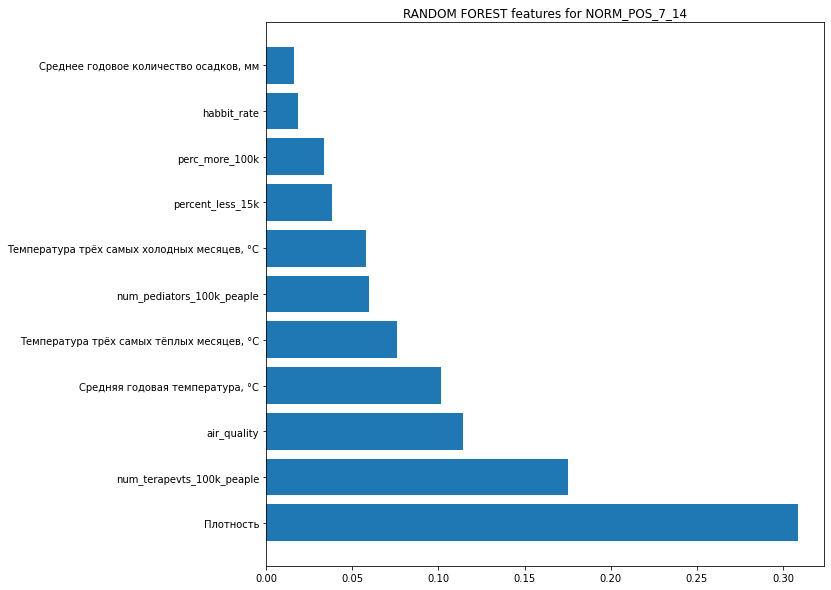

LASSO features for NORM_POS_15 Best CV score: -0.0003062006762416626


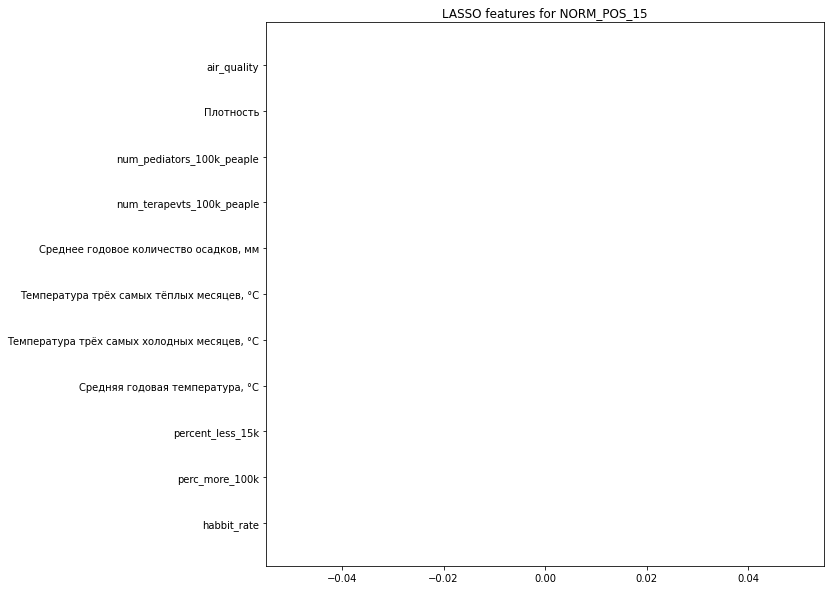

RANDOM FOREST features for NORM_POS_15 Best CV score: -0.0004022414063078889


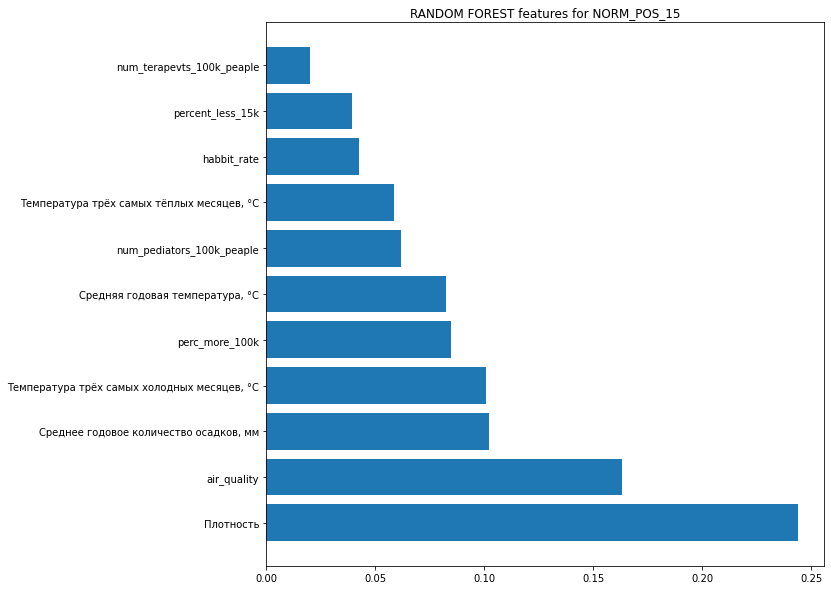

LASSO features for NORM_POS_TOTAL Best CV score: -0.0008798178657488497


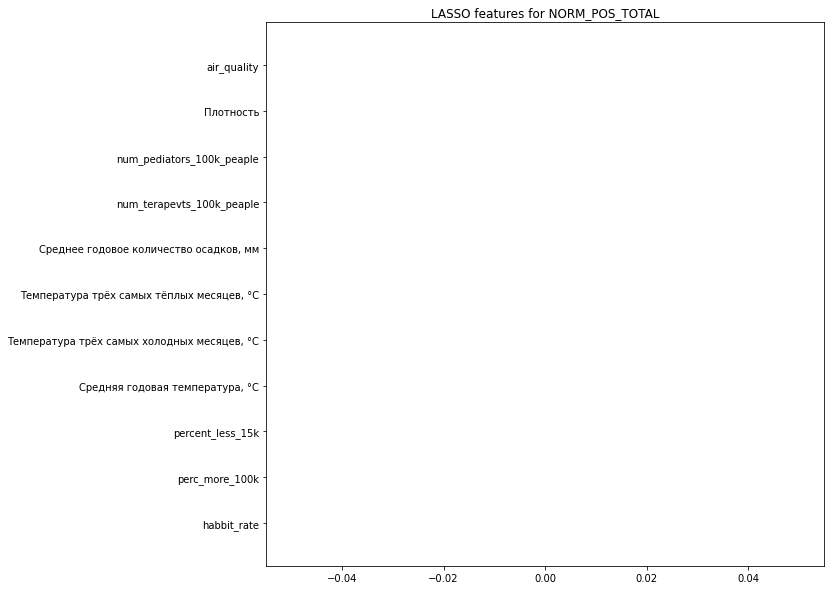

RANDOM FOREST features for NORM_POS_TOTAL Best CV score: -0.0010798429273045586


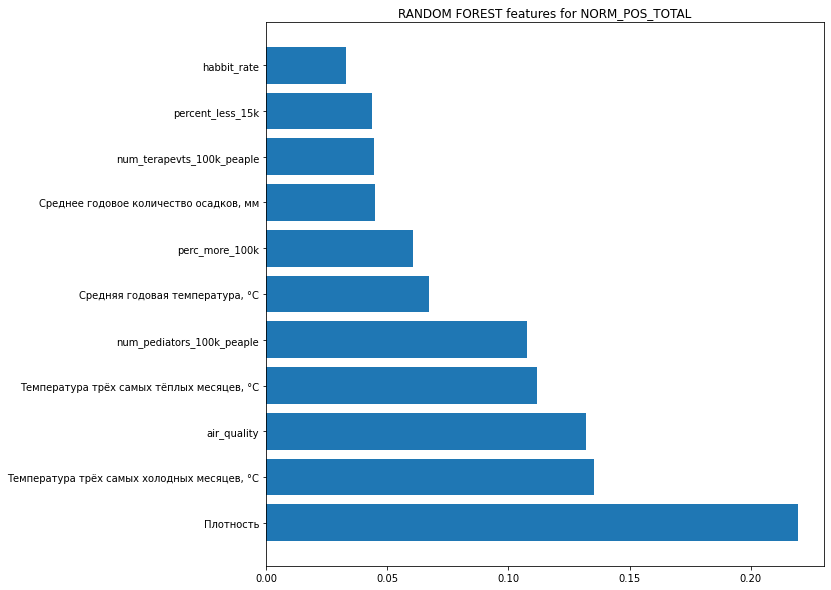

LASSO features for NORM_swba_0_2 Best CV score: -1499.7930383315681


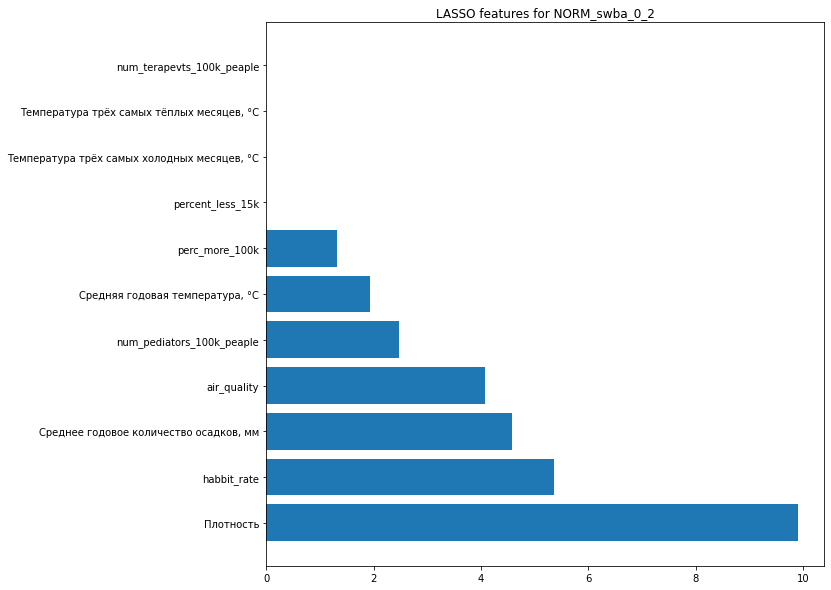

RANDOM FOREST features for NORM_swba_0_2 Best CV score: -1209.889659267314


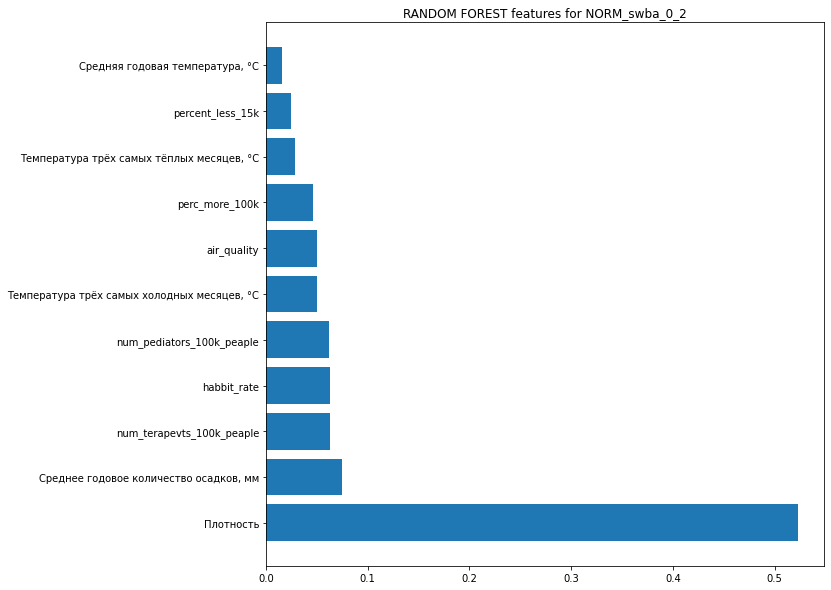

LASSO features for NORM_swba_3_6 Best CV score: -140.63338078778145


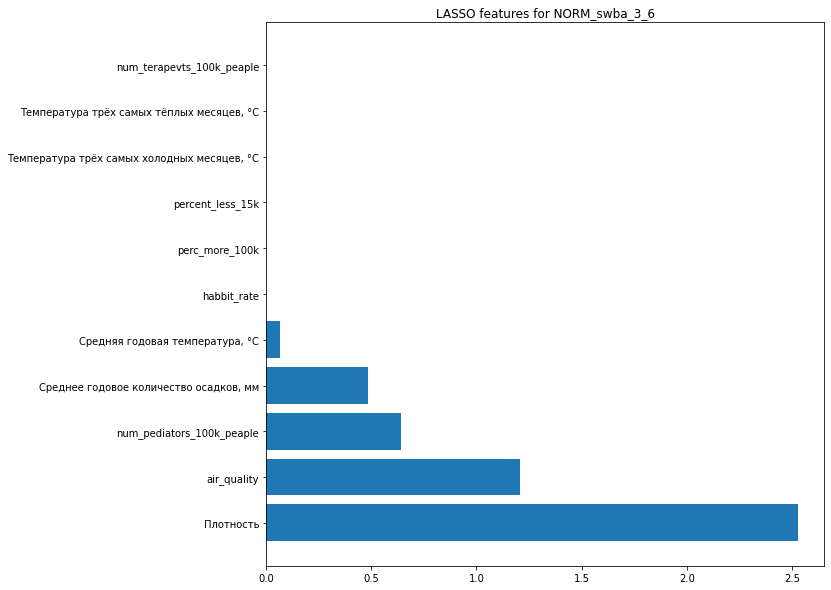

RANDOM FOREST features for NORM_swba_3_6 Best CV score: -128.6202744032633


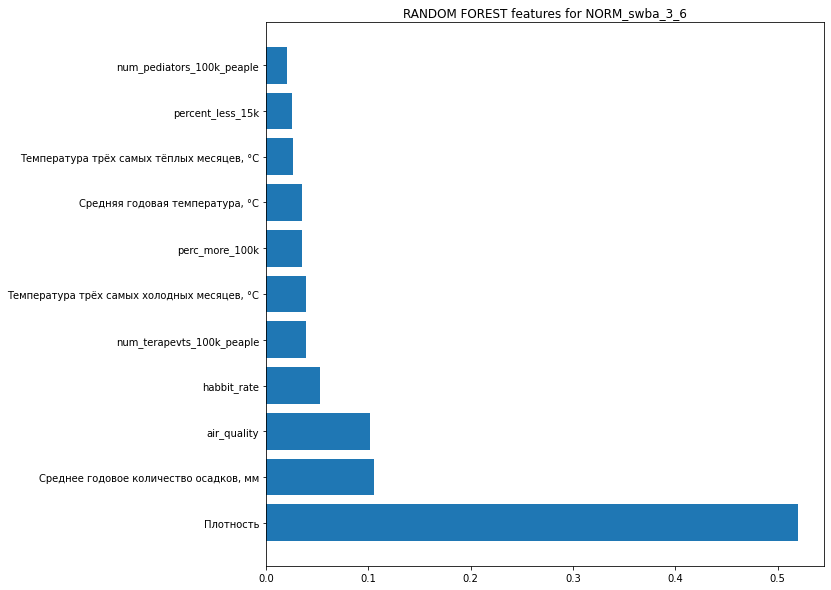

LASSO features for NORM_swba_7_14 Best CV score: -15.773402202899552


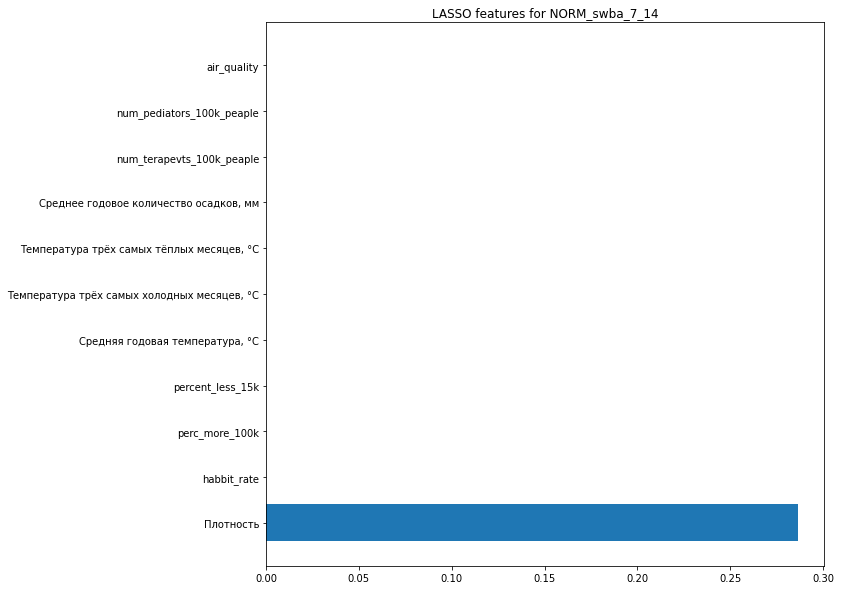

RANDOM FOREST features for NORM_swba_7_14 Best CV score: -15.809945409287769


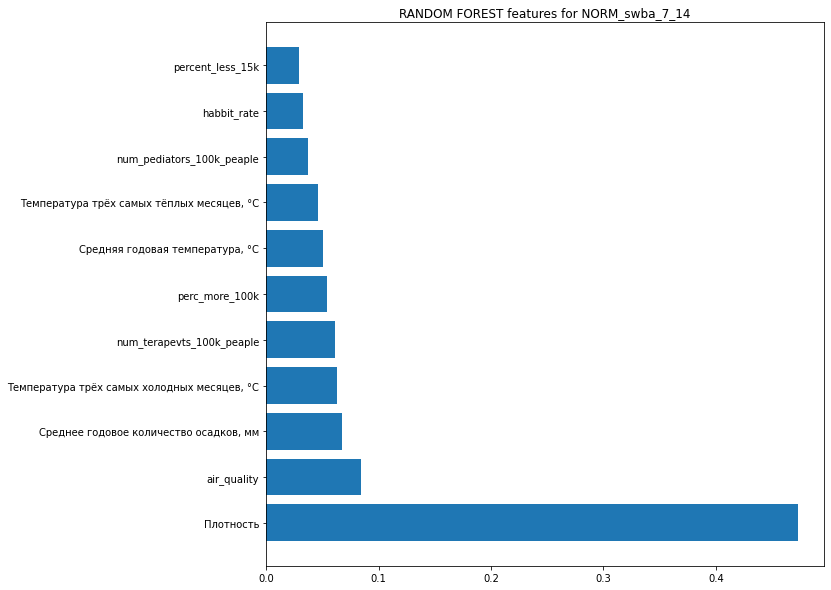

LASSO features for NORM_swba_15 Best CV score: -2.6327110389707133


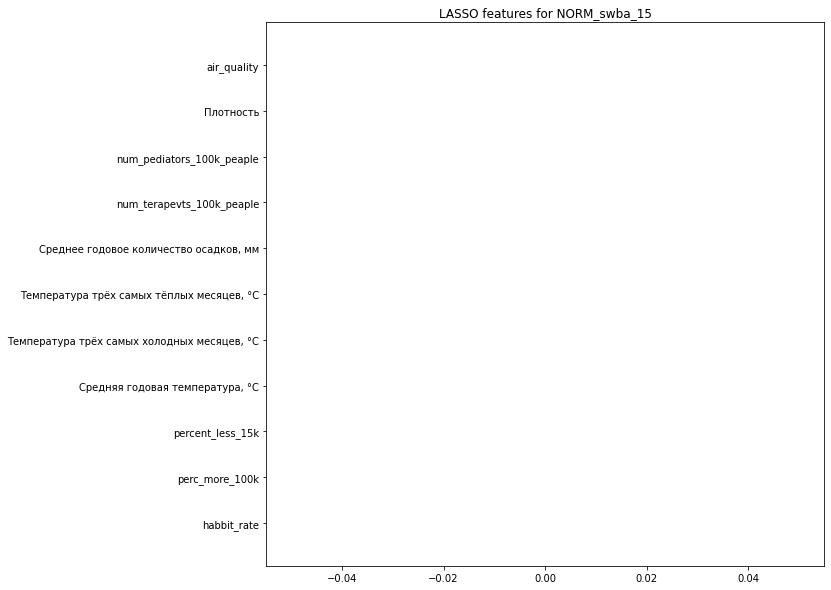

RANDOM FOREST features for NORM_swba_15 Best CV score: -3.0669194160105797


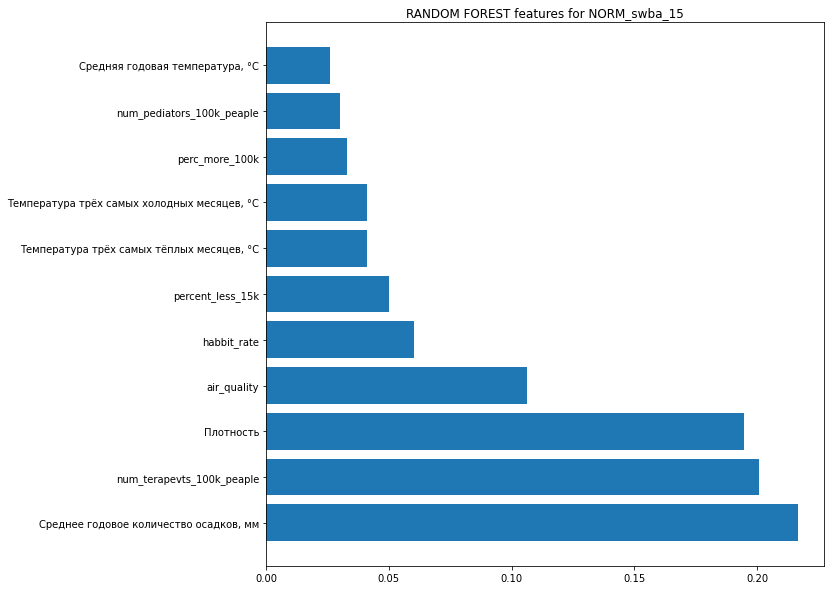

LASSO features for NORM_swba_TOTAL Best CV score: -10.84189244070132


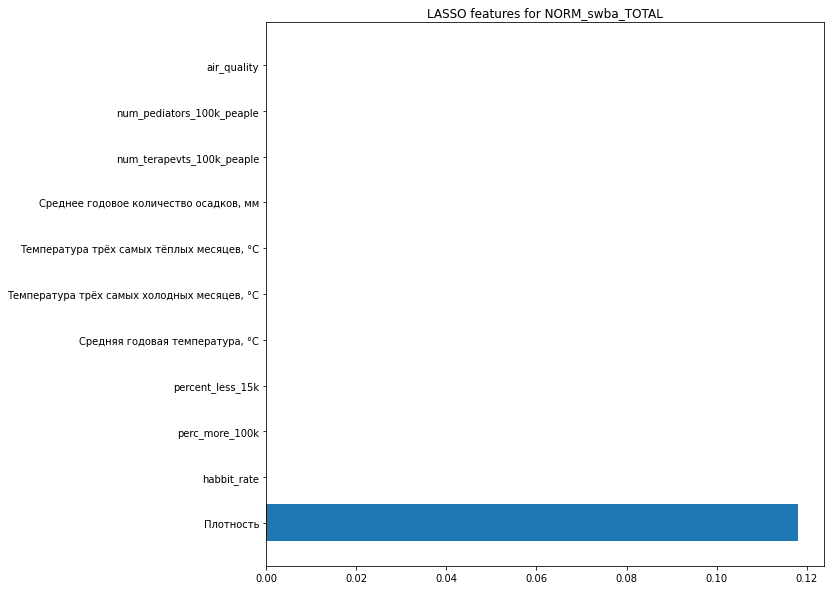

RANDOM FOREST features for NORM_swba_TOTAL Best CV score: -10.402852402938802


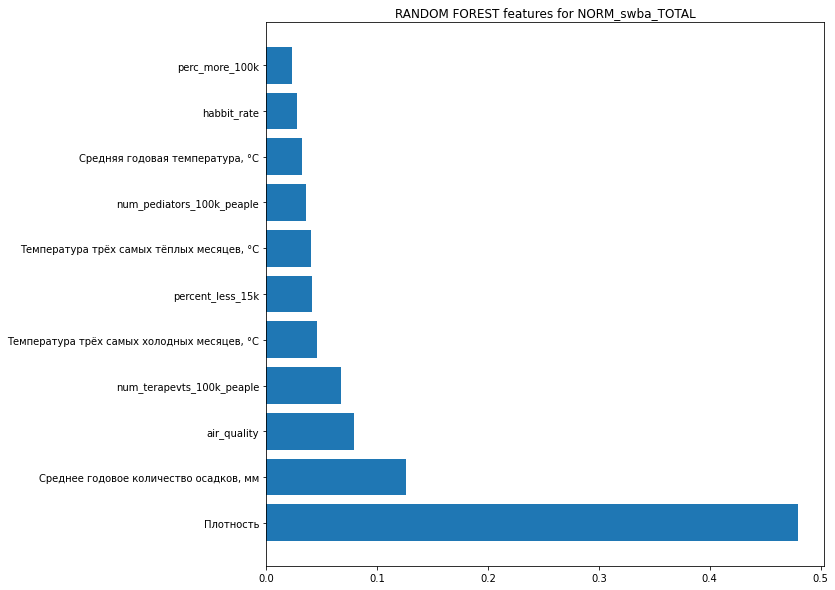

LASSO features for NORM_posa_0_2 Best CV score: -363.0848007530326


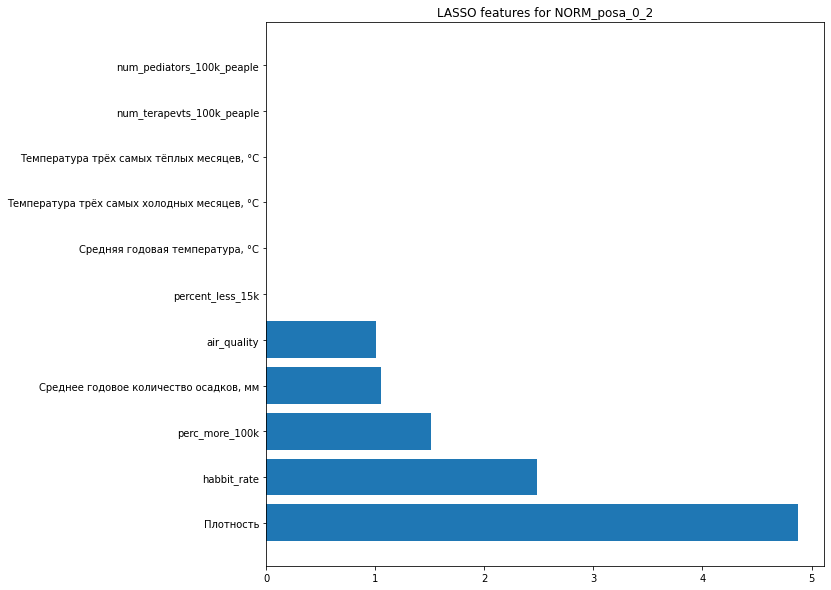

RANDOM FOREST features for NORM_posa_0_2 Best CV score: -318.9293631113305


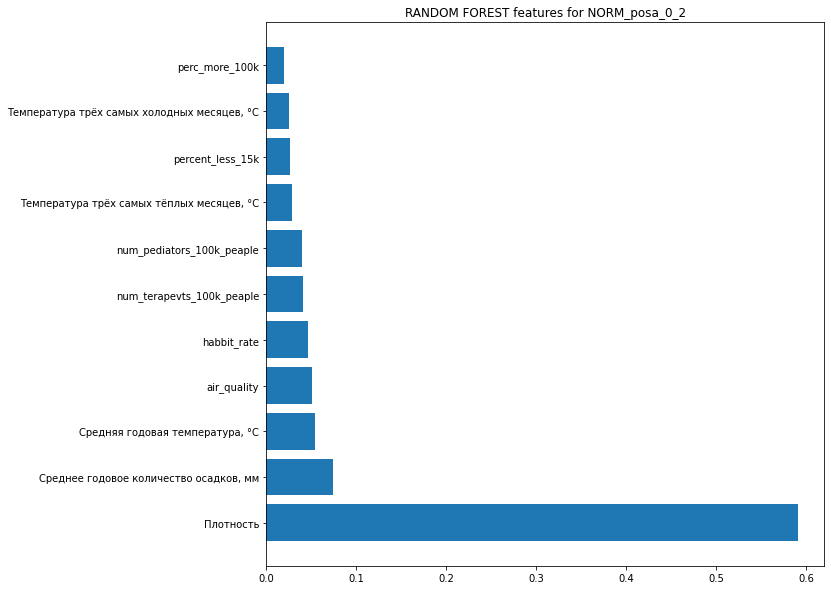

LASSO features for NORM_posa_3_6 Best CV score: -26.78730375621931


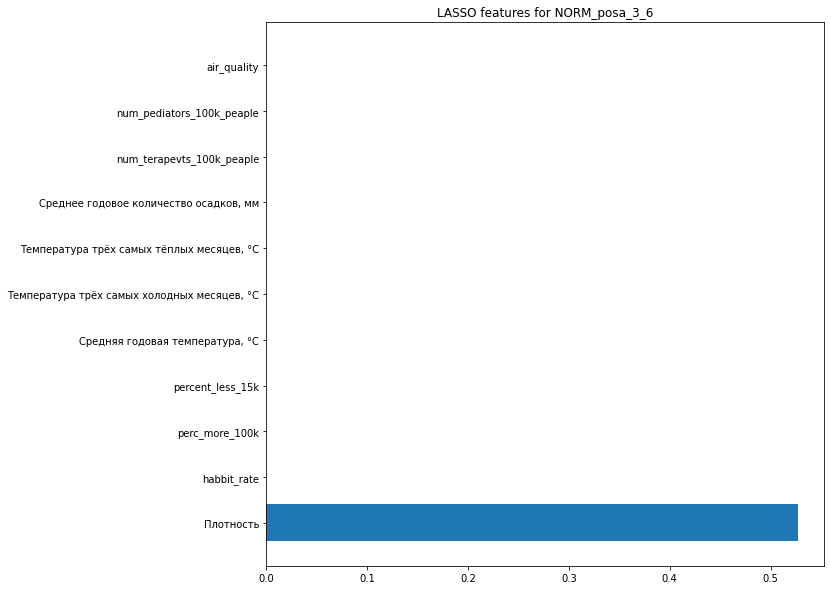

RANDOM FOREST features for NORM_posa_3_6 Best CV score: -24.63217017038503


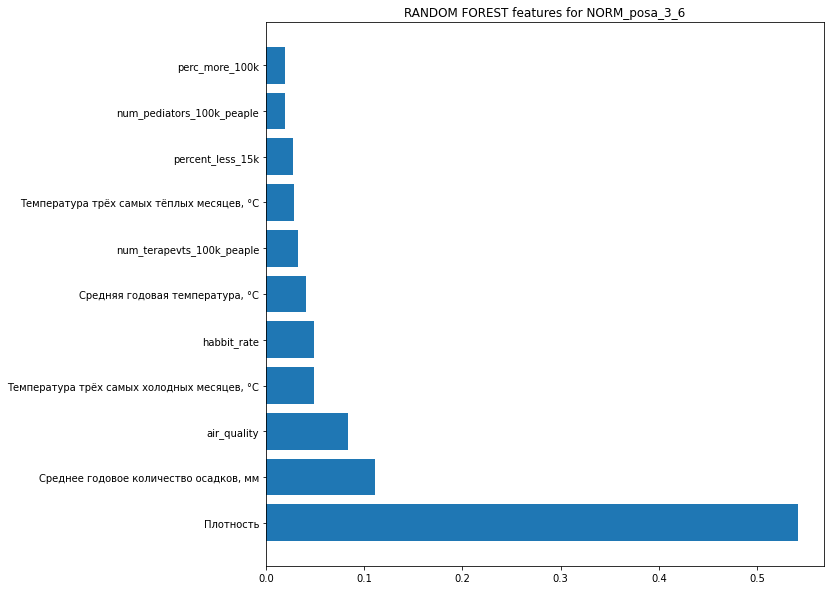

LASSO features for NORM_posa_7_14 Best CV score: -1.2257155633671069


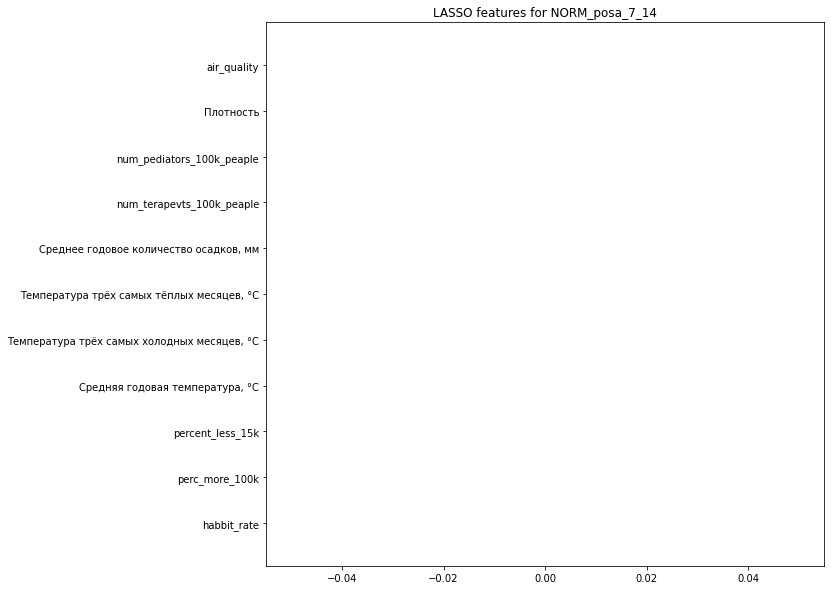

RANDOM FOREST features for NORM_posa_7_14 Best CV score: -1.2071170185857718


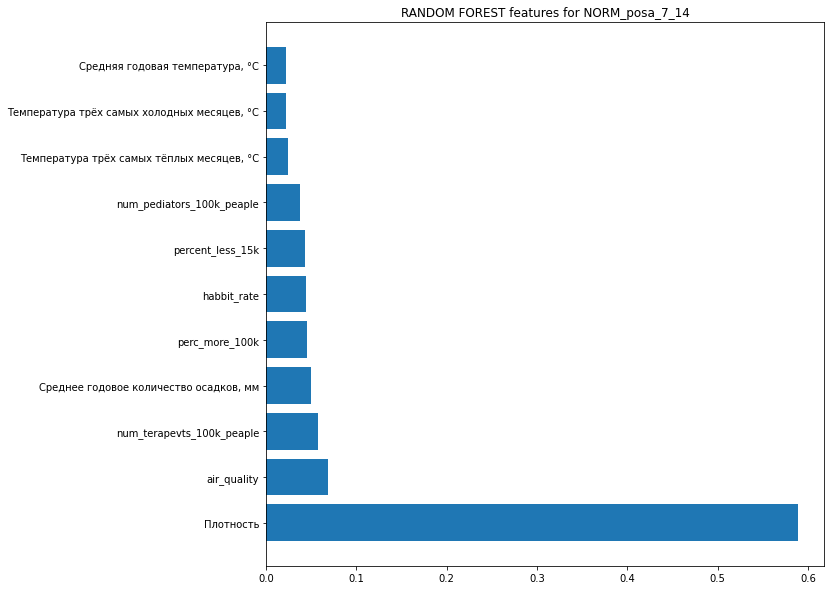

LASSO features for NORM_posa_15 Best CV score: -0.09009069584592248


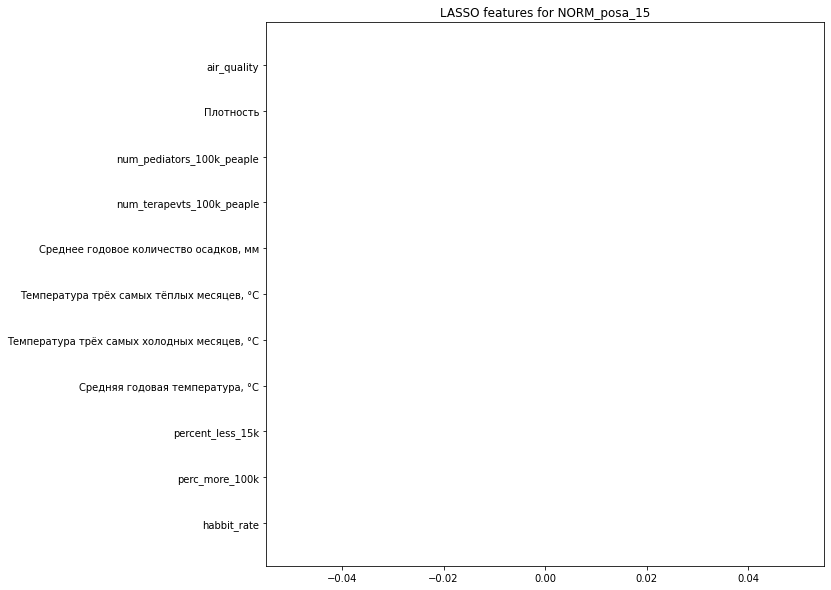

RANDOM FOREST features for NORM_posa_15 Best CV score: -0.08346449098094963


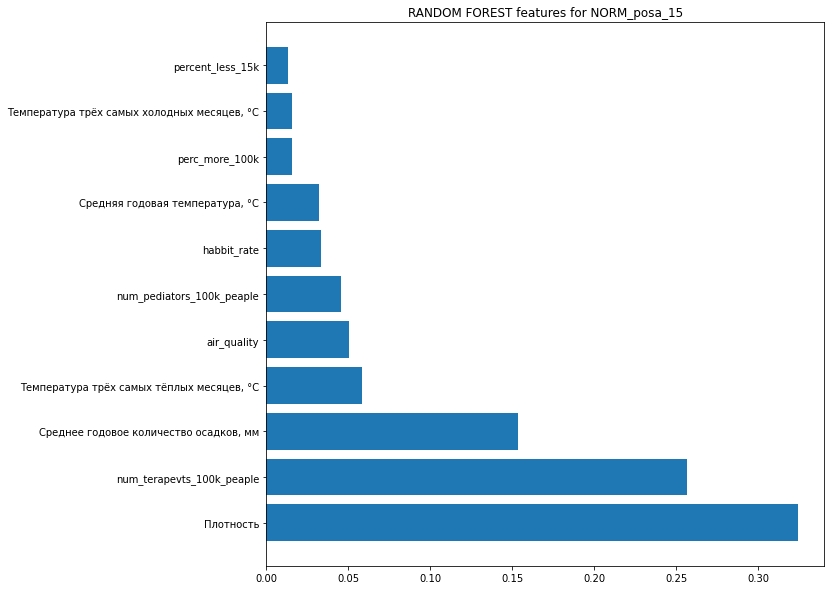

LASSO features for NORM_posa_TOTAL Best CV score: -1.3965469164003228


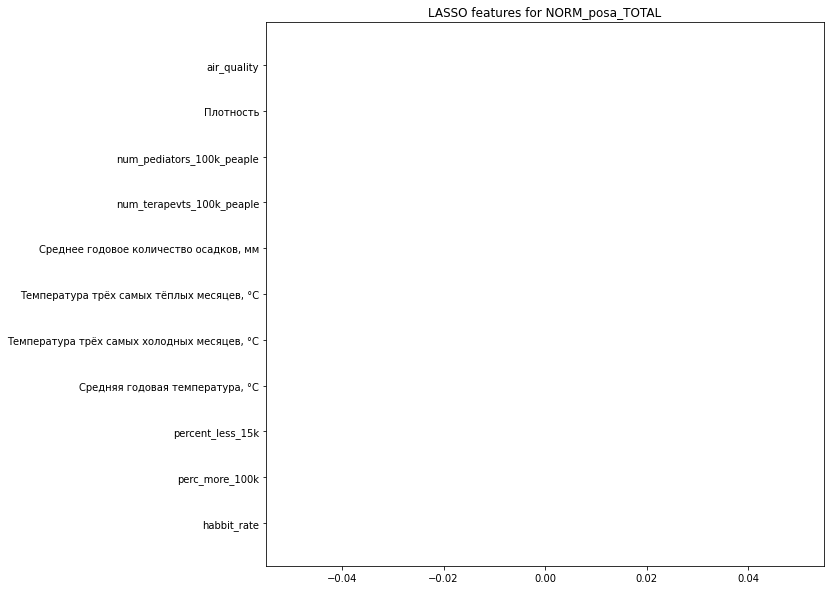

RANDOM FOREST features for NORM_posa_TOTAL Best CV score: -1.250472707750672


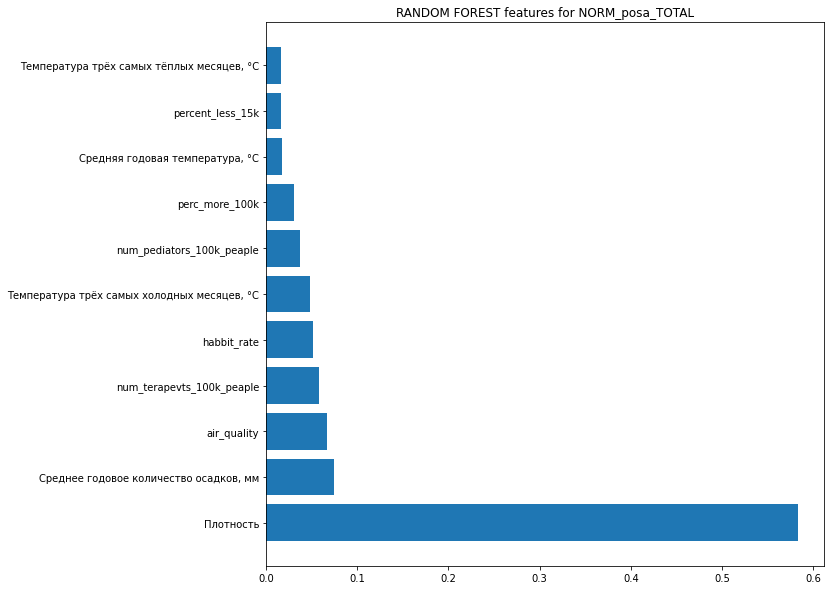

In [36]:
all_targets = [tg for tg in targets.columns if tg != 'DISTRICT_NAME']

for tg in all_targets:
    plot_feature_importances(linear_model.Lasso(max_iter=10_000), merged, tg, title=f'LASSO features for {tg}', scale=True)
    plot_feature_importances(RandomForestRegressor(), merged, tg, title=f'RANDOM FOREST features for {tg}')

Модели, обученные на уровне по колонке `NORM_ILI_...` ожидаемо не дали полезного результата, так как целевая метрика примерно равна 0. Исключаем их.

LASSO features for NORM_ARI_0_2 Best CV score: -995219.2682422822


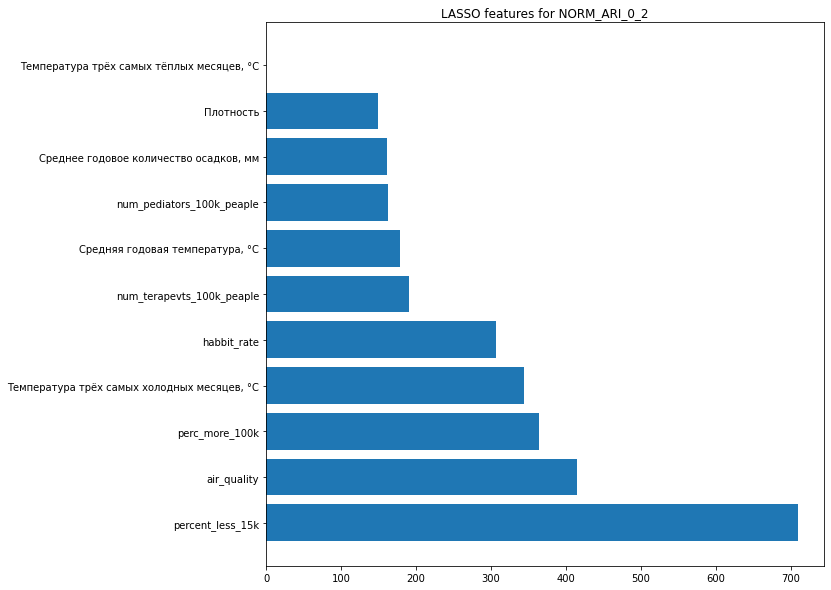

RANDOM FOREST features for NORM_ARI_0_2 Best CV score: -1043945.4419331308


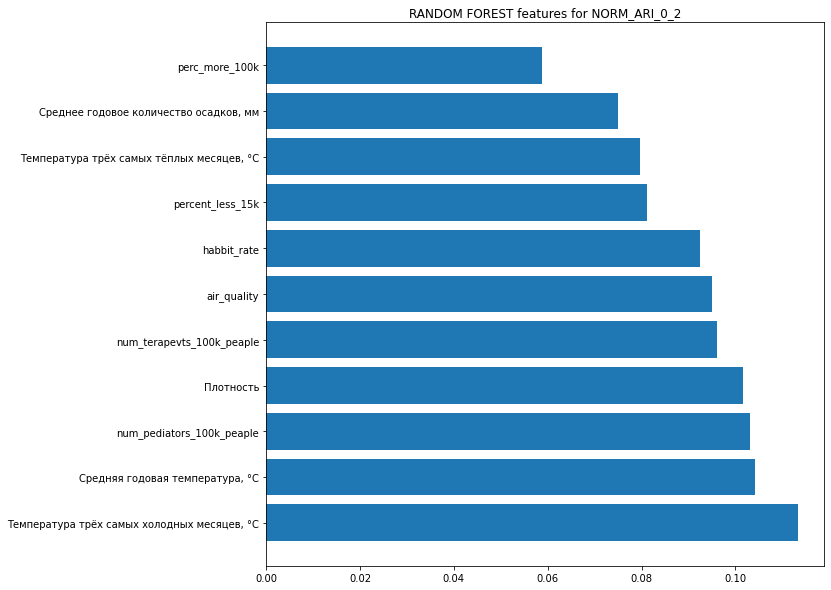

LASSO features for NORM_ARI_3_6 Best CV score: -613560.0552068944


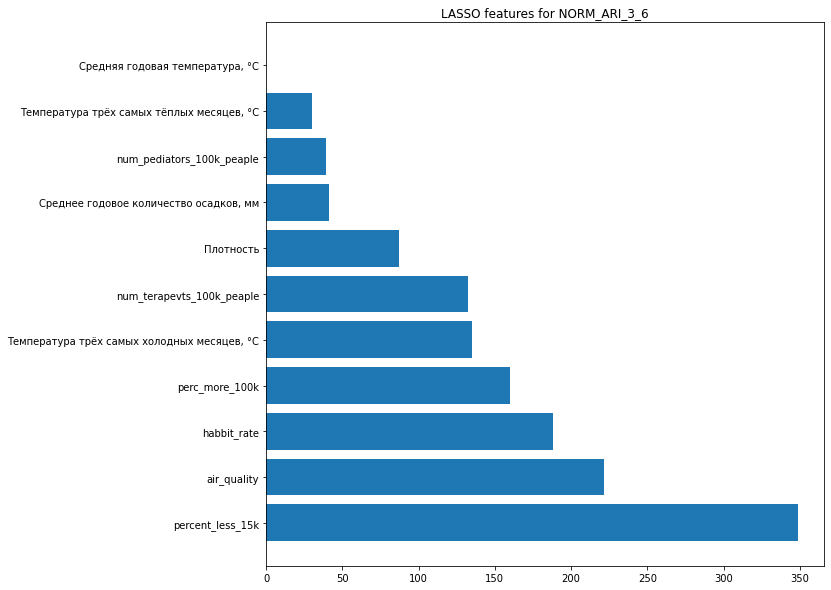

RANDOM FOREST features for NORM_ARI_3_6 Best CV score: -529145.9060687514


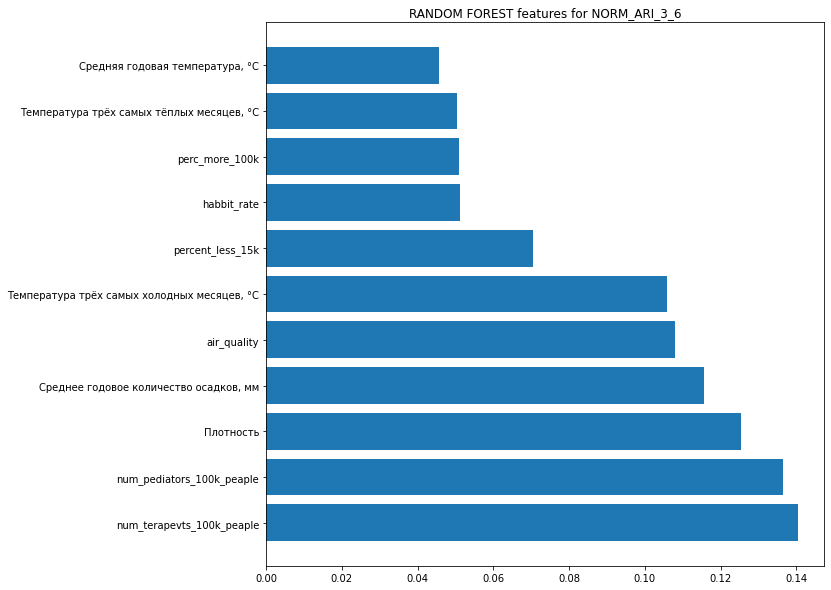

LASSO features for NORM_ARI_7_14 Best CV score: -27894.93463268056


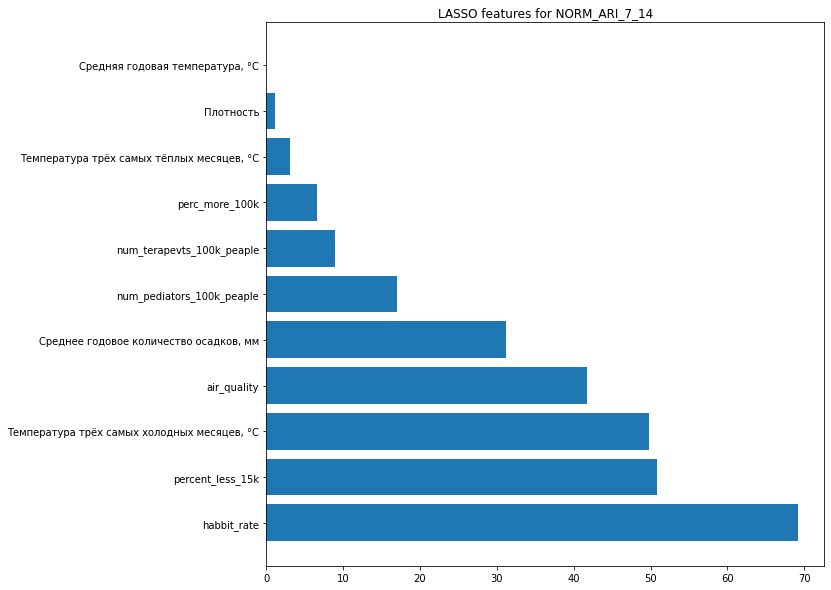

RANDOM FOREST features for NORM_ARI_7_14 Best CV score: -22301.40334455489


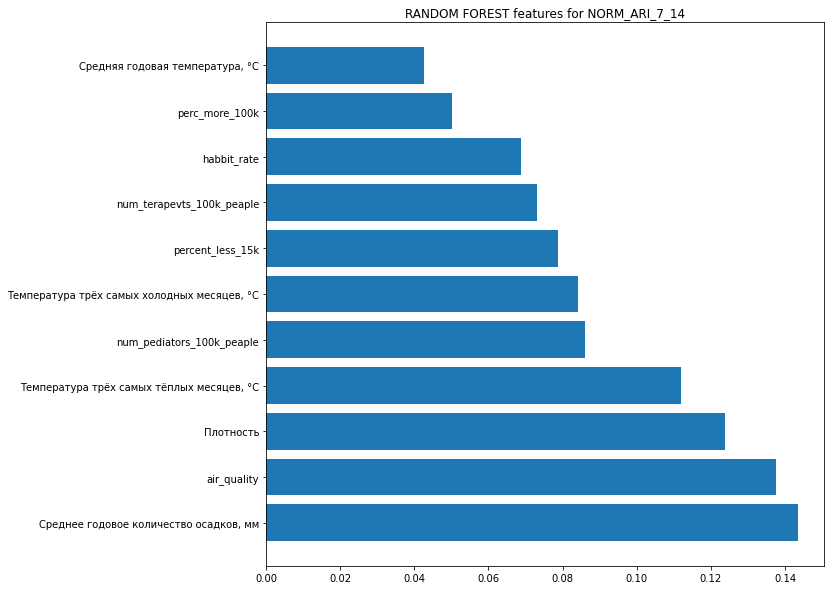

LASSO features for NORM_ARI_15 Best CV score: -2109.4113067108983


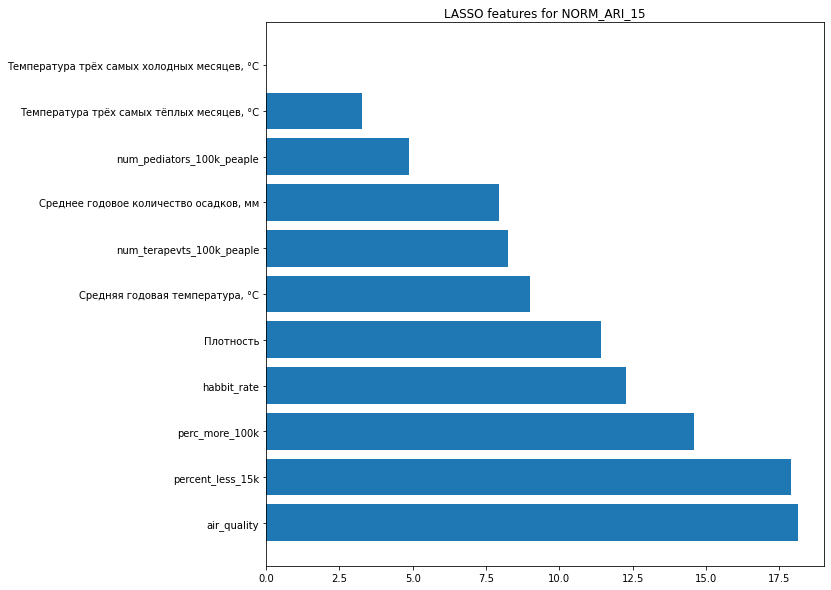

RANDOM FOREST features for NORM_ARI_15 Best CV score: -2212.082139815463


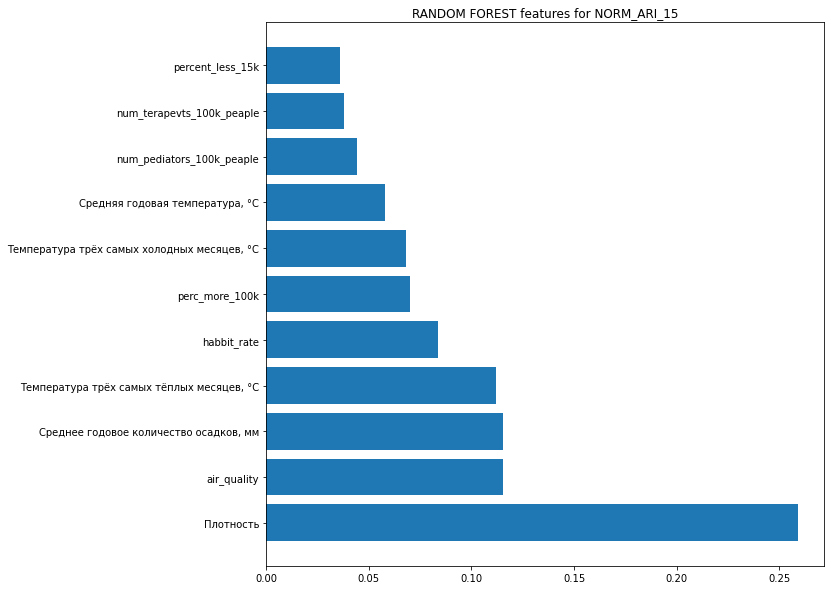

LASSO features for NORM_ARI_TOTAL Best CV score: -10267.168862190196


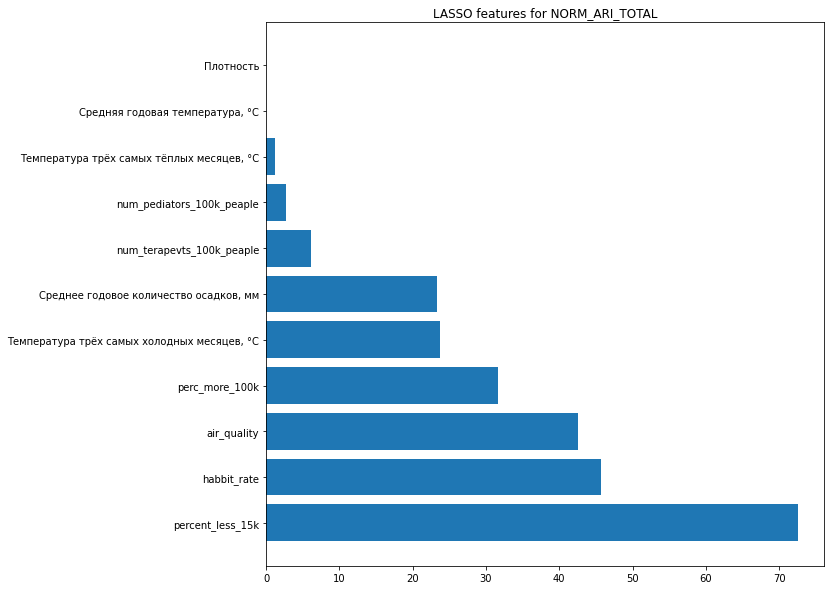

RANDOM FOREST features for NORM_ARI_TOTAL Best CV score: -10822.08957119639


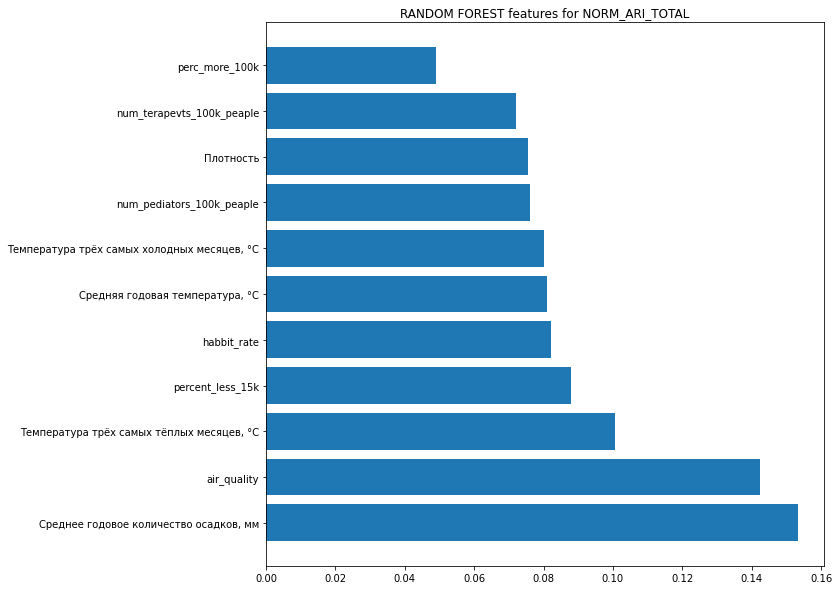

LASSO features for NORM_SWB_0_2 Best CV score: -1587.8041486994073


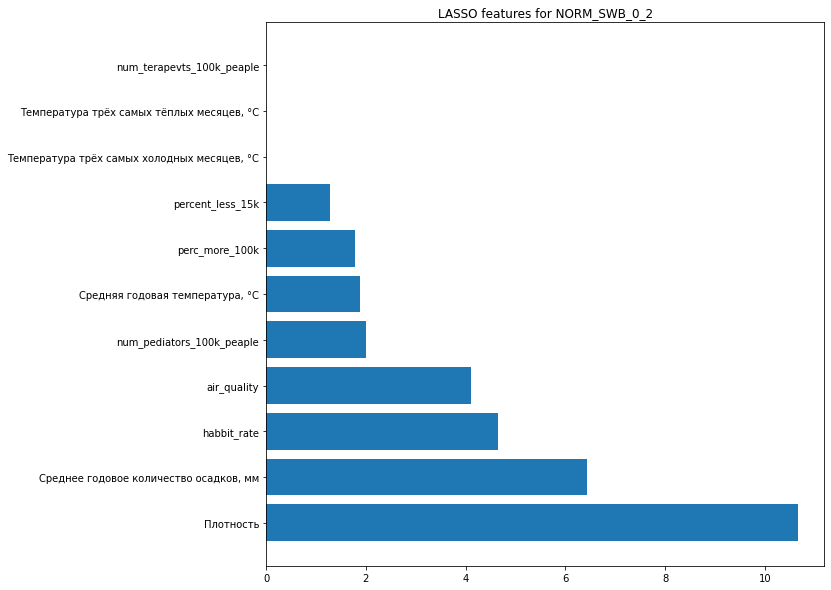

RANDOM FOREST features for NORM_SWB_0_2 Best CV score: -1356.0528109322418


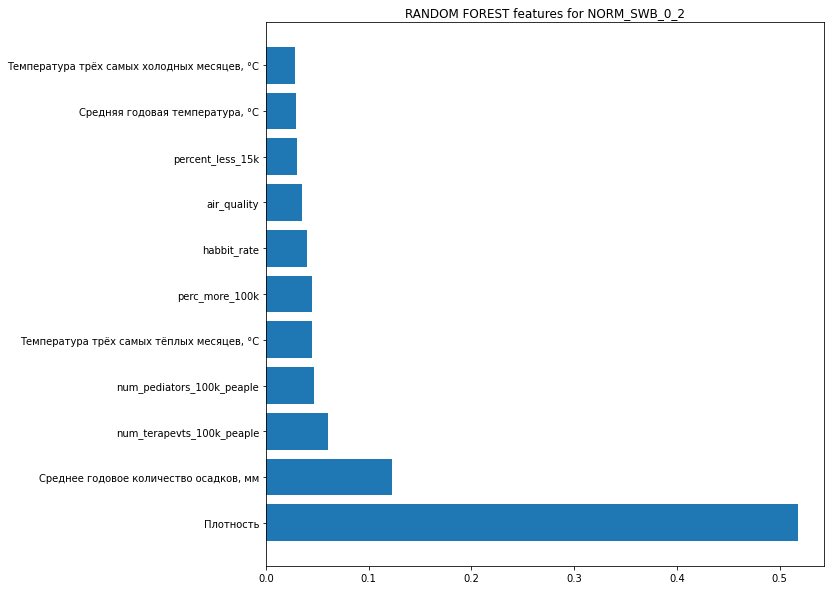

LASSO features for NORM_SWB_3_6 Best CV score: -147.60063158895417


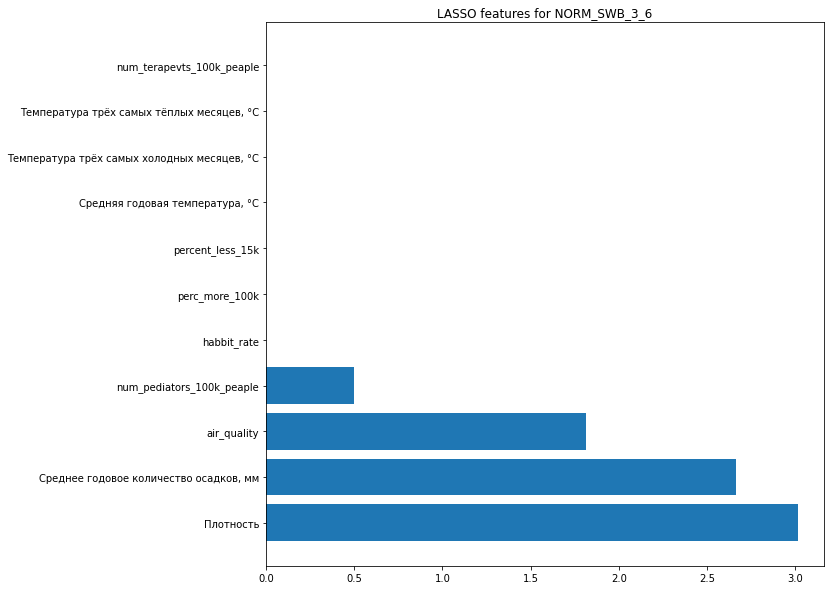

RANDOM FOREST features for NORM_SWB_3_6 Best CV score: -128.43987595044769


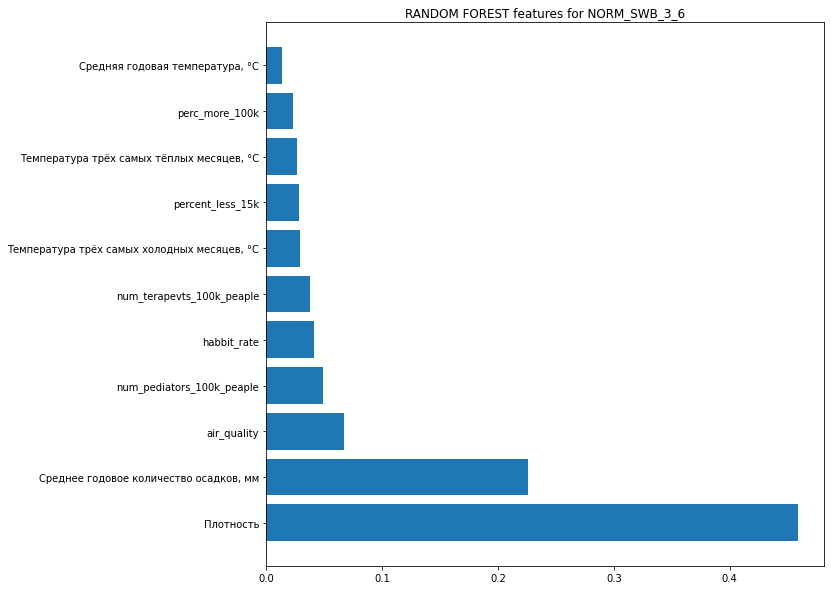

LASSO features for NORM_SWB_7_14 Best CV score: -17.699916454790884


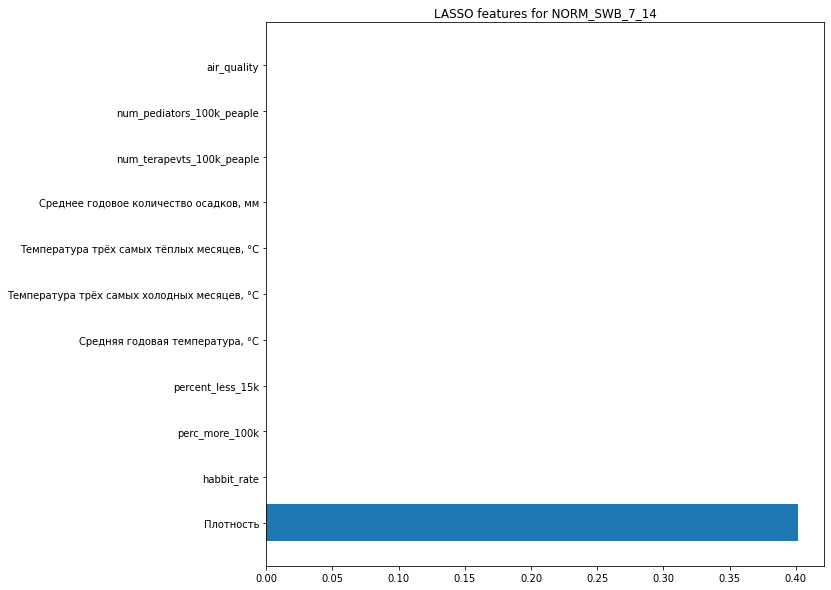

RANDOM FOREST features for NORM_SWB_7_14 Best CV score: -14.995468568499149


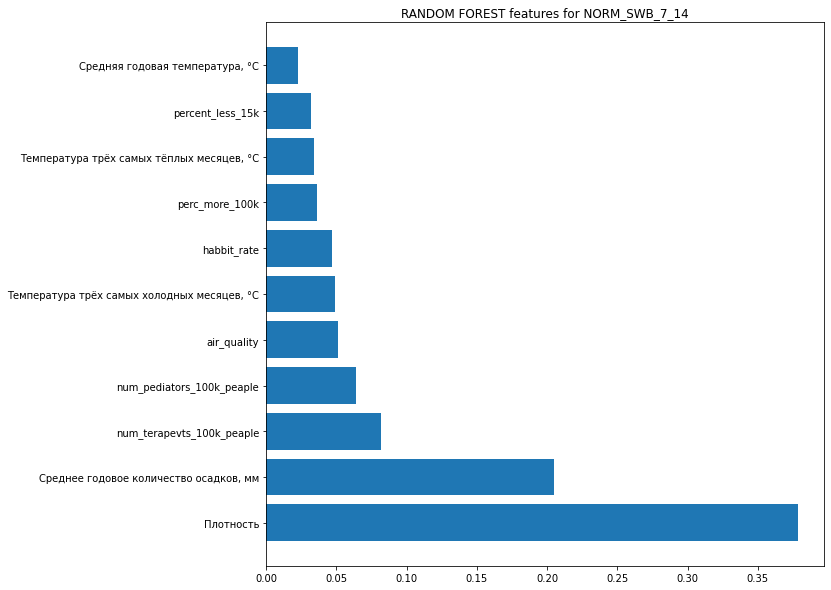

LASSO features for NORM_SWB_15 Best CV score: -3.34643558816159


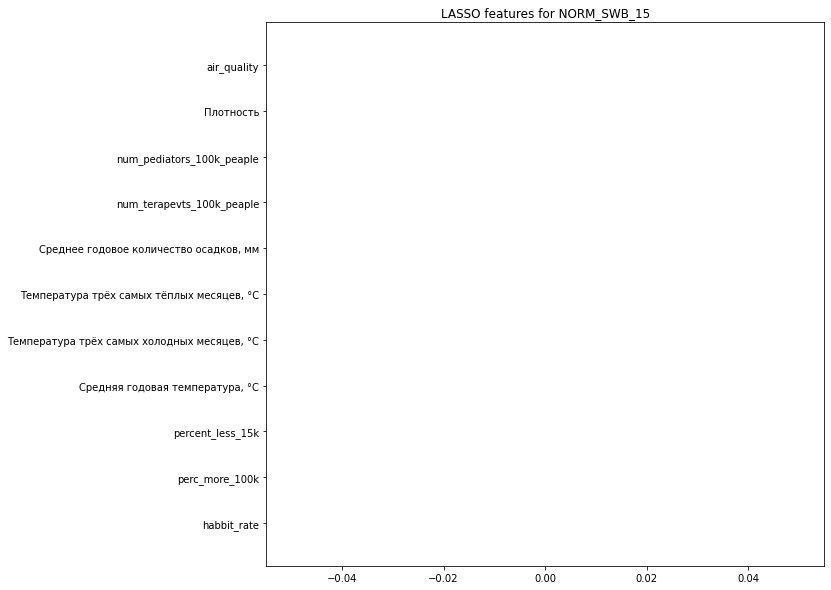

RANDOM FOREST features for NORM_SWB_15 Best CV score: -3.5769705624920034


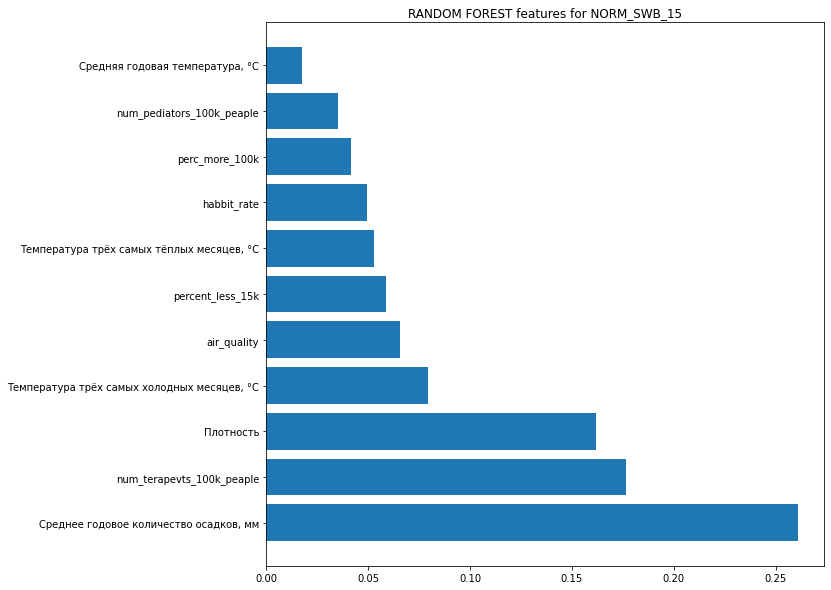

LASSO features for NORM_SWB_TOTAL Best CV score: -11.30478603588998


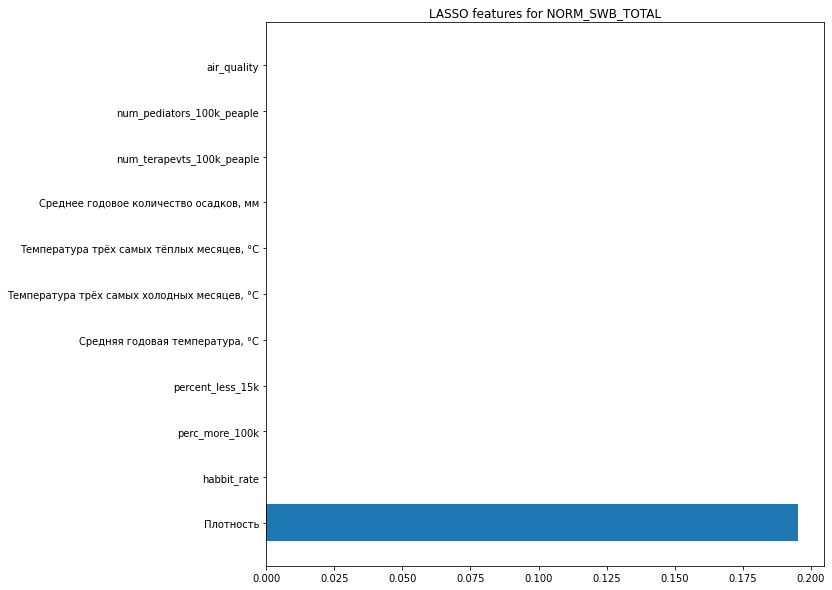

RANDOM FOREST features for NORM_SWB_TOTAL Best CV score: -10.108333313508954


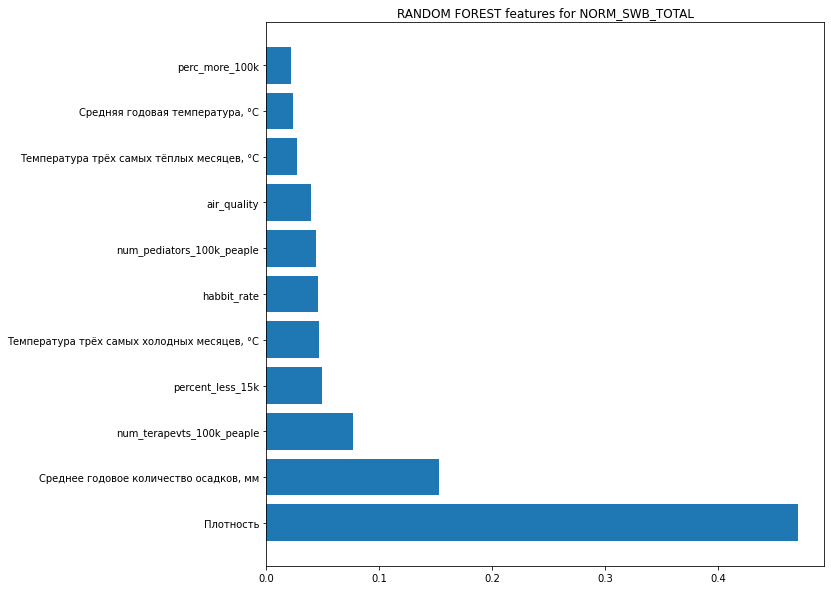

LASSO features for NORM_POS_0_2 Best CV score: -0.03705708722349106


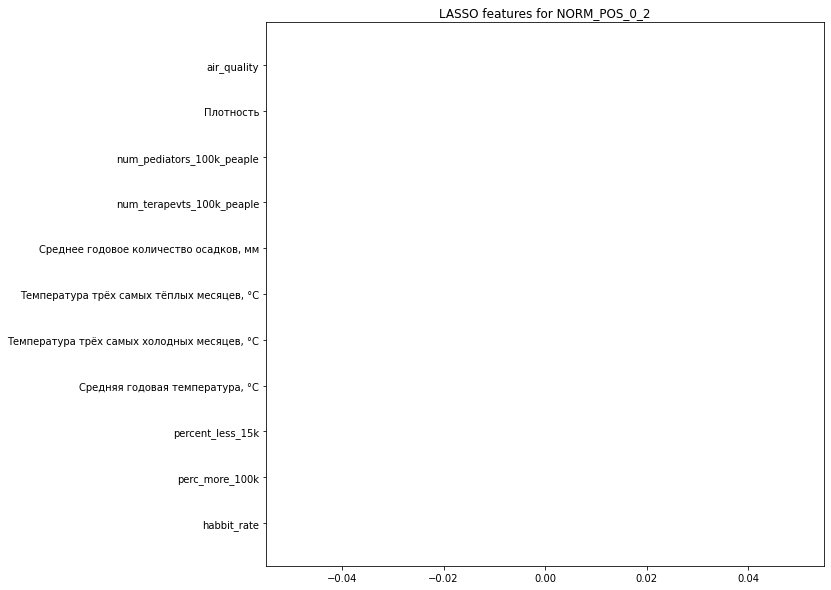

RANDOM FOREST features for NORM_POS_0_2 Best CV score: -0.04959407303717978


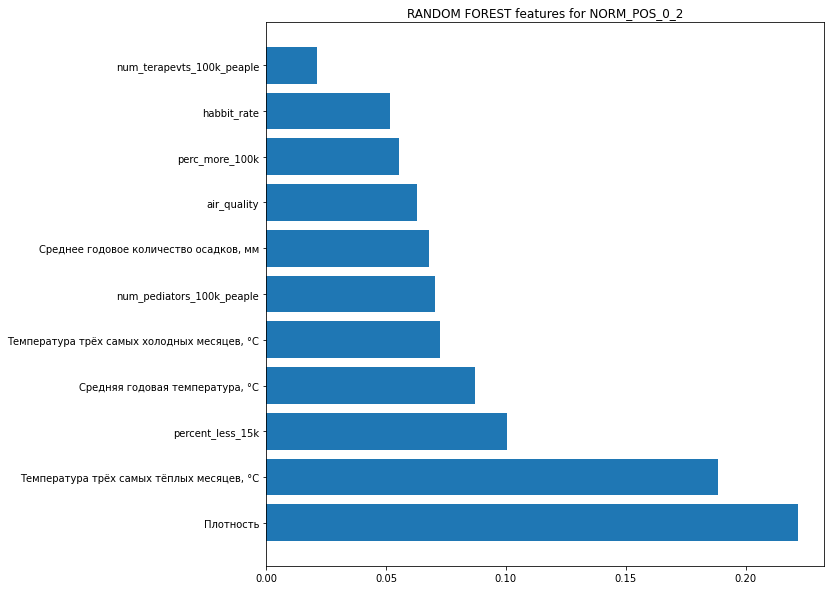

LASSO features for NORM_POS_3_6 Best CV score: -0.016772426921976585


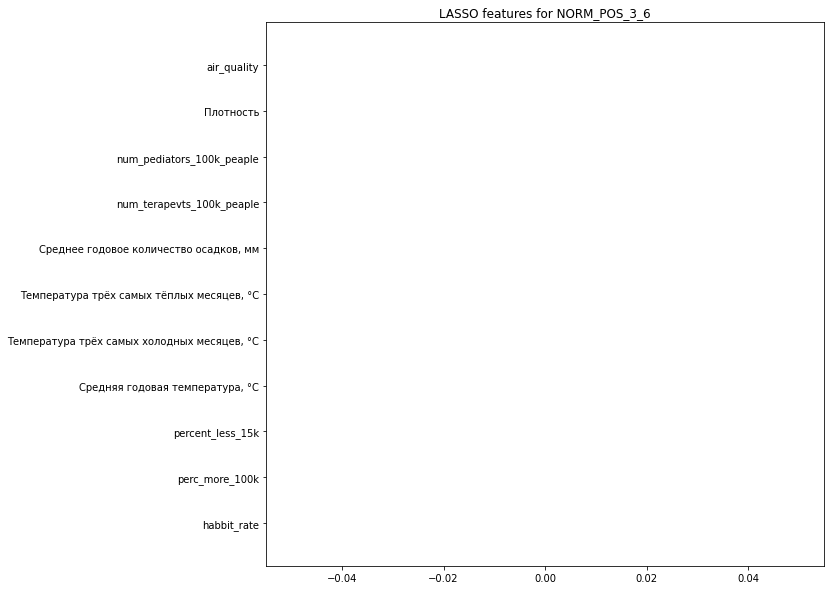

RANDOM FOREST features for NORM_POS_3_6 Best CV score: -0.025273233726530064


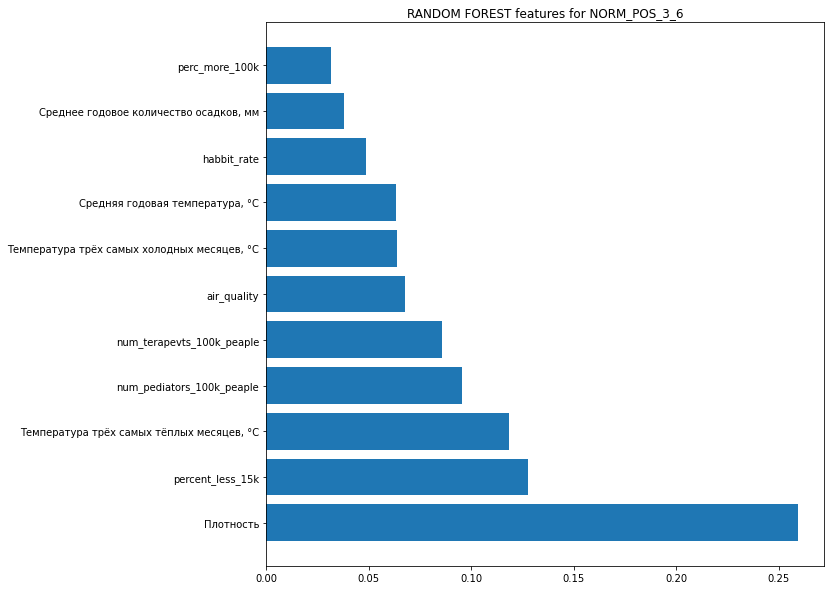

LASSO features for NORM_POS_7_14 Best CV score: -0.007476380825511419


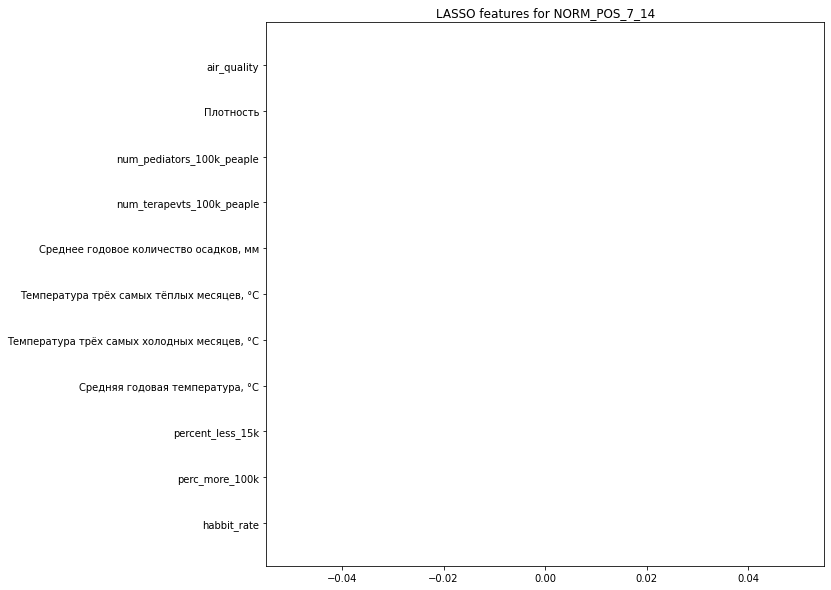

RANDOM FOREST features for NORM_POS_7_14 Best CV score: -0.00910385654178117


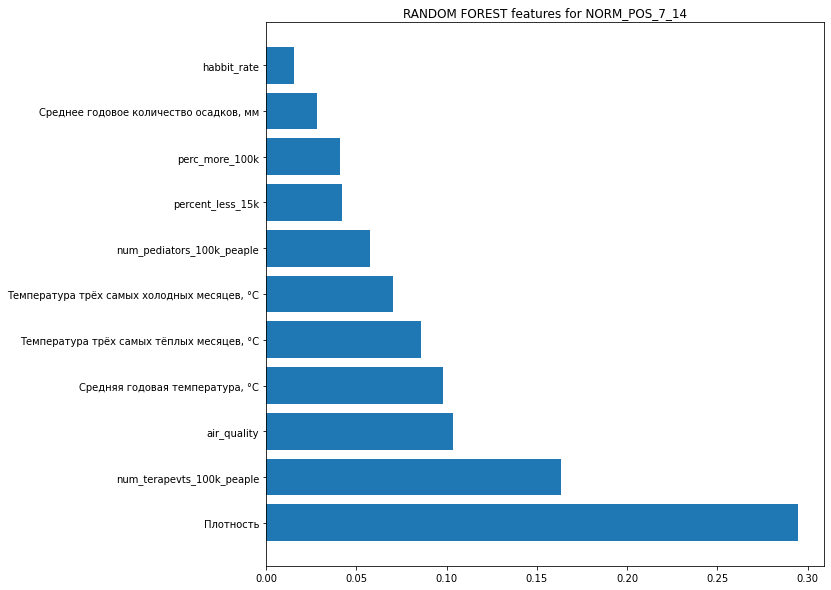

LASSO features for NORM_POS_15 Best CV score: -0.0003062006762416626


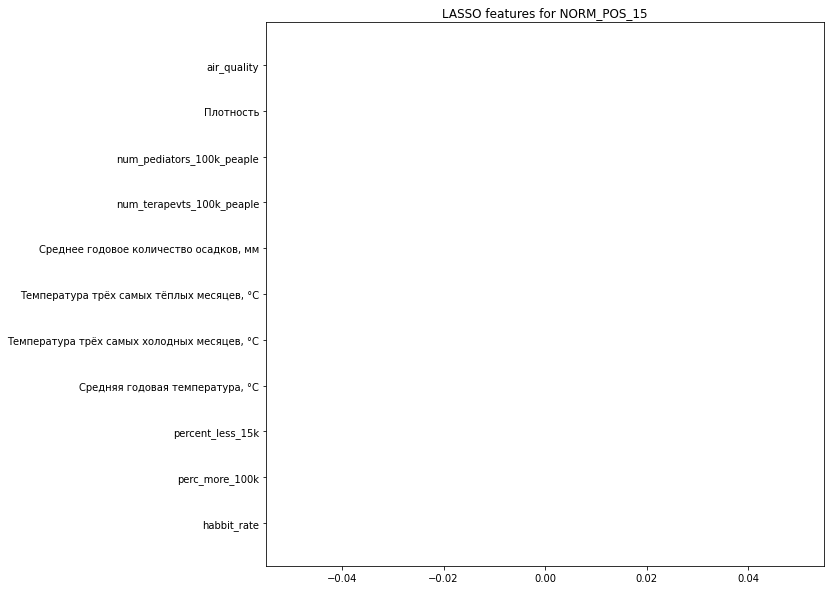

RANDOM FOREST features for NORM_POS_15 Best CV score: -0.0003933246834196408


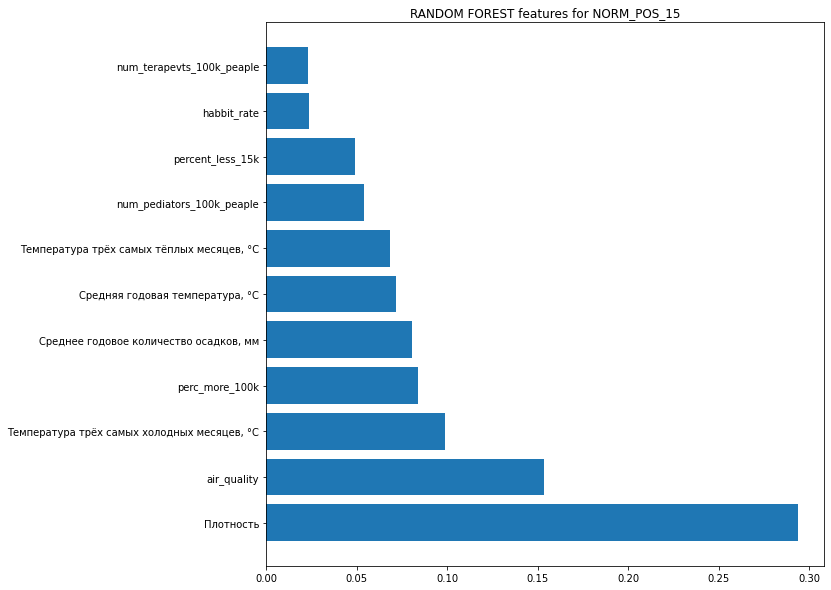

LASSO features for NORM_POS_TOTAL Best CV score: -0.0008798178657488497


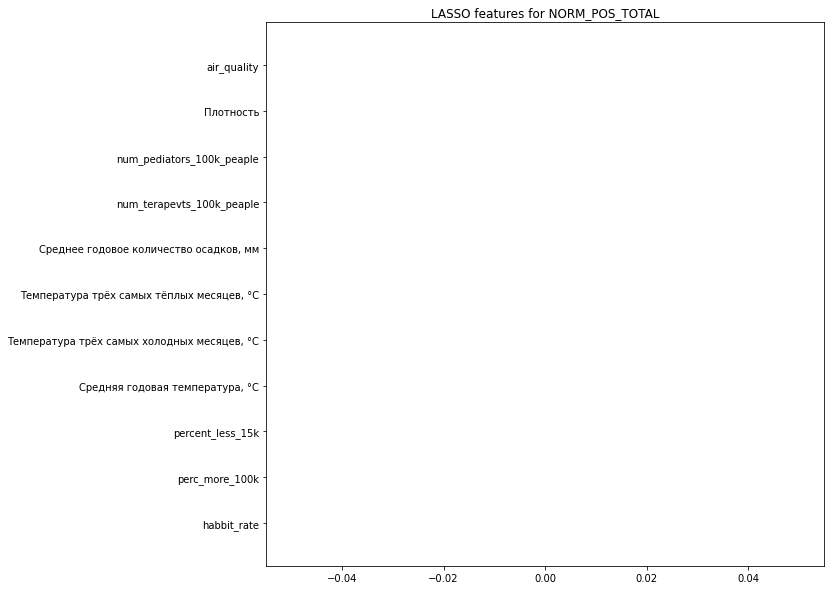

RANDOM FOREST features for NORM_POS_TOTAL Best CV score: -0.0010829003631937604


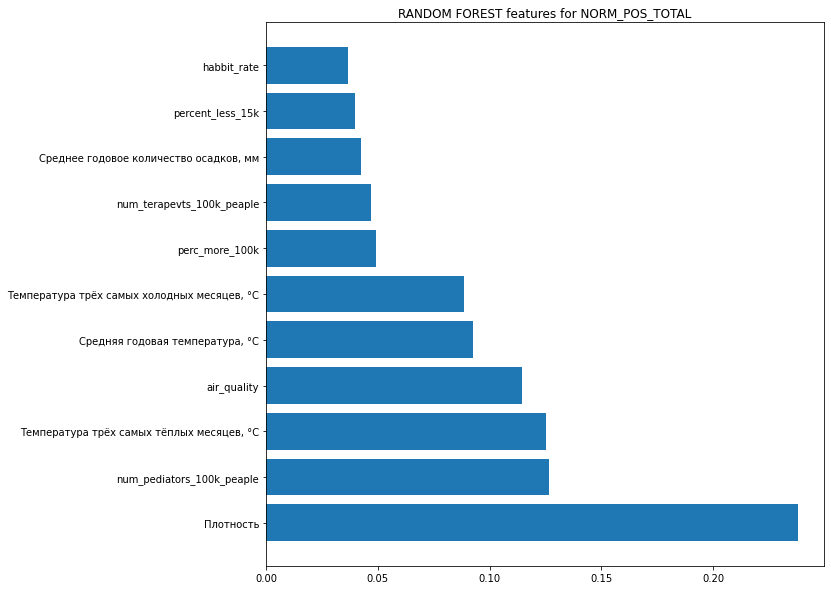

LASSO features for NORM_swba_0_2 Best CV score: -1499.7930383315681


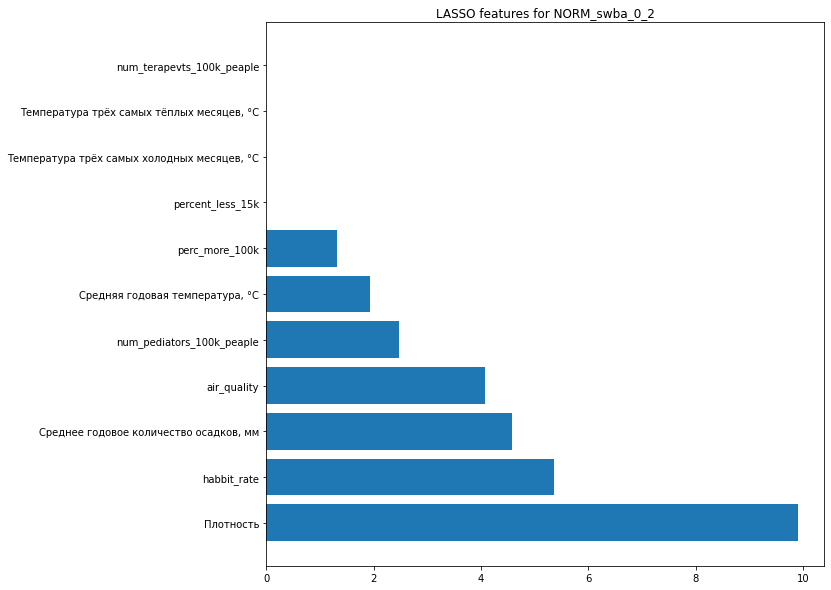

RANDOM FOREST features for NORM_swba_0_2 Best CV score: -1235.4780411336556


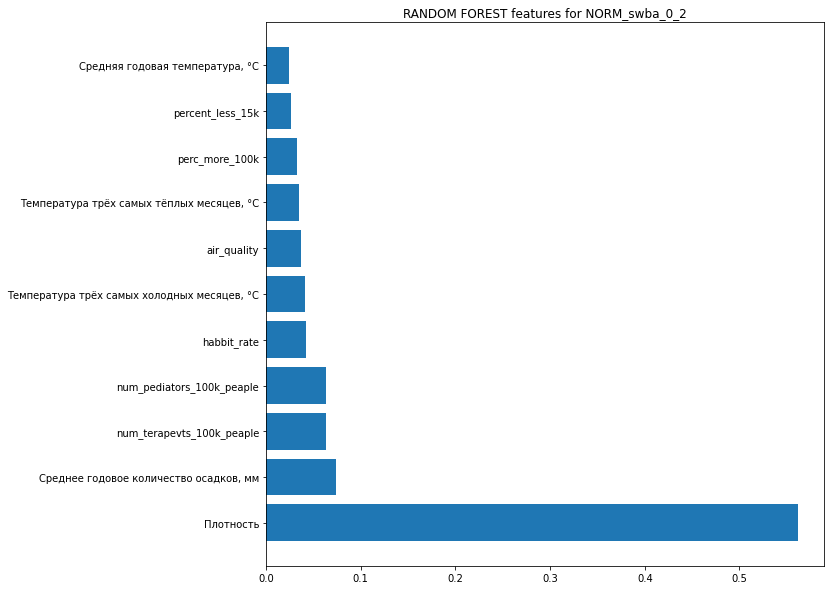

LASSO features for NORM_swba_3_6 Best CV score: -140.63338078778145


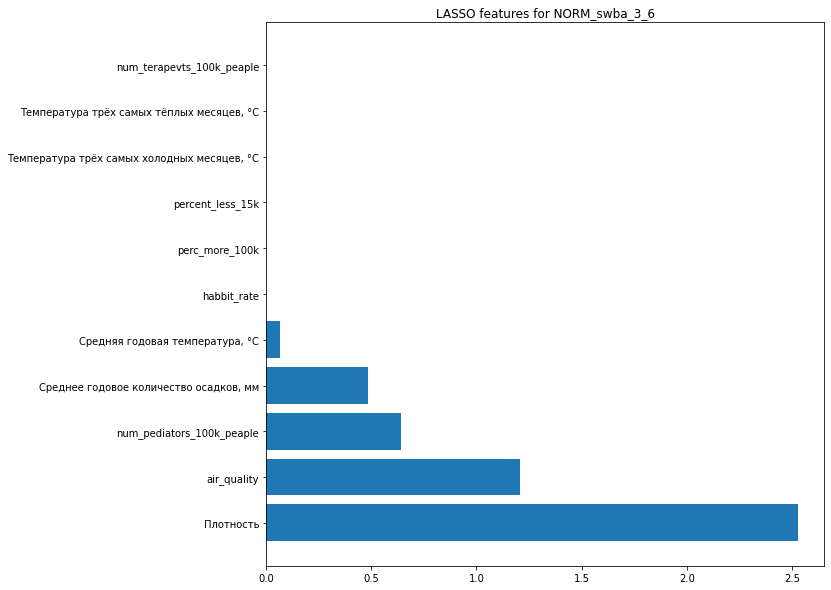

RANDOM FOREST features for NORM_swba_3_6 Best CV score: -132.67428672753556


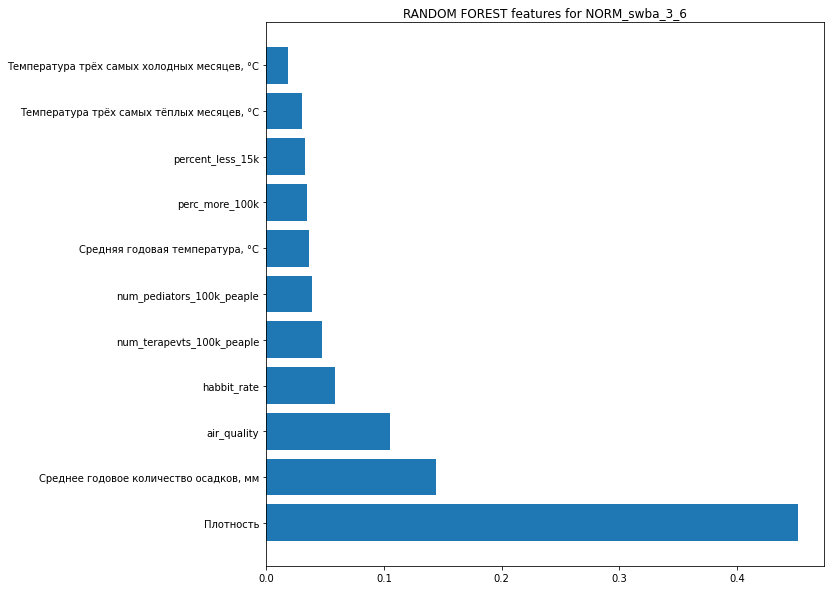

LASSO features for NORM_swba_7_14 Best CV score: -15.773402202899552


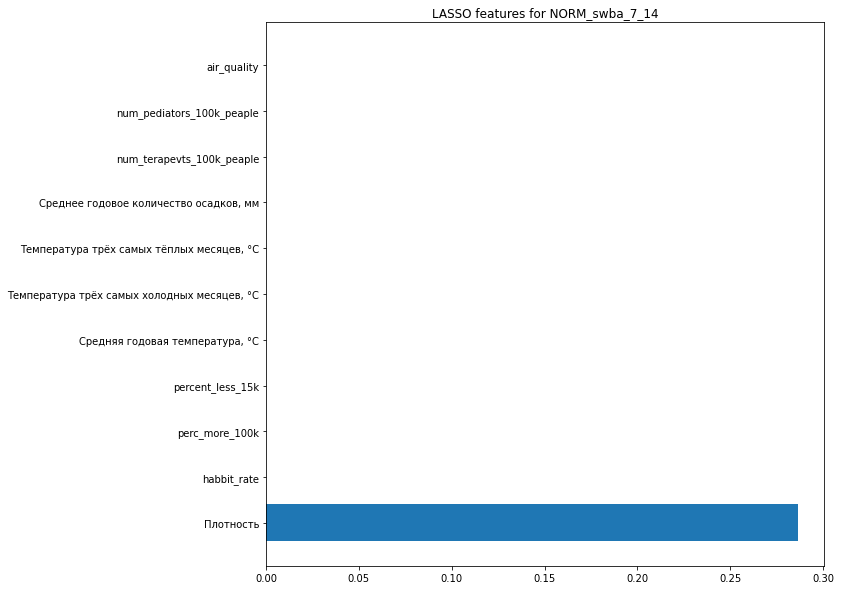

RANDOM FOREST features for NORM_swba_7_14 Best CV score: -15.92450276779287


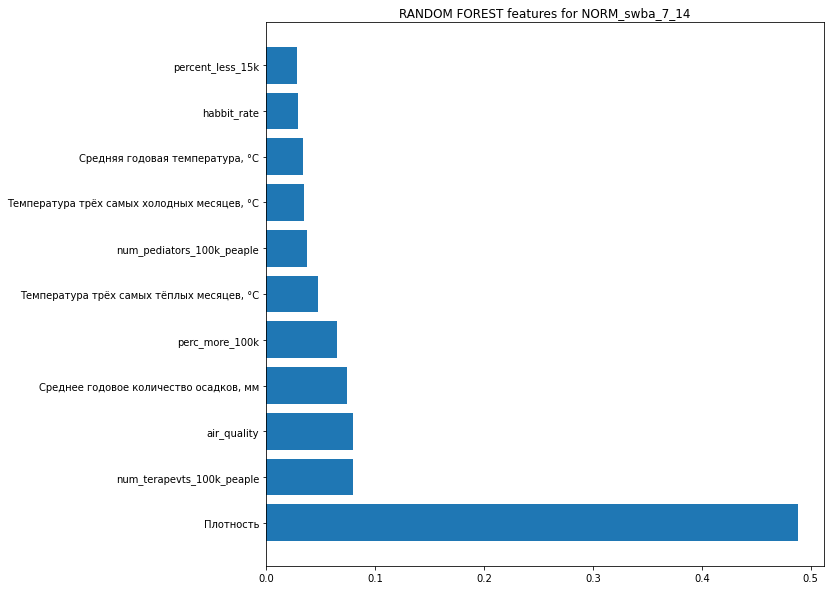

LASSO features for NORM_swba_15 Best CV score: -2.6327110389707133


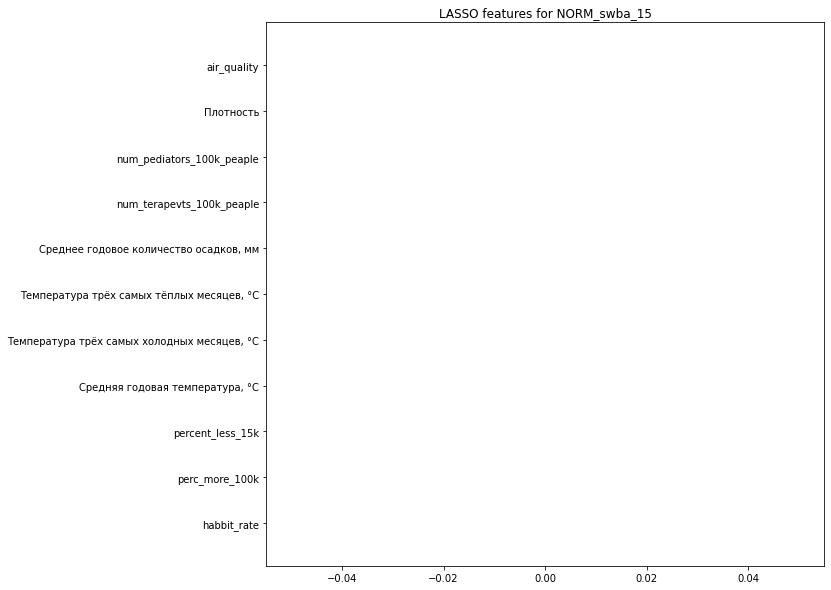

RANDOM FOREST features for NORM_swba_15 Best CV score: -3.075471843708225


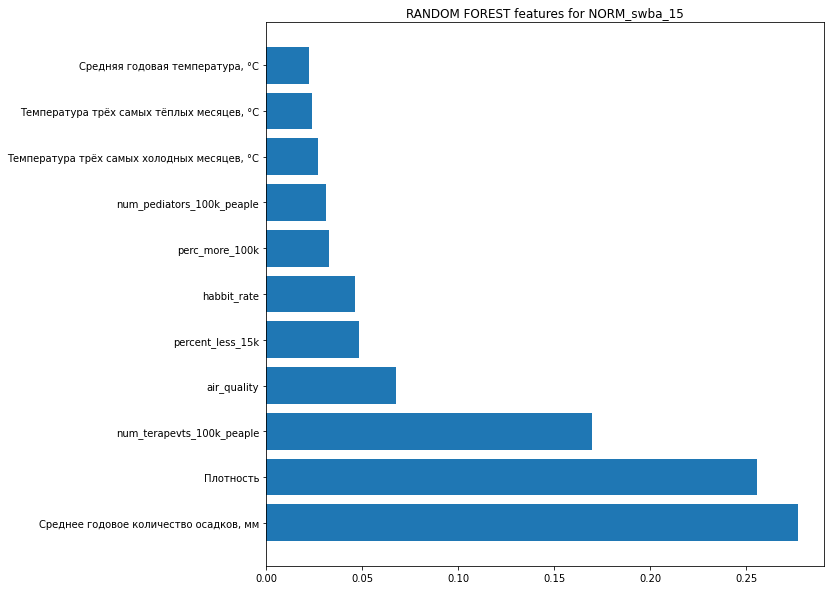

LASSO features for NORM_swba_TOTAL Best CV score: -10.84189244070132


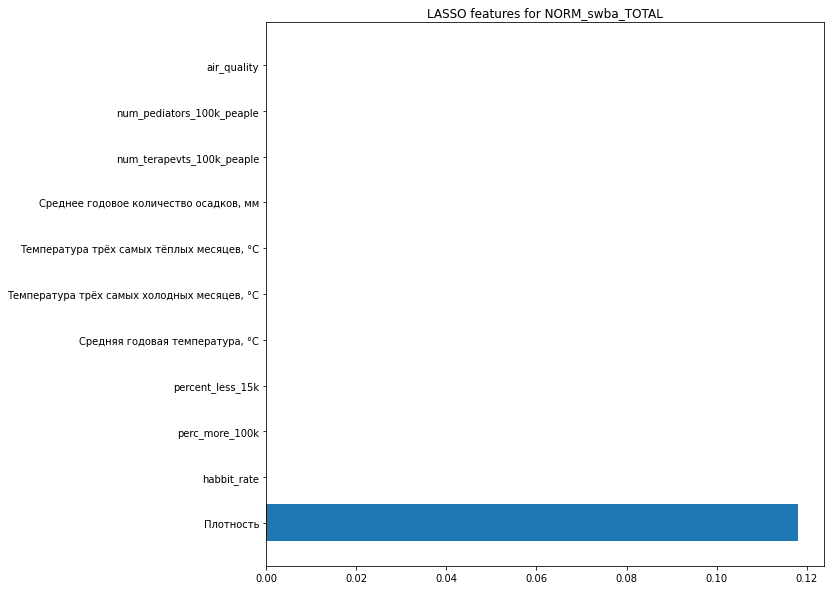

RANDOM FOREST features for NORM_swba_TOTAL Best CV score: -9.93347779121587


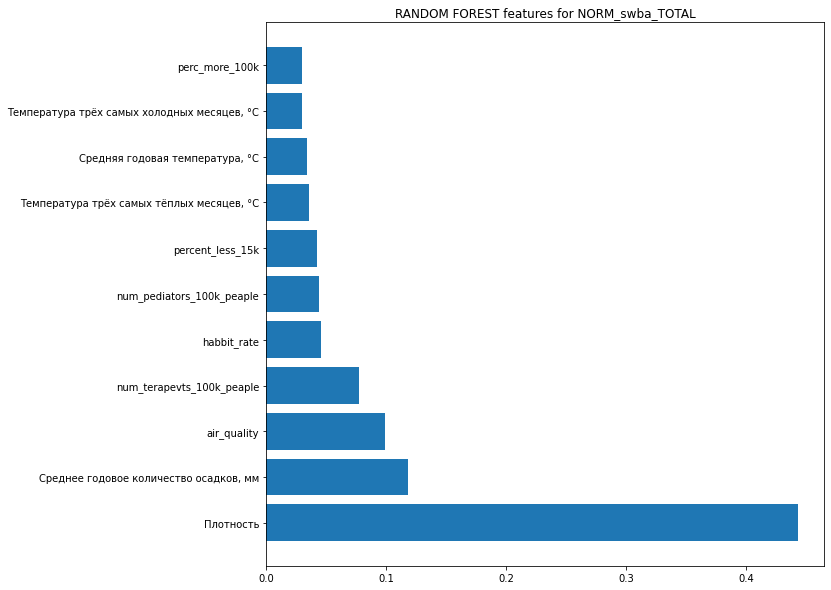

LASSO features for NORM_posa_0_2 Best CV score: -363.0848007530326


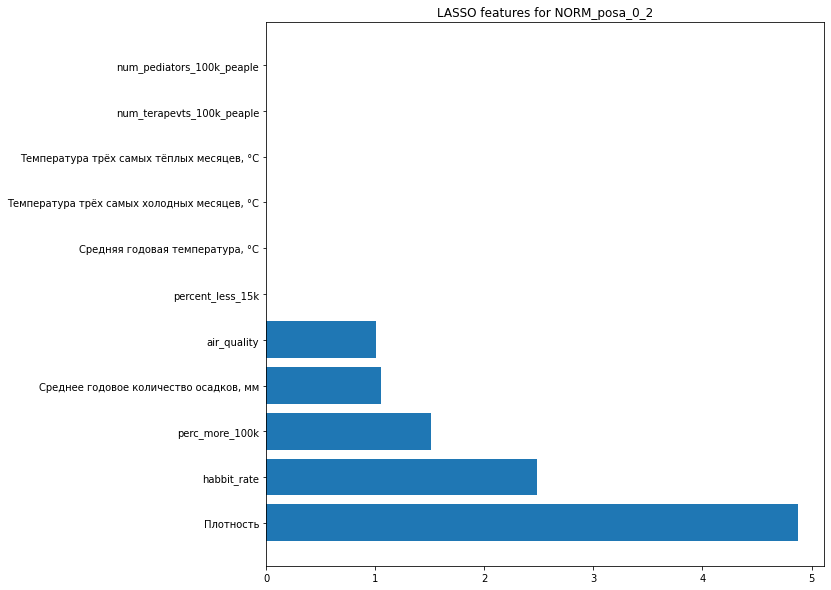

RANDOM FOREST features for NORM_posa_0_2 Best CV score: -335.1004648474603


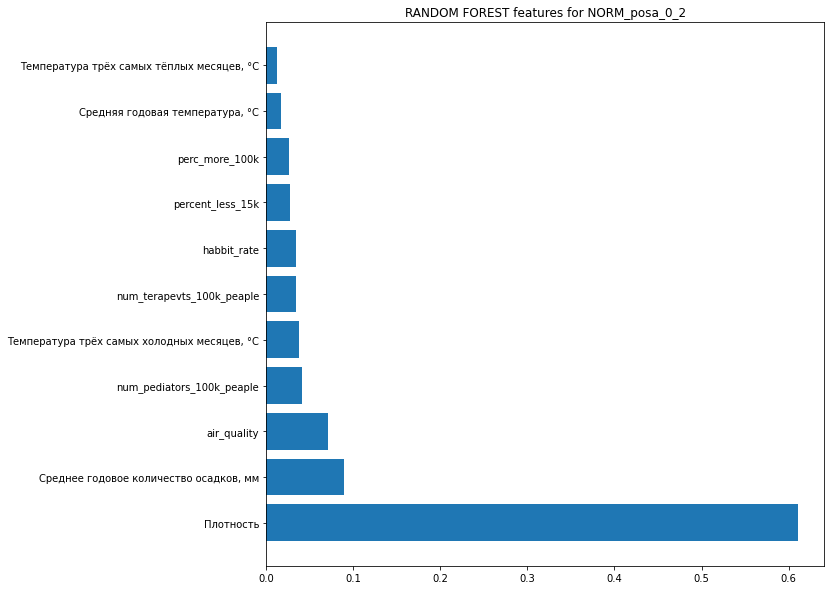

LASSO features for NORM_posa_3_6 Best CV score: -26.78730375621931


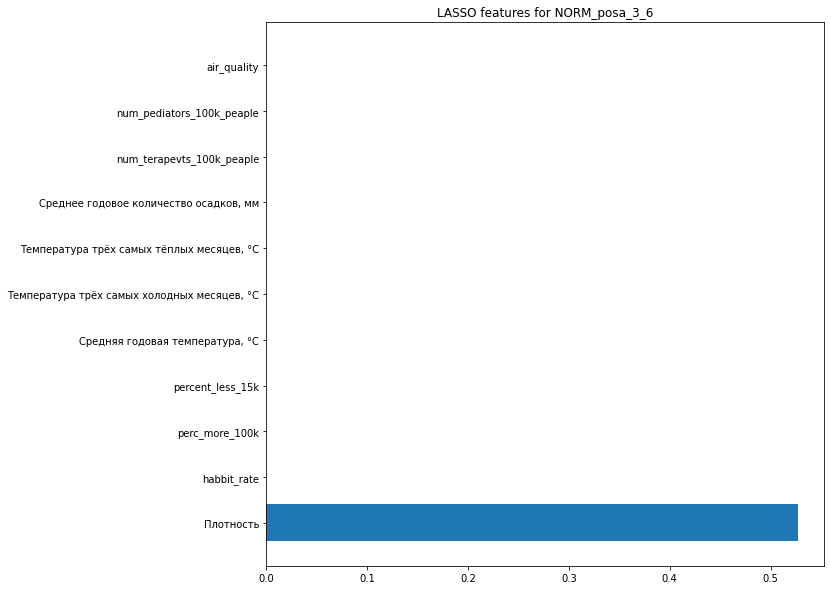

RANDOM FOREST features for NORM_posa_3_6 Best CV score: -22.822898273536364


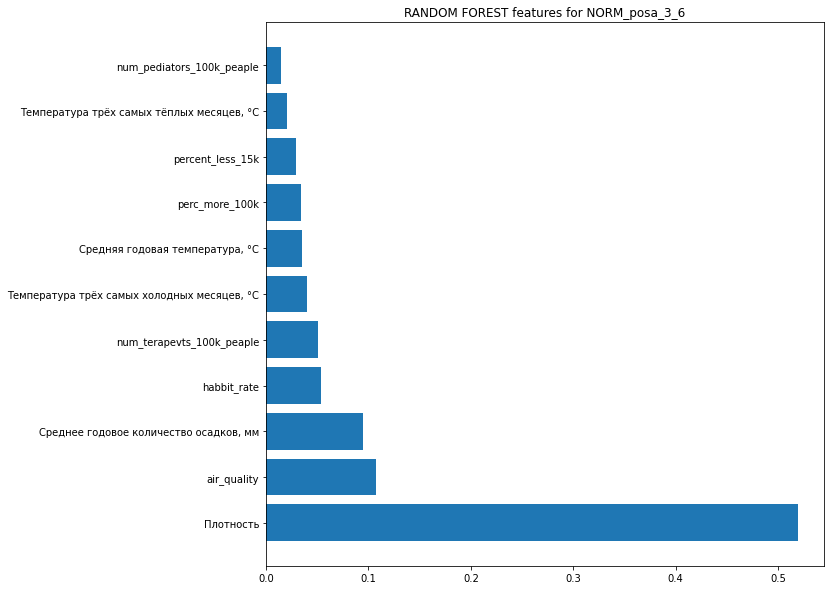

LASSO features for NORM_posa_7_14 Best CV score: -1.2257155633671069


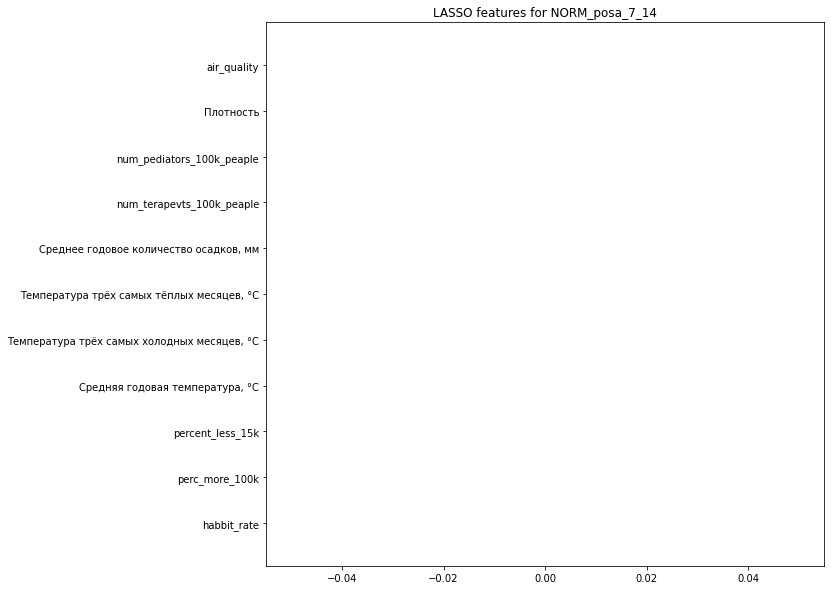

RANDOM FOREST features for NORM_posa_7_14 Best CV score: -1.1716958307371126


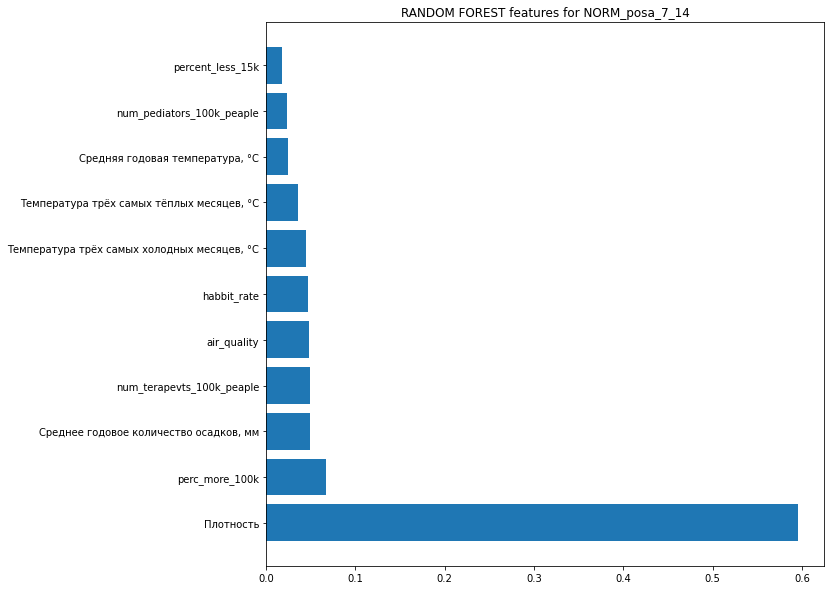

LASSO features for NORM_posa_15 Best CV score: -0.09009069584592248


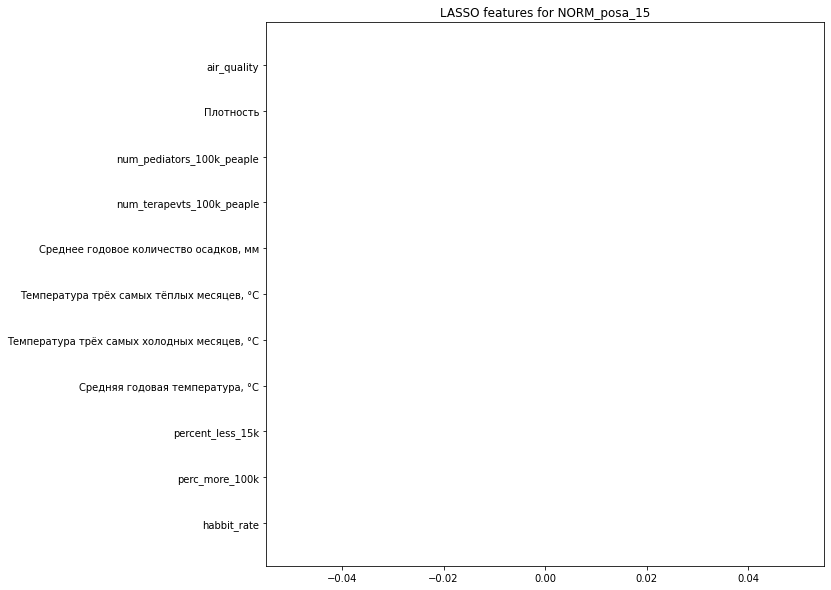

RANDOM FOREST features for NORM_posa_15 Best CV score: -0.08062607283064704


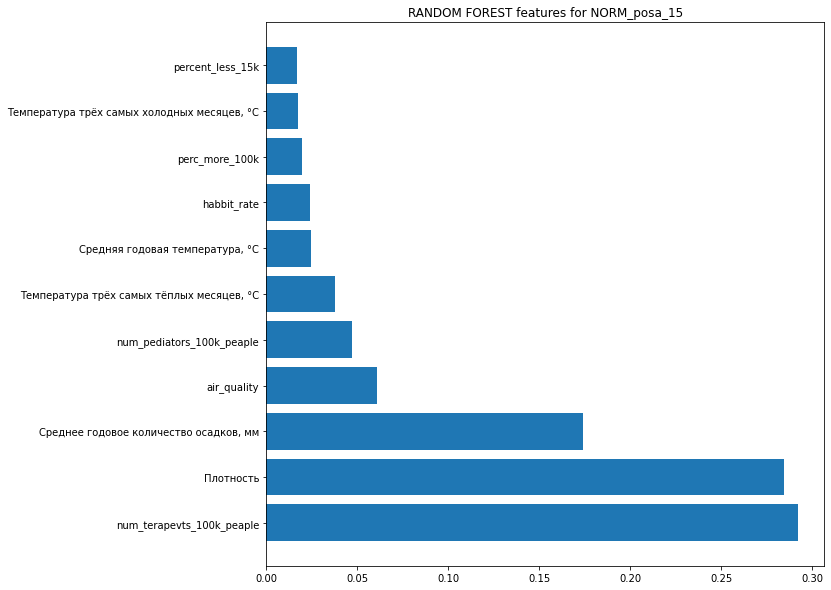

LASSO features for NORM_posa_TOTAL Best CV score: -1.3965469164003228


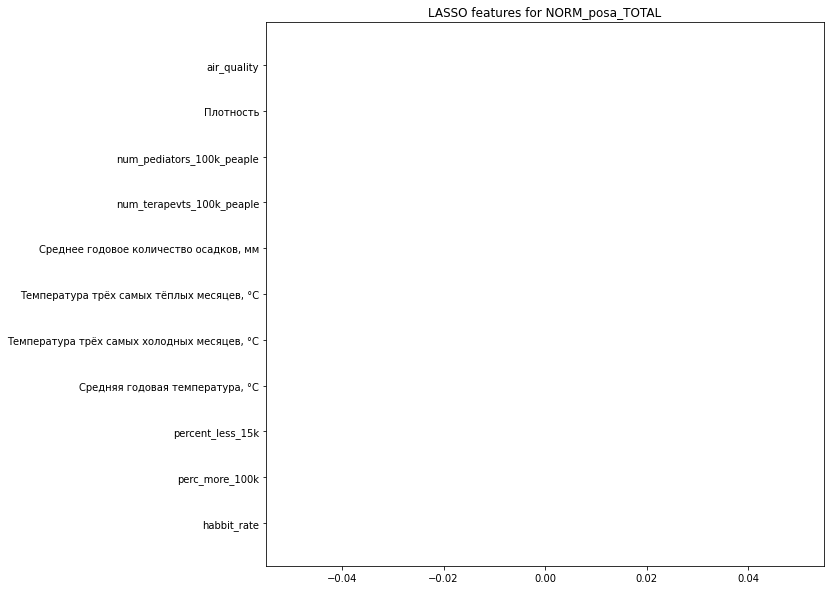

RANDOM FOREST features for NORM_posa_TOTAL Best CV score: -1.3880575060549776


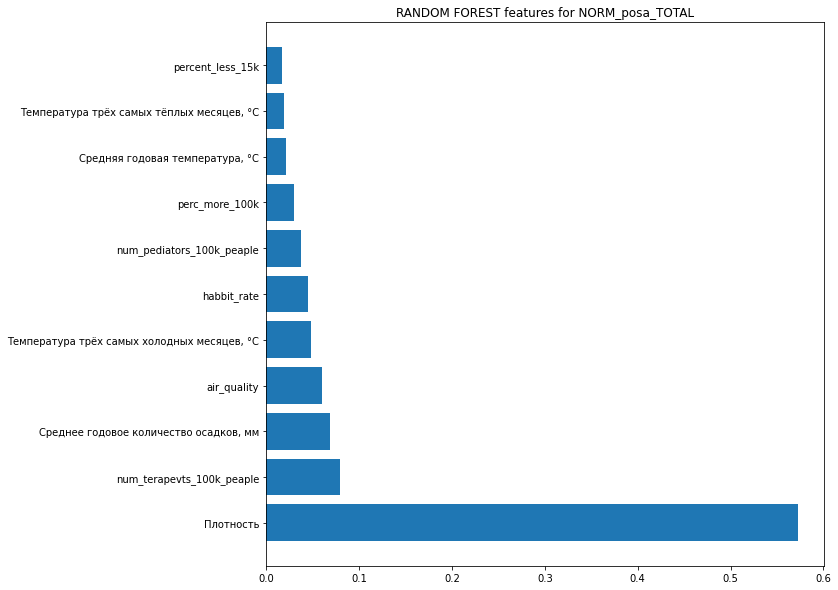

In [38]:
all_targets = [tg for tg in targets.columns if tg != 'DISTRICT_NAME' and not tg.startswith('NORM_ILI')]

for tg in all_targets:
    plot_feature_importances(linear_model.Lasso(max_iter=10_000), merged, tg, title=f'LASSO features for {tg}', scale=True)
    plot_feature_importances(RandomForestRegressor(), merged, tg, title=f'RANDOM FOREST features for {tg}')

LASSO features for NORM_ARI_TOTAL Best CV score: -10267.168862190196


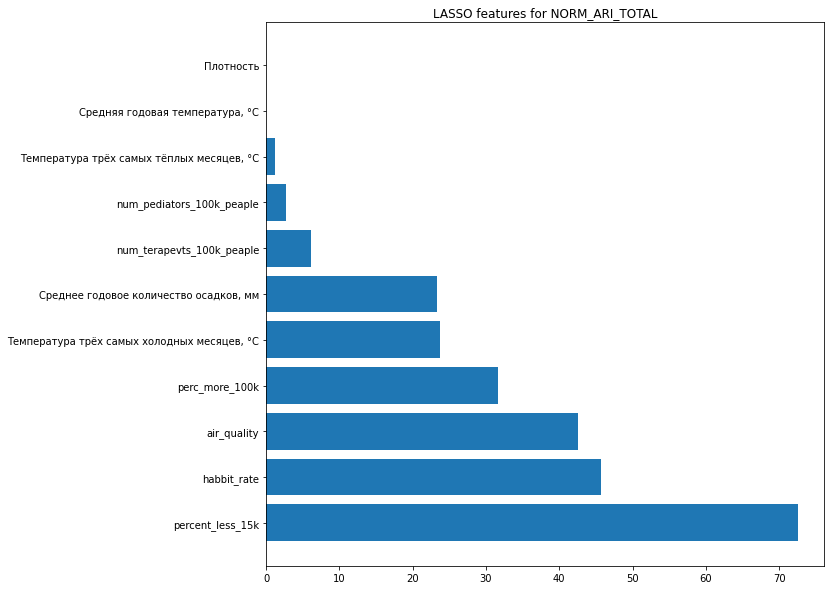

LASSO features for NORM_ARI_0_2 Best CV score: -995219.2682422822


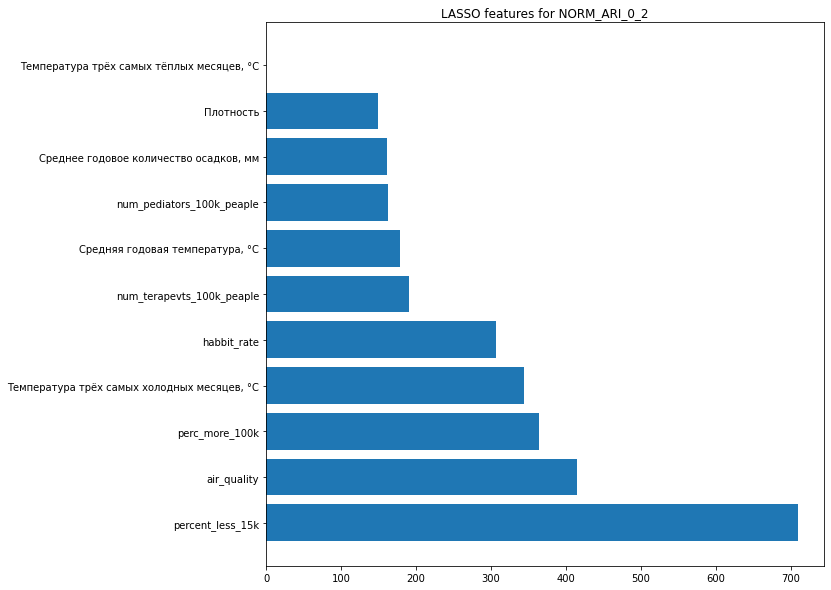

LASSO features for NORM_ARI_3_6 Best CV score: -613560.0552068944


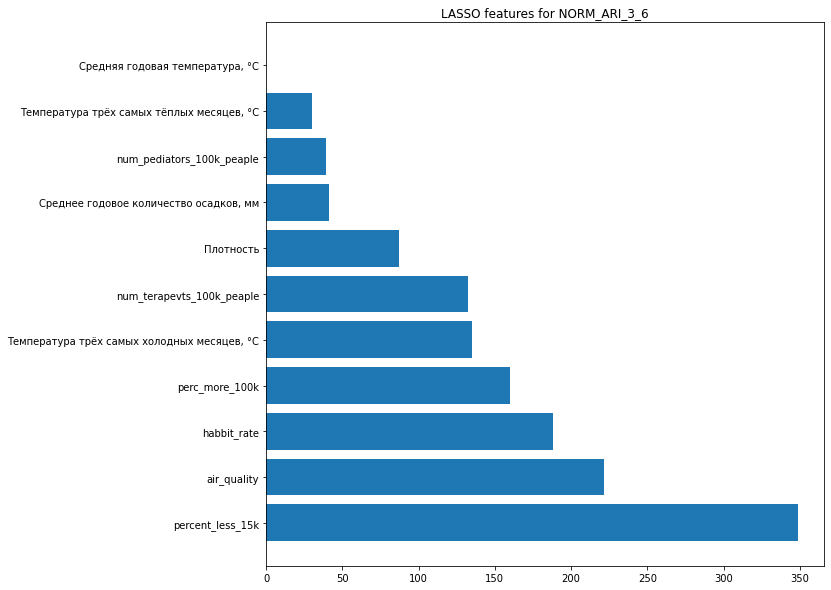

LASSO features for NORM_ARI_7_14 Best CV score: -27894.93463268056


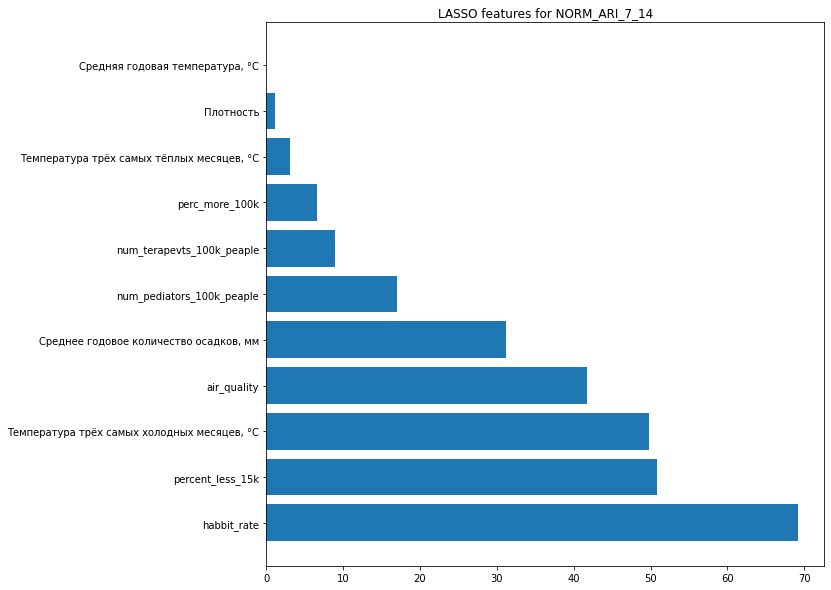

LASSO features for NORM_ARI_15 Best CV score: -2109.4113067108983


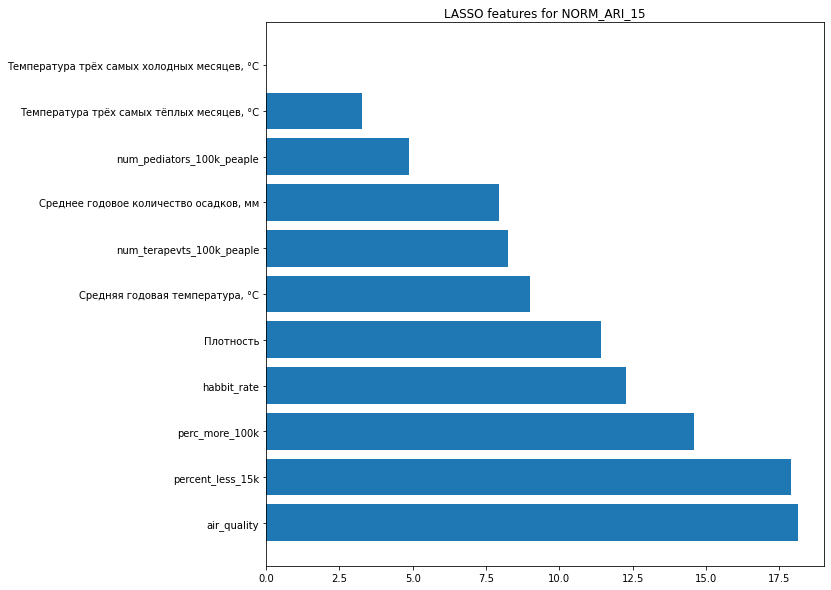

In [40]:
all_targets = [
    'NORM_ARI_TOTAL',
    'NORM_ARI_0_2',
    'NORM_ARI_3_6',
    'NORM_ARI_7_14',
    'NORM_ARI_15',
#     'NORM_SWB_TOTAL',
#     'NORM_POS_TOTAL',
#     'NORM_swba_TOTAL',
#     'NORM_posa_TOTAL',
]

for tg in all_targets:
    plot_feature_importances(linear_model.Lasso(max_iter=10_000), merged, tg, title=f'LASSO features for {tg}', scale=True)
#     plot_feature_importances(RandomForestRegressor(), merged, tg, title=f'RANDOM FOREST features for {tg}')

<BarContainer object of 11 artists>

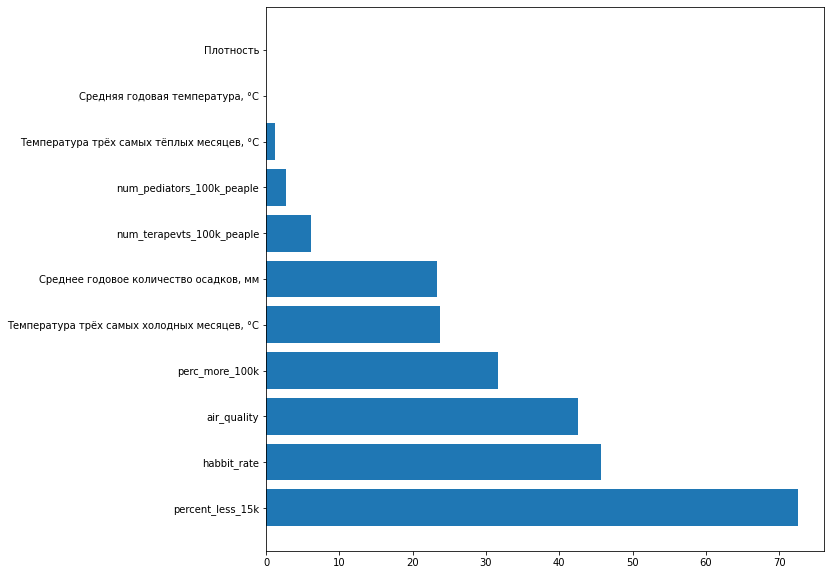

In [190]:
importances = lasso.best_estimator_.coef_
features = data.drop(columns='DISTRICT_NAME').columns
df = pd.DataFrame([abs(importances), features]).T.sort_values(0, ascending=False)
plt.figure(figsize=(10, 10))
plt.barh(df[1], df[0])

-2.020575305347319


<BarContainer object of 11 artists>

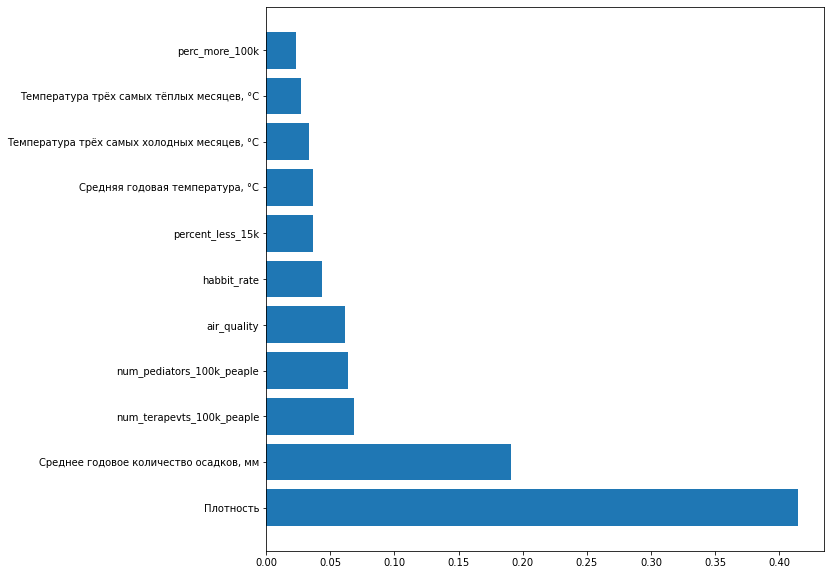

In [181]:
rfr = GridSearchCV(RandomForestRegressor(), param_grid={}, cv=10, scoring='neg_mean_absolute_error')
fit_model(rfr, merged, 'NORM_SWB_TOTAL')
print(rfr.best_score_)
importances = rfr.best_estimator_.feature_importances_
features = data.drop(columns='DISTRICT_NAME').columns
df = pd.DataFrame([abs(importances), features]).T.sort_values(0, ascending=False)
plt.figure(figsize=(10, 10))
plt.barh(df[1], df[0])

-105.2756218382596


<BarContainer object of 11 artists>

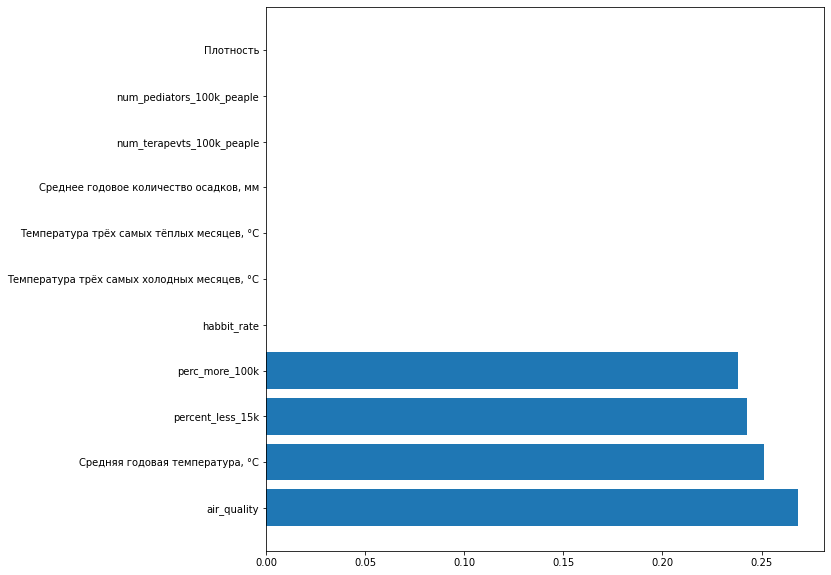

In [180]:
tr = GridSearchCV(tree.DecisionTreeRegressor(max_depth=3), param_grid={}, cv=10, scoring='neg_mean_absolute_error')
fit_model(tr, merged, 'NORM_ARI_TOTAL')
print(tr.best_score_)
importances = tr.best_estimator_.feature_importances_
features = data.drop(columns='DISTRICT_NAME').columns
df = pd.DataFrame([abs(importances), features]).T.sort_values(0, ascending=False)
plt.figure(figsize=(10, 10))
plt.barh(df[1], df[0])

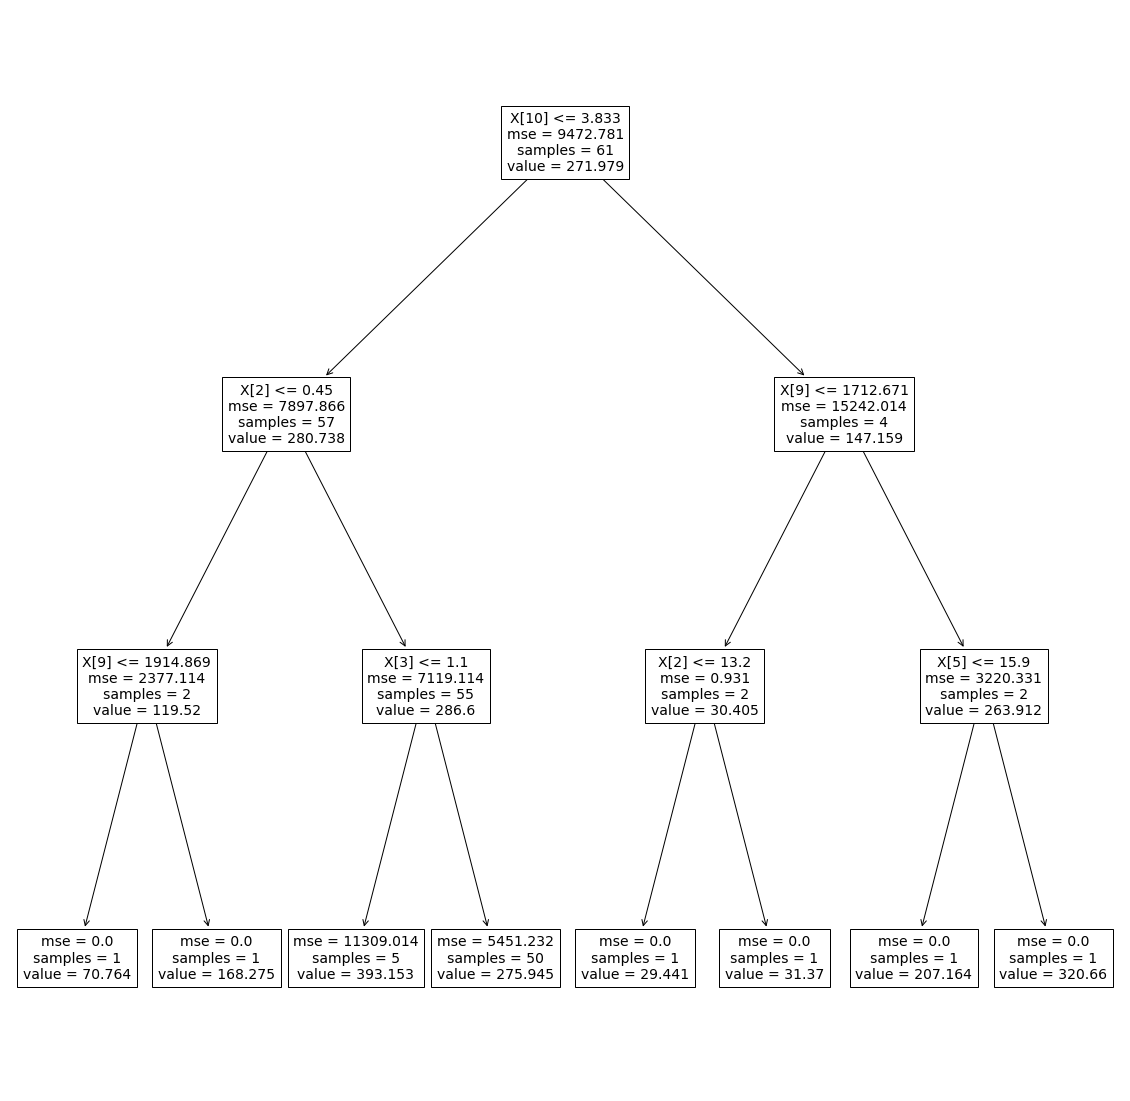

In [161]:
plt.figure(figsize=(20, 20))
tree.plot_tree(tr.best_estimator_)
plt.show()